# Starter code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math
#from tensorflow.keras.optimizers import Adam
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers import GRU
#from keras.layers import ReLU
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error

#% matplotlib inline

#import plotly.offline as py
#import plotly.figure_factory as ff
#import plotly.graph_objs as go
from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;

#py.init_notebook_mode(connected=True)

#py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

#from ipywidgets import interact, interactive, fixed, interact_manual, widgets

In [2]:
#list_of_companies_number = ['1080']
#list_of_companies_number = ['13113']

list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [3]:
len(list_of_companies_number)

99

In [4]:
help_time = []

In [5]:
#shape = [(nr of company, every possible timeslot from 8.01 till 16.30, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,5)) 
#data =  np.zeros(shape = (100, 5100,3)) 

In [6]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    five_best_bids_and_asks = np.zeros(shape = (2,2,5))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        five_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        #ask
        five_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        
    return five_best_bids_and_asks

In [7]:
def calc_semi_var(elements):
    mean = np.mean(elements)
    semi_var = 0
    for i in elements:
        if i<mean:
            semi_var += (mean-i)**2
    return semi_var

In [8]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [9]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [10]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [11]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [12]:
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [13]:
def index_to_time(index):
    hour=index//60
    minute=index%60
    return hour+8, minute+1, 0
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [14]:
def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [15]:
def get_order_inbalance(record): #single company
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result

Reading data from files

In [16]:

list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [17]:
# open file in read mode
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<=30)):
                data[count_comp][count] = get_k_best_offers(elements[1:])  
                count+=1

In [18]:
# open file in read mode
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [19]:
data.shape
trades.shape

(99, 10)

# Plot of sweep to fill costs of company nr 1080 (Exhibit 1)

In [20]:
bid_and_ask_through_day = data[98][:510]

In [21]:
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
mid_prices = np.zeros(510)
true_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))

In [22]:
for i in range(510):
    mid_prices[i] = get_mid_price(bid_and_ask_through_day[i])
    true_prices[i] = get_true_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i][j] = get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j], true_prices[i])

Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000


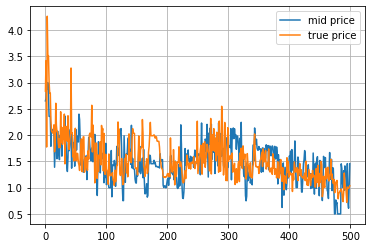

In [23]:
plt.plot(np.arange(500), average_fill_prices[10:,4]-mid_prices[10:])
plt.plot(np.arange(500), average_fill_prices[10:,4]-true_prices[10:])
plt.grid()
plt.legend(['mid price', 'true price'])

mid price


Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill

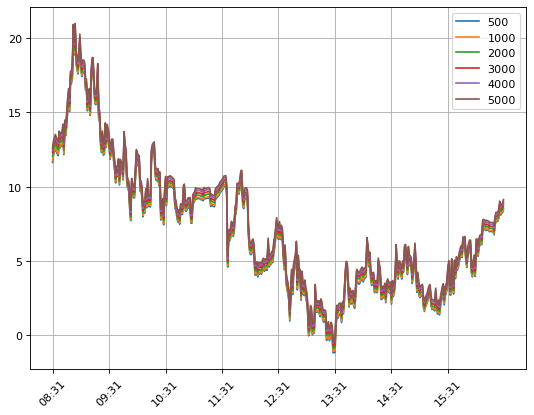

In [24]:
figure(figsize=(8, 6), dpi=80)
bid_and_ask_through_day = data[98]
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
mid_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))
for i in range(5100):
    mid_prices[i%510] += get_mid_price(bid_and_ask_through_day[i])
    curr_mid_price =  get_mid_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i%510][j] += get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j],curr_mid_price)
for i in range(510):
    mid_prices[i]/=10
    average_fill_prices[i]/=10
#print(average_fill_prices[:,0])
mid_prices = apply_moving_average(np.copy(mid_prices), 5)
for i in range(6):
    average_fill_prices[:,i] = apply_moving_average(np.copy(average_fill_prices[:,i]), 5)
#average_fill_prices = apply_moving_average(np.copy(average_fill_prices), 3)

plot_since=30
for i in np.arange(len(order_sizes)):
    plt.plot(np.arange(510-plot_since), average_fill_prices[plot_since:,i]-true_prices[plot_since:])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x+plot_since)) for x in np.arange(510-plot_since, step=60)])
plt.xticks(ticks=np.arange(510-plot_since, step=60), labels=x_axis, rotation=45)
plt.grid()
plt.legend( order_sizes)

true price

Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill

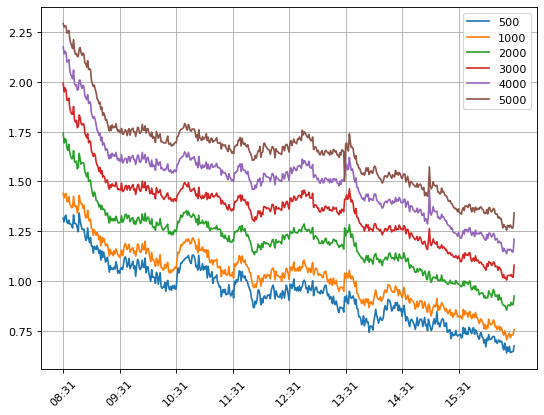

In [25]:
figure(figsize=(8, 6), dpi=80)
bid_and_ask_through_day = data[98]
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
true_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))
for i in range(5100):
    true_prices[i%510] += get_true_price(bid_and_ask_through_day[i])
    curr_true_price =  get_true_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i%510][j] += get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j],curr_true_price)
for i in range(510):
    true_prices[i]/=10
    average_fill_prices[i]/=10
#print(average_fill_prices[:,0])
true_prices = apply_moving_average(np.copy(true_prices), 5)
for i in range(6):
    average_fill_prices[:,i] = apply_moving_average(np.copy(average_fill_prices[:,i]), 5)
#average_fill_prices = apply_moving_average(np.copy(average_fill_prices), 3)

plot_since=30
for i in np.arange(len(order_sizes)):
    plt.plot(np.arange(510-plot_since), average_fill_prices[plot_since:,i]-true_prices[plot_since:])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x+plot_since)) for x in np.arange(510-plot_since, step=60)])
plt.xticks(ticks=np.arange(510-plot_since, step=60), labels=x_axis, rotation=45)
plt.grid()
plt.legend( order_sizes)

In [26]:
bid_and_ask_through_day[0]

array([[[1582., 1580., 1579., 1576., 1575.],
        [1377.,  500., 1044., 8009.,  766.]],

       [[1588., 1589., 1591., 1592., 1596.],
        [1149.,   53., 1036.,  500., 4222.]]])

In [27]:
order_inbalance_one_day=get_order_inbalance(data[0][:510])

Plotting Bid, ask and true market prices(exhibit 6)

In [28]:
mid_price_one_day=np.zeros(510)
true_price_one_day=np.zeros(510)

for i in range (0,510):
    mid_price_one_day[i]=get_mid_price(data[0][i])
    true_price_one_day[i]=get_true_price(data[0][i])

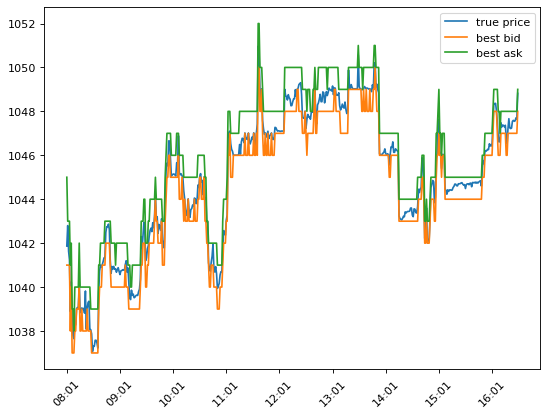

In [29]:
figure(figsize=(8, 6), dpi=80)

#plt.plot(np.arange(510), order_inbalance_one_day)#, mid_price_one_day)

#plt.plot(np.arange(510),  mid_price_one_day)
plt.plot(np.arange(510),  true_price_one_day)
plt.plot(np.arange(510),  data[0,:510,0,0,0])
plt.plot(np.arange(510),  data[0,:510,1,0,0])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x)) for x in np.arange(510, step=60)])
plt.xticks(ticks=np.arange(510, step=60), labels=x_axis, rotation=45)
plt.legend(['true price', 'best bid', 'best ask'])

Plotting Sweep to Fill Costs vs Order Size (exhibit 8 and 9)?????

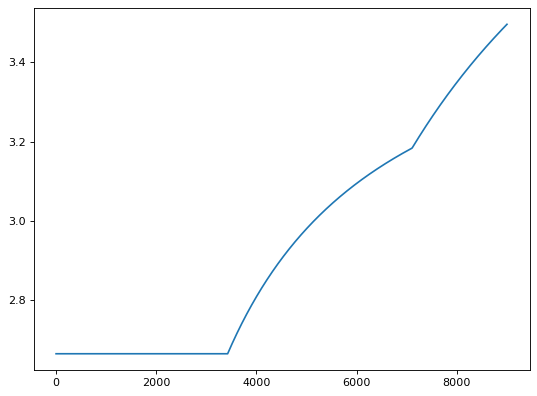

In [30]:
figure(figsize=(8, 6), dpi=80)
#bid_and_ask_through_first_two_hours = data[80][:120]
order_sizes_limit = 9000
true_price = get_true_price(data[80][40])
average_fill_prices = np.zeros(shape = (order_sizes_limit))
for i in range(1,order_sizes_limit+1):
    average_fill_prices[i-1] = get_sweep_to_fill_price(data[80][40], i,true_price)
plt.plot(average_fill_prices-true_price)

In [31]:
data[80][40]

array([[[1640., 1639., 1638., 1637., 1636.],
        [1715., 5727., 2576., 2830., 5163.]],

       [[1644., 1645., 1646., 1647., 1648.],
        [3425., 3681., 4334., 2581., 4997.]]])

In [32]:
order_inbalance_10_days=get_order_inbalance(data[1])
mid_price_10_days=[get_mid_price(data[1][i]) for i in range (0, 5100)]

In [33]:
company=90
order_inbalance_10_days=[round(i, 1) for i in get_order_inbalance(data[company])]
mid_price_10_days=np.asarray([get_mid_price(data[company][i]) for i in range (5100)])
price_diff=mid_price_10_days[:5099]-mid_price_10_days[1:]
inbalance_averageprice={}
for i in range(len(price_diff)):
    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    else:
        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
for k in inbalance_averageprice.keys():
    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

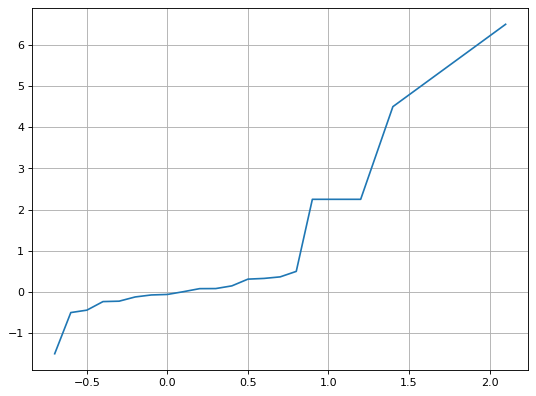

In [34]:
inbalance_averageprice_array=np.sort( np.asarray([[k, v] for k,v in inbalance_averageprice.items()]), axis=0)
figure(figsize=(8, 6), dpi=80)

plt.plot(inbalance_averageprice_array[5:,0], inbalance_averageprice_array[5:,1])

plt.grid()

In [35]:
inbalance_averageprice_array.shape

(25, 2)

Exhibit 17 -> Market impact for E-mini S&P Futures on a Typical Day (how to calculate true price after market impact???)

Unable to fill an order 5000
Unable to fill an order 2500
Unable to fill an order 5000
Unable to fill an order 5000


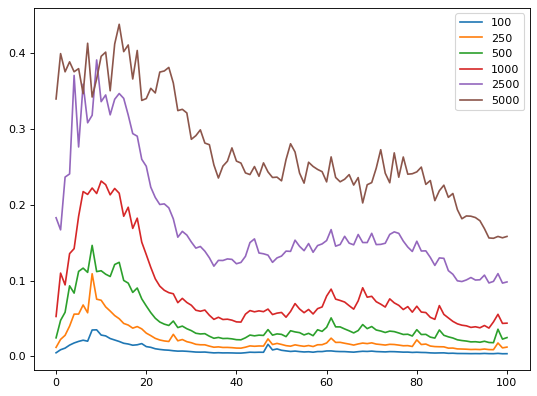

In [36]:
company_id = 15
order_sizes = [100, 250, 500, 1000, 2500, 5000]
num_of_timestamps = int((5100/5)-1)
modulo = int(510/5-1)
differences_in_prices = np.zeros(shape = (modulo, 6))
for i in range(num_of_timestamps):
    for order_size_ind in range(len(order_sizes)):
        price_before = get_true_price(np.copy(data[company_id][i*5]))
        price_after = get_true_price_after_sweep_to_fill(np.copy(data[company_id][i*5]), order_sizes[order_size_ind], price_before)
        differences_in_prices[i%modulo][order_size_ind] += abs(price_after - price_before)
figure(figsize=(8, 6), dpi=80)
for i in range(modulo):
    differences_in_prices[i]/=10
for k in range(len(order_sizes)):
    plt.plot(np.arange(modulo), apply_moving_average(np.copy(differences_in_prices[:,k]), 3))
plt.legend( order_sizes)
    

# Exhibit 3&4


In [37]:
comp_id=1
order_book_comp=np.empty(shape=(10, 510, 2, 2, 5))
order_inbalance_comp=np.empty(shape=order_book_comp.shape[:2])
for i in range(10): #we have data from 10 days, 2 work weeks
    order_book_comp[i]=data[comp_id, 510*i:510*(i+1)]
    order_inbalance_comp[i]=get_order_inbalance(order_book_comp[i])

trades_time_comp=np.copy(trades[comp_id])
for day in trades_time_comp:
    day.sort(key=lambda hour: hour[2]) # sort by trade time
time_to_next_trade=np.empty(shape=order_inbalance_comp.shape)

In [38]:
time_to_next_trade.shape

(10, 510)

In [39]:
trades[0].shape

(10,)

In [40]:
for day in range(time_to_next_trade.shape[0]):
    trade_counter=0
    for book_counter in range(time_to_next_trade.shape[1]):
        #print("XD", book_counter)
        time_tuple=index_to_time(book_counter)
        while time_tuple>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        trade_time_tuple=trades_time_comp[day][trade_counter][2]
        time_to_next_trade[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])-timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
        # time to next trade given in seconds


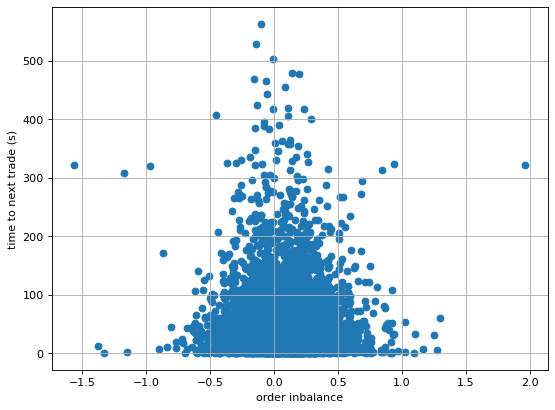

In [41]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='order inbalance', ylabel='time to next trade (s)')
plt.scatter(order_inbalance_comp.flatten(), time_to_next_trade.flatten())
plt.grid()
plt.show()

In [42]:
next_trades_prices=np.empty(shape=order_inbalance_comp.shape)
for day in range(time_to_next_trade.shape[0]):
    trade_counter=0
    for book_counter in range(time_to_next_trade.shape[1]):
        time_tuple=index_to_time(book_counter)
        while time_tuple>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        next_trade_price=trades_time_comp[day][trade_counter][0]
        next_trades_prices[day, book_counter]=next_trade_price
        # time to next trade given in seconds

In [43]:
mid_market_prices=np.empty(shape=order_inbalance_comp.shape)
for day in range(order_book_comp.shape[0]):
    for record in range(order_book_comp.shape[1]):
        mid_market_prices[day, record]=get_mid_price(order_book_comp[day, record])

In [44]:
for day in range(mid_market_prices.shape[0]):
    for record in range(mid_market_prices.shape[1]):
        if mid_market_prices[day,record]==0:
            print(day, record)

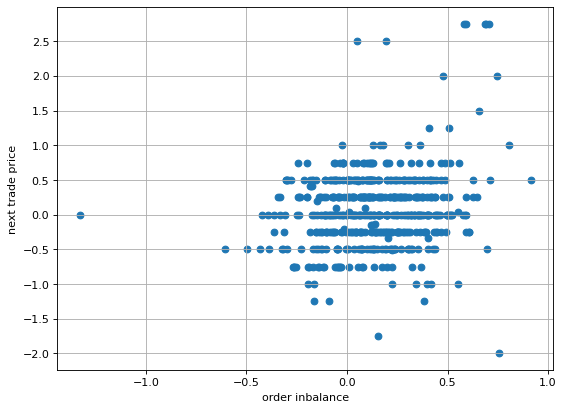

In [45]:
figure(figsize=(8, 6), dpi=80)
day=5
plt.axes(xlabel='order inbalance', ylabel='next trade price')
plt.scatter(order_inbalance_comp[day].flatten(), (next_trades_prices-mid_market_prices)[day].flatten())
max_next_trade_price=max((next_trades_prices-mid_market_prices)[day].flatten())
min_next_trade_price=min((next_trades_prices-mid_market_prices)[day].flatten())
plt.yticks(ticks=np.arange(start=min_next_trade_price, stop=max_next_trade_price, step=0.5))
plt.grid()
plt.show()

# Exhibit 11&12


In [46]:
interval=1
comp_id=3
order_book_comp=np.empty(shape=(10, 510, 2, 2, 5))
for i in range(10): #we have data from 10 days, 2 work weeks
    order_book_comp[i]=data[comp_id, 510*i:510*(i+1)]

trades_time_comp=np.copy(trades[comp_id])
for day in trades_time_comp:
    day.sort(key=lambda hour: hour[2]) # sort by trade time

timestamps=510//interval
# buys on even, sells on odd
vwaps=np.zeros(shape=(10,2*timestamps)) 
order_sizes=np.zeros(shape=(10,2*timestamps))
#vwaps_sells=np.zeros(shape=(10,timestamps))
#order_sizes_sells=np.zeros(shape=(10,timestamps))



In [47]:
empty_orders=0
for day in range(vwaps.shape[0]):
    trade_counter=0
    for counter in range(vwaps.shape[1]//2):
        true_price=get_true_price(order_book_comp[day,counter])
        time_tuple=index_to_time(interval*(counter+1))
        buys=[]
        sells=[]
        buys_weights=[]
        sells_weights=[]
        while time_tuple>trades_time_comp[day][trade_counter][2]:
            if true_price<trades_time_comp[day][trade_counter][0]:
                buys.append(trades_time_comp[day][trade_counter][0])
                buys_weights.append(trades_time_comp[day][trade_counter][1])
            else:
                sells.append(trades_time_comp[day][trade_counter][0])
                sells_weights.append(trades_time_comp[day][trade_counter][1])               
            trade_counter+=1
            
        # in case there were no sells or buys during the interval            
        try:
            buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
        except:
            buys_avg=true_price
            buys_vol=0
            empty_orders+=1
        try:
            sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
        except:
            sells_avg=true_price
            sells_vol=0
            empty_orders+=1
        if sells_vol>10000 or buys_vol>10000:
            continue 
        vwaps[day,2*counter]=buys_avg-true_price
        vwaps[day,2*counter +1]=true_price-sells_avg
        order_sizes[day,2*counter]=buys_vol
        order_sizes[day,2*counter +1]=sells_vol
print('{}% of intervals were empty'.format(100*empty_orders/(10*2*timestamps)))

64.42156862745098% of intervals were empty


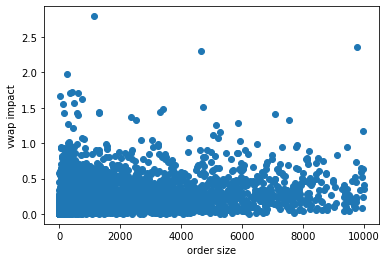

In [48]:
plt.axes(xlabel='order size', ylabel='vwap impact')
plt.scatter(order_sizes.flatten(), vwaps.flatten())

In [49]:
stacked_vwaps_sizes=np.stack((vwaps.flatten(), order_sizes.flatten()), axis=-1)
stacked_vwaps_sizes=np.sort(stacked_vwaps_sizes, axis=0)
#np.unique(stacked_vwaps_sizes, return_counts=True)

In [50]:
np.sort(np.array([[1,2],[1,4],[1,3]]), axis=0)

array([[1, 2],
       [1, 3],
       [1, 4]])

In [51]:
stacked_vwaps_sizes=np.stack((vwaps.flatten(), order_sizes.flatten()), axis=-1)
stacked_vwaps_sizes=np.sort(stacked_vwaps_sizes, axis=0)
#for x in  stacked_vwaps_sizes:#[:,0]
 #   if x[0]:
  #      print(x)

In [52]:
np.unique(order_sizes, return_counts=True)[1][0]

7060

In [53]:
np.unique(vwaps, return_counts=True)[1][0]

7060

In [54]:
vwaps[0].shape

(1020,)

**Exhibit 15 & 16**

In [55]:
company_id = 0
how_many_days = trades[company_id].shape[0]
num_of_five_min_buck = (7*60+2*30)//5
trading_volume_in_buckets = np.zeros(num_of_five_min_buck)
open_hour = 8
open_min = 30
end_hour = 16
end_min = 30
min_prices_in_buckets = np.ones(num_of_five_min_buck) * 10000000.0
max_prices_in_buckets = np.zeros(num_of_five_min_buck)

In [56]:
for i in range(10): #for every day
    for trade in trades[company_id][i]:
        trade_time = trade[2]
        trade_hour = trade_time[0]
        trade_min = trade_time[1]
        if (trade_hour<open_hour) or (trade_hour==open_hour and trade_min<open_min) or (trade_hour==end_hour and trade_min>end_min) or trade_hour>end_hour:
            #print(trade)
            #print(trade_hour<open_hour)
            #print(trade_hour==open_hour and trade_min<open_min)
            #print(trade_hour==end_hour and trade_min>end_min)
            #print(trade_hour)
            #print(end_hour)
            #print(trade_hour>end_hour)
            continue
        which_bucket = ((trade_hour-open_hour)*60 + (trade_min-open_min))//5
        min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
        max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
        trading_volume_in_buckets[which_bucket] += trade[1]
trading_volume_in_buckets/=10 #we take average of all days

In [57]:
price_volatility_in_buckets = max_prices_in_buckets - min_prices_in_buckets

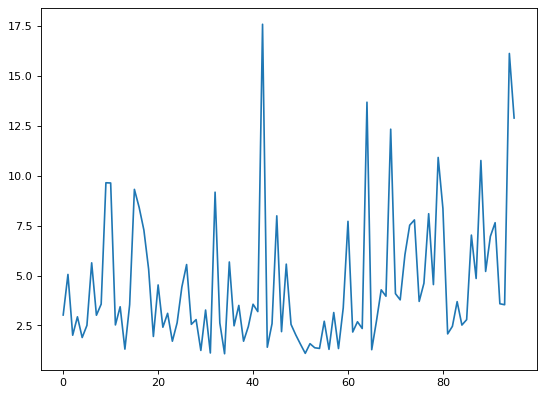

In [58]:
figure(figsize=(8, 6), dpi=80)

plt.plot(trading_volume_in_buckets/1000)

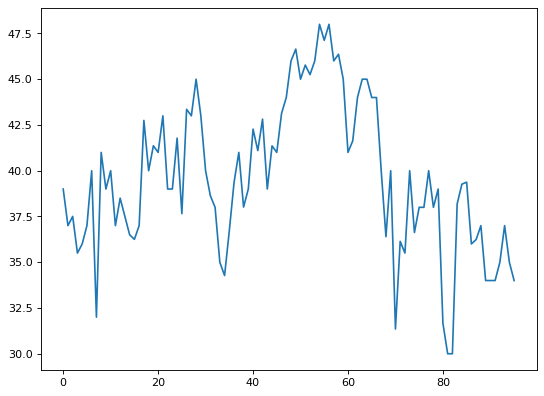

In [59]:
figure(figsize=(8, 6), dpi=80)
plt.plot(price_volatility_in_buckets)

# plot ORDER_IMPACT & VWAP


In [60]:
def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]
    result=np.zeros(timestamps//interval)
    for i in range (0,timestamps//interval):
        for j in range(interval):
            result[i]+=math.log((1e-10+np.sum(record[i+j][0][1]))/(1e-10+np.sum(record[i+j][1][1]))) # ln(bid size/ask size)
    return result

In [61]:
def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [62]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(vwaps.shape[0]):
        trade_counter=0
        for counter in range(vwaps.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(interval*(counter+1))
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
                sells_vol=math.nan
            if buys_vol>max_vol:
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return vwaps, order_sizes

In [63]:
np.average(np.arange(start=0, stop=11), weights=np.arange(11), returned=True)

(7.0, 55.0)

22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty


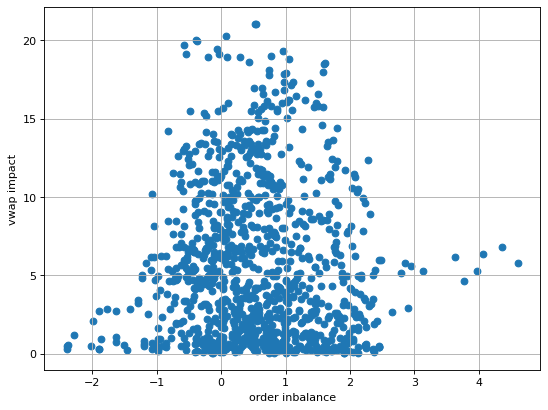

In [64]:
company=1
interval=5
time_to_skip=30
vwap, _=get_vwap_and_ordersizes_comp(company, interval, time_to_skip, use_abs=True)
order_inbalance=get_order_inbalance_comp(company, interval, time_to_skip)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='order inbalance', ylabel='vwap impact')
plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), vwap)
plt.grid()


In [65]:
order_inbalance.shape


(10, 96)

#  NEXTORDERX & S2FIMPACT

In [66]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(book_counter*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=np.abs(next_trade_price-true_price) #abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])-timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError
    return next_trade_x

In [67]:
order_book_comp=np.empty(shape=(10, 510-30, 2, 2, 5))
for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[0, 510*i+30:510*(i+1)]
get_true_price(order_book_comp[1, 4])

1044.0542079729794

In [68]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(interval*(counter+1))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError:
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError:
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [69]:
get_sweep_to_fill_price(data[0, 965], 40137, get_true_price(data[0, 965]), sweep_buys=False)

1051.0469392331265

In [70]:
get_true_price(data[0, 965])

1048.9780872414447

In [71]:
data[0, 965]

array([[[ 1048.,  1047.,  1046.,  1045.,  1044.],
        [ 9552., 16964., 14256.,  8836., 11223.]],

       [[ 1050.,  1051.,  1052.,  1053.,  1054.],
        [ 9980., 18293., 14908.,  7544., 12958.]]])

21.515151515151516% of intervals were SELL empty
27.828282828282827% of intervals were BUY empty
20.606060606060606% of intervals were SELL empty
26.565656565656564% of intervals were BUY empty


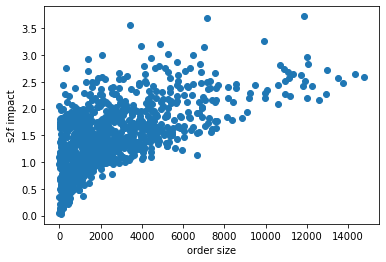

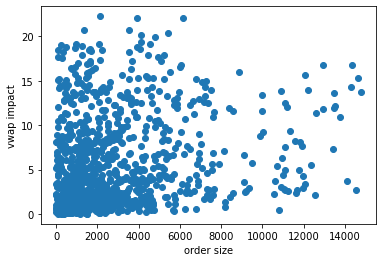

In [72]:
company_id=98
interval=5
time_to_skip=15

s2f_impacts, order_sizes_s2f=get_s2f_impact_and_ordersizes_comp(company_id, interval, time_to_skip,)
vwaps, order_sizes_vwaps=get_vwap_and_ordersizes_comp(company_id, interval, time_to_skip, max_vol=np.max(order_sizes_s2f.flatten()))

plt.axes(xlabel='order size', ylabel='s2f impact')
plt.scatter(order_sizes_s2f.flatten(), s2f_impacts.flatten())
plt.show()
plt.axes(xlabel='order size', ylabel='vwap impact')
plt.scatter(order_sizes_vwaps.flatten(), vwaps.flatten())
plt.show()

22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty


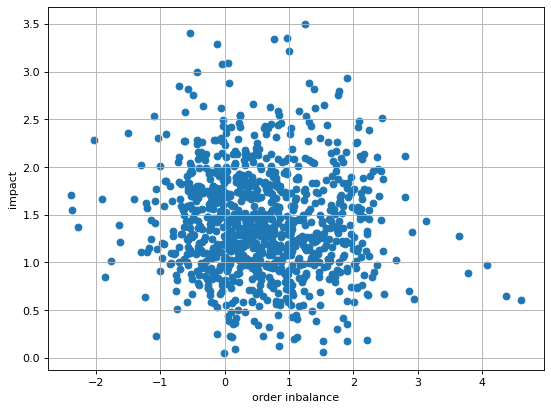

In [73]:
company=1
interval=5
time_to_skip=30
s2f_impacts, _=get_s2f_impact_and_ordersizes_comp(company_id, interval, time_to_skip,)
vwap, _=get_vwap_and_ordersizes_comp(company, interval, time_to_skip, use_abs=True)

order_inbalance=get_order_inbalance_comp(company, interval, time_to_skip)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='order inbalance', ylabel='impact')
plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), s2f_impacts)
#plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), vwap)
#plt.legend(['s2f', 'vwap'])
plt.grid()

# TRUE&MID PRICE


In [74]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp
def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [75]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [76]:
get_price_change_comp(interval=5, time_to_skip=30).shape

(10, 96)

In [77]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('zly shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

# HEATMAP

In [78]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,30,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 10000000.0
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [79]:
def get_trading_volume_and_price_volatility_bula(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (8*60+30-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    open_hour = 8
    open_min = 0
    end_hour = 16
    end_min = 30
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 10000000.0
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            trade_hour = trade_time[0]
            trade_min = trade_time[1]
            if (trade_hour<open_hour) or (trade_hour==open_hour and trade_min<open_min) or (trade_hour==end_hour and trade_min>end_min) or trade_hour>end_hour:
                continue
            which_bucket = ((trade_hour-open_hour)*60 + (trade_min-open_min))//interval
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [80]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
#trading_volumes_bula, price_volatilities_bula = get_trading_volume_and_price_volatility_bula(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
33.052083333333336% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
(10, 480)
(10, 480)
33.197916666666664% of intervals were SELL empty
36.270833333333336% of intervals were BUY empty
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


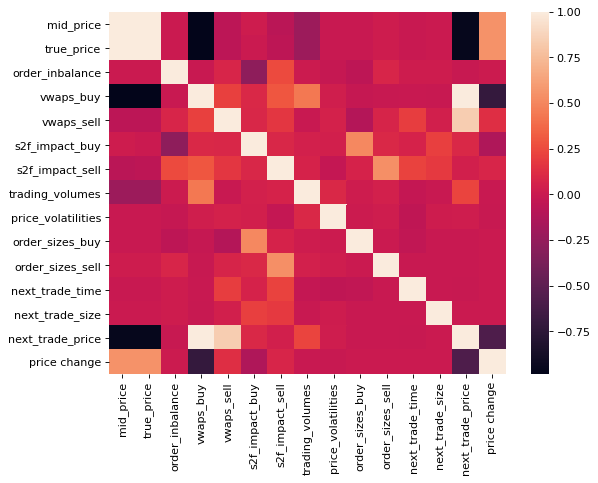

In [81]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='pearson'))
plt.show()

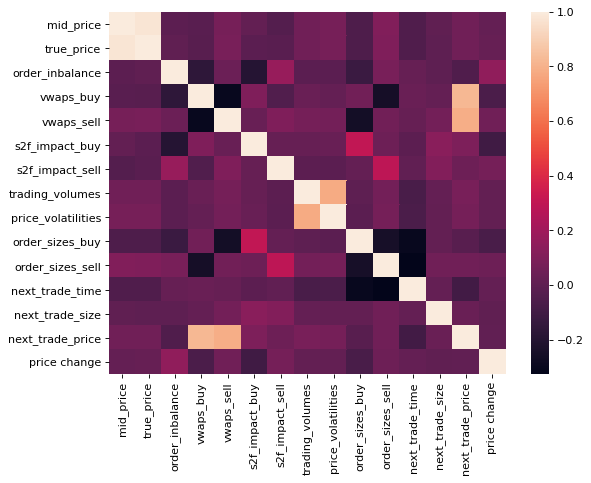

In [82]:
figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

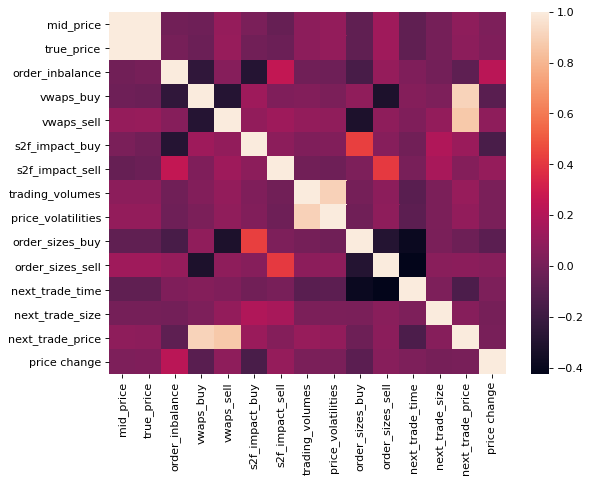

In [83]:
figure(figsize=(8, 6), dpi=80)

ax = sns.heatmap(df.corr(method='spearman'))
plt.show()

# LOGISTIC REGRESSION

In [84]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures


In [85]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
    rolled_records = np.roll(records, past, axis = 1)
    rolled_records = rolled_records[:,past:]
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            elements_in_past = np.copy(records[day][buck:buck+past])
            count_elem = 0.0
            sum_elem = 0.0
            for i in range(len(elements_in_past)):
                if math.isnan(elements_in_past[i]):
                    elements_in_past[i] = 0
                else:
                    sum_elem+=elements_in_past[i]
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [86]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
#trading_volumes_bula, price_volatilities_bula = get_trading_volume_and_price_volatility_bula(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
33.052083333333336% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
(10, 480)
(10, 480)
33.197916666666664% of intervals were SELL empty
36.270833333333336% of intervals were BUY empty
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


In [87]:
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [88]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
                res[i][j] = 1
            else:
                res[i][j]=0
    #print(true_prices)
    #print(res)
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            if (min_val-true_prices[i,j])/true_prices[i,j]<=threshold: # price swing >= than threshold % of price
                res[i][j] = 1
            else:
                res[i][j]=0

    return res

In [89]:
xd = get_true_price_comp(1, 5, 0)
print(xd[0])
print("ELDOO")
print(get_y_to_test_max_bool(xd, 60, 5)[0])

[871.14150943 872.93830598 870.92605887 872.91324752 877.23645902
 874.80857143 873.97417707 874.77054292 878.47576887 878.16017316
 875.57692308 874.88997821 873.2161157  875.30665533 874.82089852
 872.84275921 873.16297705 872.64643603 868.86053535 870.49203242
 869.35277896 869.5461934  872.01084746 875.64476331 875.45639891
 877.         876.96293888 876.43243961 876.22871365 877.12225406
 879.17233951 879.43232803 881.19458128 882.66666667 883.90151422
 885.58878849 886.27205716 886.03702532 885.73020408 886.40322581
 887.41653393 886.77476099 887.14677327 889.81996086 891.33978426
 890.24414146 889.38216846 886.92837466 888.92041925 888.45641389
 887.36255124 883.48738812 885.97387844 884.80692704 885.24034458
 885.31997805 886.95688178 886.11451613 885.98539604 884.73603896
 884.88132198 886.45355462 886.35000958 885.84608281 885.67684943
 884.89856158 883.34119217 882.79942576 883.90439771 882.90832408
 882.18553271 881.00237756 883.0247619  882.85167702 882.78255971
 883.23674

# Testing predictions

In [90]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import confusion_matrix

In [91]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [92]:
def get_X_y_classic(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1,
                    period_of_getting_data_to_test = 60,
                    names=[], 
                    y_name='true_price',
                    test_min_max = 'max',
                    epsilon = 1e-7): # use up_and_down or not
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['vwaps_buy', 's2f_impact_buy']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_sell', 's2f_impact_sell']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name in ['vwaps_order_sizes_buy', 's2f_order_sizes_buy']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_order_sizes_sell', 's2f_order_sizes_sell']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name == 'trading_volumes':
            arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'price_volatilities':
            _, arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    y = y[:,time_back:]
    print(y.flatten().shape)
    if test_min_max == 'max':
        y = get_y_to_test_max_bool(np.copy(y), period_of_getting_data_to_test, interval, epsilon)
    elif test_min_max == 'min':
        y = get_y_to_test_min_bool(np.copy(y), period_of_getting_data_to_test, interval, epslon)
    y = y.flatten()
    #print(y)
    return X, y

In [93]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [94]:
def test_logistic_regr_classic(X, y, split_percent, epsilon, 
                               use_scaling=False, 
                               local_names=names,
                               track_params=False):
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    print(X.shape)
    print(y.shape)
    print("SPLIT:", split)
    print(y[split:].shape)
    print(y_predicted.shape)
    print(X[split:].shape)
    print("Number of positive class in training dataset =", np.sum(y[:split]==1))
    print("Number of negative class in training dataset =", np.sum(y[:split]==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y[split:])/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y[split:], y_predicted, labels = [1, 0])
    print(conf_mat)
    print("Precision:")
    precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
    print(precision)
    print("Recall:")
    recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
    print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:]), precision, recall

In [95]:
def test_logistic_regr_classic_cross_val(X_train, y_train, X_test, y_test, 
                               use_scaling=True, 
                               local_names=names,
                               track_params=False):
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X_train, y_train)
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [96]:
y_true = [True, False, False, True]
y_pred = [True, True, True, True]
confusion_matrix(y_true, y_pred, labels = [True, False])

array([[2, 0],
       [2, 0]], dtype=int64)

21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(910,)
(910,)

Epsilon =  0.0001
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.19791666666

<ipython-input-94-58b69e79764d>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(910,)
Coefficient impact:
m   -7.111012242774926e-06
a   -1.066357512889677e-05
x   3.127026673183595e-06
(910, 14)
(910,)
SPLIT: 728
(182,)
(182,)
(182, 14)
Number of positive class in training dataset = 92
Number of negative class in training dataset = 636
Percent 

<ipython-input-94-58b69e79764d>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(910,)
Coefficient impact:
m   -0.20160098197616913
a   -0.5640938022046965
x   0.34713646825429084
(910, 14)
(910,)
SPLIT: 728
(182,)
(182,)
(182, 14)
Number of positive class in training dataset = 48
Number of negative class in training dataset = 680
Percent of corr

<ipython-input-94-58b69e79764d>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(910,)
Coefficient impact:
m   0.3132807576097402
a   -1.3052732164631857
x   1.0293905362443463
(910, 14)
(910,)
SPLIT: 728
(182,)
(182,)
(182, 14)
Number of positive class in training dataset = 12
Number of negative class in training dataset = 716
Percent of correct

<ipython-input-94-58b69e79764d>:40: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-94-58b69e79764d>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(910,)
Coefficient impact:
m   -0.031248327592175825
a   0.0020490343605681807
x   0.2761258389091017
(910, 14)
(910,)
SPLIT: 728
(182,)
(182,)
(182, 14)
Number of positive class in training dataset = 2
Number of negative class in training dataset = 726
Percent of cor

<ipython-input-94-58b69e79764d>:40: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-94-58b69e79764d>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


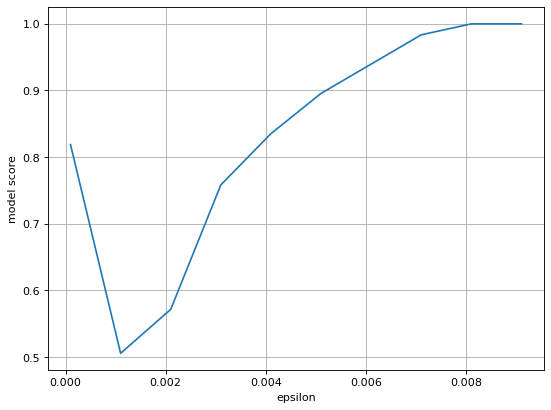

In [97]:
comp_id = 7
interval=5
time_to_skip=30
time_back=5
period_of_getting_data_to_test = 60
y_name='true_price'
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.arange(0.0001,0.01, 0.001)
scores=[]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max)
print(y.shape)
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, epsilon)
    score, precision, recall = test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, False, test_min_max)
    scores.append(score)
#BEFORE SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)

Epsilon =  0.0
Coefficient impact:
m   0.4042603412822057
a   -0.6364634909356713
x   0.49897685366281663
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[147   0]
 [ 43   0

(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[147   0]
 [ 43   0]]
Precision:
1.0
Recall:
0.7736842105263158

Epsilon =  0.04
Coefficient impact:
m   0.4042603412822057
a   -0.6364634909356713
x   0.49897685366281663
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[147   0]
 [ 43   0]]
Precision:
1.0
Recall:
0.7736842105263158

Epsilon =  0.042
Coefficient impact:
m   0.4042603412822057
a   -0.6364634909356713
x   0.49897685366281663
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[1

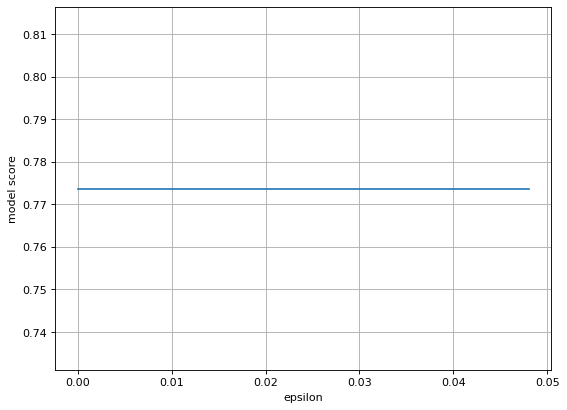

In [98]:
comp_id = 1
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max)
epsilons=np.arange(0.0,0.05, 0.002)
scores=[]
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    score, precision, recall = test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, True, test_min_max)
    scores.append(score)
#AFTER SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

# Find best threshold to predict

#### Testing max

In [99]:
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 30
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
thresholds=np.arange(1e-6,1e-5, 1e-6) #We define epsilons as percent of order of magnitude 
comp_thr=np.zeros((len(list_of_companies_number), len(thresholds)))

In [100]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    for threshold in range(thresholds.size):
        X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, thresholds[threshold])
        score, precision, recall = test_logistic_regr_classic(X, np.copy(y),split_percent, thresholds[threshold], True, test_min_max)
        comp_thr[comp_id,threshold]=score

0
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.32435044772415933
a   -0.5352819687972998
x   -0.09353787546627275
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 609
Number of negative class in training dataset = 151
Percent

29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3150838013015709
a   -0.6498809321325645
x   -0.10099399242670865
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 604
Number of negative class in training dataset = 156
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[135   0]
 [ 55   0]]
Precision:
1.0
Recall:
0.7105263157894737
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668

26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4066739362595256
a   -0.4573275631945669
x   0.2572213758890338
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 541
Number of negative class in training dataset = 219
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[137   0]
 [ 53   0]]
Precision:
1.0
Recall:
0.7210526315789474
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% 

21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7590533917341492
a   -0.2505703940807752
x   0.9016948204768347
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 571
Number of negative class in training dataset = 189
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[142   1]
 [ 47   0]]
Precision:
0.993006993006993
Recall:
0.7513227513227513
21.09375% of interval

30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2356377056068952
a   -0.8947366286937904
x   0.07638412565566467
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 581
Number of negative class in training dataset = 179
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[161   1]
 [ 28   0]]
Precision:
0.9938271604938271
Recall:
0.8518518518518519
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empt

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6296161215182774
a   0.15155101282997438
x   0.11828118970554091
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of corre

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6296161215182774
a   0.15155101282997438
x   0.11828118970554091
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of corre

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



Precision:
0.9856115107913669
Recall:
0.7287234042553191
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6296161215182774
a   0.15155101282997438
x   0.11828118970554091
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6077773048962922
a   0.1280328258308211
x   0.12407871137642192
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 566
Number of negative class in training dataset = 194
Percent of correc

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



Precision:
0.9856115107913669
Recall:
0.7287234042553191
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6147020809033421
a   0.15644377251126504
x   0.14349647368739563
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 565
Number of

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6147020809033421
a

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


   0.15644377251126504
x   0.14349647368739563
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 565
Number of negative class in training dataset = 195
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[137   2]
 [ 51   0]]
Precision:
0.9856115107913669
Recall:
0.7287234042553191
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
2

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6156081059347495
a   0.1602533422639814
x   0.09559942564445685
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 564
Number of negative class in training dataset = 196
Percent of correc

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.06217290702356225
a   0.01976131225810226
x   0.620620213700368
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 585
Number of negative clas

20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.06217290702356225
a   0.01976131225810226
x   0.620620213700368
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 585
Number of negative class in training dataset = 175
Percent of correct classification:
0.7368421052631579
Confusion matri

24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1867695482331763
a   -0.30942677859840484
x   0.13134056230216695
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 590
Number of negative class in training dataset = 170
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[140   0]
 [ 50   0]]
Precision:
1.0
Recall:
0.7368421052631579
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666

(950,)
Coefficient impact:
m   -0.25969959058257513
a   -0.056490623024009014
x   -0.07101815467466796
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 586
Number of negative class in training dataset = 174
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[146   0]
 [ 44   0]]
Precision:
1.0
Recall:
0.7684210526315789
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668%

21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.033545218051121393
a   -0.5038336464368202
x   -0.255452295306511
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct

25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2818104159736466
a   -0.37405213266562576
x   0.06752266677533726
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 597
Number of negative class in training dataset = 163
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[146   0]
 [ 44   0]]
Precision:
1.0
Recall:
0.7684210526315789
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty

Coefficient impact:
m   0.2818104159736466
a   -0.37405213266562576
x   0.06752266677533726
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 597
Number of negative class in training dataset = 163
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[146   0]
 [ 44   0]]
Precision:
1.0
Recall:
0.7684210526315789
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.781

13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1489611801914176
a   -0.24355177710550033
x   -0.22224166303962511
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 538
Number of negative c

23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.10958181185196647
a   -0.8543409121266367
x   0.2827817074733172
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 590
Number of negative class in training dataset = 170
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[140   1]
 [ 49   0]]
Precision:
0.9929078014184397
Recall:
0.7407407407407407
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals wer

24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8081957937205496
a   -0.6420805722771546
x   0.27241229827280516
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 561
Number of negative class in training dataset = 199
Percent of correct classification:
0.694736842105263

26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6367865464014058
a   0.25349350713494984
x   -0.021836850940994842
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 564
Number of negative class in training dataset = 196
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[147   0]
 [ 43   0]]
Precision:
1.0
Recall:
0.7736842105263158
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
2

17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.0283551708927657
a   -0.2678827096740564
x   0.08356366924476268
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 522
Number of negative class in training dataset = 238
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[146   0]
 [ 43   1]]
Precision:
1.0
Recall:
0.7724867724867724
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of i

17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.0280644901422047
a   -0.22278988709161943
x   0.1067613221884844
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 520
Number of negative class in training dataset = 240
Percent of corre

(950,)
Coefficient impact:
m   0.28469278932708963
a   -0.3499960015185342
x   0.4302906197075509
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 553
Number of negative class in training dataset = 207
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[135   0]
 [ 55   0]]
Precision:
1.0
Recall:
0.7105263157894737
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BU

23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6650119808474947
a   -0.3889919540424205
x   -0.2772126054982705
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 576
Number of negative clas

22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.21767410774537968
a   -0.2597587279441317
x   0.42977932043860784
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 581
Number of negative cl

18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.19157722999138285
a   -0.6496251861328203
x   0.3856908048892383
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 534
Number of negative class in training dataset = 226
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[135   0]
 [ 55   0]]
Precision:
1.0
Recall:
0.7105263157894737
18.177083333333332% of intervals were SELL empty
23.75%

Coefficient impact:
m   0.19625296728662858
a   -0.6441412025103732
x   0.4005107757553836
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 532
Number of negative class in training dataset = 228
Percent of correct classification:
0.6947368421052632
Confusion matrix:
[[132   0]
 [ 58   0]]
Precision:
1.0
Recall:
0.6947368421052632
19
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
22.5% of intervals were SE

22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.46513459073379676
a   -0.4210710646278575
x   0.5195343324559545
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 531
Number of negative class in training dataset = 229
Percent of correct classification:
0.7
Confusion matrix:
[[133   1]
 [ 56   0]]
Precision:
0.9925373134328358
Recall:
0.7037037037037037
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
22.5% of intervals we

23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1241330397077643
a   -0.12037358139485671
x   0.7714673677280744
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 561
Number of negative class in training dataset = 199
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[145   0]
 [ 45   0]]
Precision:
1.0
Recall:
0.7631578947368421
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of 

18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.39594402378554766
a   -0.5478985284815561
x   0.4902243389948514
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 571
Number of negative class in training dataset = 189
Percent of correct classification:
0.7157894736842105
Confu

32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3186096856104157
a   -0.08362572325257499
x   0.2131990335890116
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 582
Number of negative class in training dataset = 178
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[143   0]
 [ 47   0]]
Precision:
1.0
Recall:
0.7526315789473684
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals we

24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5654261574152711
a   0.21316933478806988
x   0.023529185969660353
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 560
Number of negative cl

26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.29570759316474127
a   -0.021784835587111705
x   0.7458181487089595
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 586
Number of negative class in training dataset = 174
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[135   0]
 [ 55   0]]
Precision:
1.0
Recall:
0.7105263157894737
25.104166666666668% of inte

26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3431112517176611
a   -0.009846162158147561
x   0.6986379068976735
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 578
Number of negative class in training dataset = 182
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[134   0]
 [ 56   0]]
Precision:
1.0
Recall:
0.7052631578947368
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of inter

24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.19868544758221302
a   0.20818231016787134
x   -0.4459190707598335
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 585
Number of negative class in training dataset = 175
Percent of correct classification:
0.6157894736842106
Confusion matrix:
[[116   4]
 [ 69   1]]
Precision:
0.96

18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.129905145425192
a   0.6305693781084899
x   1.2236339243948025
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[137   0]
 [ 53   0]]
Precision:
1

(950,)
Coefficient impact:
m   -0.042973370125704256
a   -0.3973201391839732
x   0.4256703443290351
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 607
Number of negative class in training dataset = 153
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Precision:
1.0
Recall:
0.7894736842105263
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of int

25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
23.333333333333332% of intervals were SELL empty
20.364583333333332% of intervals were BUY empty
23.333333333333332% of intervals were SELL empty
20.364583333333332% of intervals were BUY empty
25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.25422634512411596
a   -0.8293825796756049
x   -0.18841548390328114
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 590
Number of negative class in training dataset = 170
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[140   2]
 [ 47   1]]
Precision:
0.9859154929577465
Recall:
0.7486631016042781
23.333333333333332% of intervals were SELL empty
20.364583333333332% of intervals were BUY empty
23.3333333

25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.29070274664863544
a   -0.13496664579290796
x   1.006851285016165
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 603
Number of negative class in training dataset = 157
Percent of correct classification:
0.7789473684210526
Confus

(950,)
Coefficient impact:
m   0.335051055820271
a   -0.10727794207270455
x   0.9378674300125998
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 601
Number of negative class in training dataset = 159
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[147   0]
 [ 43   0]]
Precision:
1.0
Recall:
0.7736842105263158
30
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.8854166666

Coefficient impact:
m   -0.5225036461024546
a   -1.589558966471561
x   0.4355790571459872
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 570
Number of negative class in training dataset = 190
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[138   0]
 [ 52   0]]
Precision:
1.0
Recall:
0.7263157894736842
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of 

20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.24765381667799471
a   -0.4105491268033286
x   -0.15827159648397093
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 573
Number of negative class in training dataset = 187
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[140   0]
 [ 50   0]]
Precision:
1.0
Recall:
0.7368421052631579
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135

17.916666666666668% of intervals were SELL empty
32.447916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2664773983787973
a   0.09295242344861532
x   -0.14999479350335992
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 558
Number of negative class in training dataset = 202
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[135   0]
 [ 54   1]]
Precision:
1.0
Recall:
0.7142857142857143
17.447916666666668% of intervals were SELL empty
32.239583333333336% of intervals were BUY empty
17.447916666666668% of intervals were SELL empty
32.239583333333336% of intervals were BUY empty
17.916666666666668% of intervals were SELL empty
32.447916666666664% of intervals were BUY empty
17.916666666666668% of intervals were SELL empty
32.447916666666664% of intervals were BUY empty
17.447916666666668% of intervals were SELL empty
32.239583333333336% of intervals were BUY empty
17.447916666666668% of inte

16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1163371133556435
a   -0.7617120795970784
x   0.12422071586500127
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 547
Number of negative class in training dataset = 213
Percent of correct classifi

26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.47193799519638036
a   -0.18369142863968554
x   -0.9317117933112579
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 584
Number of negative class in training dataset = 176
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Precision:
1.0
Recall:
0.8
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY e

19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.47953514987419793
a   0.13543959220607307
x   1.299997318256735
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 536
Number of negative class in training dataset = 224
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[141   0]
 [ 49   0]]
Precision:
1.0
Recall:
0.7421052631578947
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% o

17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.44013434780411925
a   0.19029859766815363
x   1.2622240739857673
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 534
Number of negative class in training dataset = 226
Percent of correct classification:
0.7421052631578947
Confus

30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.25184861646460366
a   0.08068755144889425
x   0.43923780214459446
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6736842105263158
Confusion matrix:
[[128   0]
 [ 62   0]]
Precision:
1.0
Recall:
0.6736842105263158
20.208333333333332% of inte

18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.7274191804125999
a   0.09316965199044795
x   -0.496725531713744
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 576
Number of negative class in training dataset = 184
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[134   1]
 [ 55   0]]
Precision:
0.9925925925925926
Recall:
0.708994708994709
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
(950,)


<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.04381495837078237
a   -0.7884732017070365
x   0.08494443334177415
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 570
Number of negative class in training dataset = 190
Percent of correct classification:
0.7315789473684211
Confusion matrix:
[[139   0]
 [ 51   0]]
Precision:
1.0
Recall:
0.7315789473684211
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals we

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.027698832909218183
a   -0.788573013182723
x   0.09322463119425194
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative cla

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.027698832909218183
a   -0.788573013182723
x   0.09322463119425194
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative cla

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.027698832909218183
a   -0.788573013182723
x   0.09322463119425194
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative cla

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
(950,)
Coefficient impact:


<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


m   0.014010753109737165
a   -0.7492014446653842
x   0.07784980822589548
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[138   0]
 [ 52   0]]
Precision:
1.0
Recall:
0.7263157894736842
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.07

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
(950,)


<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.015034311907688128
a   -0.8418633546512371
x   0.012135366275588743
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[138   0]
 [ 52   0]]
Precision:
1.0
Recall:
0.7263157894736842
39
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of in

20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.09662511651630507
a   -0.28554824788453187
x   0.7105976165470913
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 560
Number of negative class in training dataset = 200
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[136   0]
 [ 54   0]]
Precis

Coefficient impact:
m   -0.16889233383612554
a   0.19919413297425695
x   -0.25808734495759006
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6947368421052632
Confusion matrix:
[[132   0]
 [ 58   0]]
Precision:
1.0
Recall:
0.6947368421052632
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.51041666666

17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.43200300671913433
a   0.042937705100652215
x   0.12968264812413594
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.6473684210526316
Confusion matrix:
[[123   0]
 [ 67   0]]
Precision:


Coefficient impact:
m   0.19429243886059977
a   -0.6698281508663049
x   0.06149452191964398
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 573
Number of negative class in training dataset = 187
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[149   0]
 [ 41   0]]
Precision:
1.0
Recall:
0.7842105263157895
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of interva

20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5039798798359452
a   -0.3095965946482448
x   0.4911343872252011
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 550
Number of negative class in training dataset = 210
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[135   3]
 [ 52   0]]
Precision:
0.9782608695652174
Recall:
0.7219251336898396
20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
25.83333333333

20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5602629834202164
a   -0.3558290043965105
x   0.5208247550353045
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 548
Number of negative class in training dataset = 212
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[135   3]
 [ 52   0]]
Precision:
0.9782608695652174
Recall:
0.7219251336898396
44
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SEL

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6578947368421

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6578947368421

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



Recall:
0.6578947368421053
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct cla

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6526315789473

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6526315789473

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6526315789473

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



Precision:
1.0
Recall:
0.6526315789473685
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6526315789473

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.26074493566424156
a   -0.7561068686233529
x   0.6377392230992063
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 586
Number of negative class in training dataset = 174
Percent of correct classification:
0.7263157894736842
Confusion matr

20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2797429552123567
a   -0.6803721328467036
x   0.5806873025591922
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[133   0]
 [ 56   1]]
Precision:
1.0
Recall:
0.7037037037037037
46
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty


(950,)
Coefficient impact:
m   0.2006401952051967
a   -0.9748619316811992
x   0.3120418702274405
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 566
Number of negative class in training dataset = 194
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[142   1]
 [ 47   0]]
Precision:
0.993006993006993
Recall:
0.7513227513227513
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL emp

18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.059176977658586274
a   -0.00910717217050716
x   -0.0016327622069578214
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 550
Number of negative class in training dataset = 210
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[135   0]
 [ 55   0]]
Precision:
1.0
Recall:
0.7105263157894737
17.604166666666668% of 

22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.22234247822828715
a   0.6171263419192825
x   -0.22763676827571017
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Precision:
1.0
Recall:
0.8
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833

Coefficient impact:
m   -0.22515164243884364
a   -0.7822984012756471
x   0.9010467940662094
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[140   0]
 [ 50   0]]
Precision:
1.0
Recall:
0.7368421052631579
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.281

16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.029866591829307922
a   0.04920114689953222
x   -0.6426143794198786
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 509
Number of negative class in training dataset = 251
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[134   0]
 [ 56   0]]
Precision:
1.0
R

30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.035255221410133104
a   0.07633727062675559
x   -0.6134336353867853
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 506
Number of negative class in training dataset = 254
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[134   0]
 [ 56   0]]
Precision:
1.0
Recall:
0.7052631578947368
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.38541666

24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.05673150982078443
a   -0.9364326294628934
x   -0.21876246389889492
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[136   0]
 [ 54   0]]
Precision:
1.0
Recall:
0.7157894736842105
22.916666666666668% of intervals were SELL empty
22.291666666666668% of

28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.687773079143757
a   -0.3895287753695886
x   0.3138078974270302
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 573
Number of negative class in training dataset = 187
Percent of correct classification:
0.6842105263157895
Confusion matrix:
[[130   0]
 [ 60   0]]
Precision:
1.0
Recall:
0.6842105263157895
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of

21.979166666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06517289396386804
a   -0.008397556649227042
x   0.08053618613092131
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 549
Number of negative class in training dataset = 211
Percent of correct classification:
0.7157894736842105
Confusion m

(950,)
Coefficient impact:
m   -0.2135980185026264
a   -0.22016975120199517
x   0.38685144668322846
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 559
Number of negative class in training dataset = 201
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[144   0]
 [ 46   0]]
Precision:
1.0
Recall:
0.7578947368421053
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.0

22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.9311284075700753
a   -0.598658035977902
x   0.5587443313246494
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[137   3]
 [ 47   3]]
Precision:
0.9785714285714285
Recall:
0.7445652173913043
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
43.177083333333336% of intervals we

(950,)
Coefficient impact:
m   -0.9431167942671712
a   -0.6213583778896413
x   0.5704722452581092
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[135   5]
 [ 47   3]]
Precision:
0.9642857142857143
Recall:
0.7417582417582418
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
43.177083333333336% of intervals w

38.229166666666664% of intervals were SELL empty
40.15625% of intervals were BUY empty
38.229166666666664% of intervals were SELL empty
40.15625% of intervals were BUY empty
15.78125% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
15.78125% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
38.229166666666664% of intervals were SELL empty
40.15625% of intervals were BUY empty
38.229166666666664% of intervals were SELL empty
40.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.0702620418934877
a   0.06730984225211024
x   0.695564081665361
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 562
Number of negative class in training dataset = 198
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[145   2]
 [ 43   0]]
Precision:
0.9863945578231292
Recall:
0.7712765957446809
15.78125% of intervals were SELL empty
24.427083333333332% of intervals wer

24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.11439571519505214
a   0.5117540761792178
x   -0.46005586351219524
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 582
Number of negative class in training dataset = 178
Percent of correct classification:
0.8052631578947368


Coefficient impact:
m   0.4158598164081261
a   0.12042651060308725
x   0.7492204632702786
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 584
Number of negative class in training dataset = 176
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[135   0]
 [ 55   0]]
Precision:
1.0
Recall:
0.7105263157894737
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.562

31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.365884009239175
a   0.380964011602896
x   0.8964473209365753
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Precision:
1.0
Recall:
0.7789473684210526
19.010416666666668% of intervals were SELL empty
22.083333333333332% of 

44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.39608833112029757
a   0.001375927075375402
x   0.28090544926796196
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 603
Number of negative class in training dataset = 157
Percent of correct classification:
0.631578947368421
Confusion matrix:
[[120   1]
 [ 69   0]]
Precision:
0.9917355371900827
Recall:
0.6349206349206349
22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
22.5520833333

44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.35433582643838607
a   0.019073816043317027
x   0.2965181422466165
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 600
Number of negative class in training dataset = 160
Percent of correct classification:
0.6263157894736842
Confusion matrix:
[[119   1]
 [ 70   0]]
Precision:
0.9916666666666667
Recall:
0.6296296296296297
22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
22.5520833333

21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.7964128814995803
a   -0.7259909916315225
x   0.8317625253027656
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[140   0]
 [ 50   0]]
Precision:
1.0
Recall:
0.7368421052631579
21.19791666666666

39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6166106655138923
a   -1.1830413580423988
x   -0.0037206451462003
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 539
Number of negative class in training dataset = 221
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[140   0]
 [ 50   0]]
Precision:
1.0
Recall:
0.7368421052631579
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.8229166666666

17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.0243651132699855
a   -0.258540929991188
x   0.8326690855638345
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 560
Number of negative class 

12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.13669254259313998
a   -0.675933013371007
x   0.7404617197079238
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 557
Number of negative class in training dataset = 203
Percent of correct classification:
0.6947368421052632
Confusion matrix:
[[132   1]
 [ 57   0]]
Precision:
0.9924812030075187
Recall:
0.6984126984126984
12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of intervals were BUY

23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.4340324514602145
a   -0.538306022693173
x   0.5906888252734172
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 584
Number of negative class in training dataset = 176
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[135   0]
 [ 55   0]]
Precisio

30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.486873937018707
a   -0.5305336033824408
x   0.6176383912522857
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[135   0]
 [ 55   0]]
Precision:
1.0
Recall:
0.7105263157894737
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of in

36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.22615498729951772
a   0.14691117243881588
x   0.13997916151565096
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 581
Number of negative class in training dataset = 179
Percent of correct classification:
0.8052631578947368
Confusion matrix:
[[153   0]
 [ 37   0]]
Precision:
1.0
Recall:
0.8052631578947368
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
3

Number of negative class in training dataset = 190
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[143   0]
 [ 47   0]]
Precision:
1.0
Recall:
0.7526315789473684
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.08311118537728086
a   -0.35476058596061466


29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.29994153982601734
a   -1.0358084406843324
x   0.5732416498776728
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 559
Number of negative class in training dataset = 201
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[143   0]
 [ 47   0]]
Precision:
1.0
Recall:
0.7526315789473684
22.760416666666668% of intervals were SELL empty
19.322916666666668%

21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6572709161619793
a   -0.46225830927224015
x   -0.37677975330057834
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 559
Number of negative class in training dataset = 201
Percent of correct classification:
0.6631578947368421
Confusion matrix:
[[126   3]
 [ 61   0]]
Precision:
0.9767441860465116
Recall:
0.6737967914438503
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
15.833333333333334% of intervals were SELL

20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.35587220984378154
a   -0.760033023815127
x   -0.09973648241321915
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[143   1]
 [ 46   0]]
Precision:
0.9930555555555556
Recall:
0.7566137566137566
2

20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.35587220984378154
a   -0.760033023815127
x   -0.09973648241321915
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.7526315789473684
Confusion ma

Coefficient impact:
m   -1.250243428732826
a   0.04879403772117838
x   0.44728862172556866
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 586
Number of negative class in training dataset = 174
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[138   0]
 [ 52   0]]
Precision:
1.0
Recall:
0.7263157894736842
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% 

20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.09182757220416755
a   -0.6997605495338283
x   0.38190592492926223
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 575
Number of negative class in training dataset = 185
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[140   0]
 [ 50   0]]
Precision:
1.0
Recall:
0.7368421052631579
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.17708

24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.0030981552284918184
a   -0.6377419426732137
x   0.28192418169899364
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[149   0]
 [ 41   0]]
Precision:
1.0
Reca

Coefficient impact:
m   0.33712671797504035
a   -0.2498281718652127
x   -0.13233227536027203
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 580
Number of negative class in training dataset = 180
Percent of correct classification:
0.6684210526315789
Confusion matrix:
[[127   0]
 [ 63   0]]
Precision:
1.0
Recall:
0.6684210526315789
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.0312

40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6232262923006462
a   -0.05320679865732517
x   -0.7355898637792188
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Precision:
1.0
Recall:
0.7789473684210526
24.322916666666668% of intervals were SELL empty
1

40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6232262923006462
a   -0.05320679865732517
x   -0.7355898637792188
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Precision:
1.0
Recall:
0.7789473684210526
76
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.8020833333333

24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.9768047601261342
a   -0.28847126576703536
x   1.1099647879883725
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 578
Number of negative class in training dataset = 182
Percent of correct classification:
0.6894736842105263
Confusion matrix:
[[131   0]
 [ 59   0]]
Pre

(950,)
Coefficient impact:
m   0.813302368350457
a   0.08505143969654816
x   0.7424536220106064
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 546
Number of negative class in training dataset = 214
Percent of correct classification:
0.6894736842105263
Confusion matrix:
[[131   0]
 [ 59   0]]
Precision:
1.0
Recall:
0.6894736842105263
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3

26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4455642251901032
a   0.05255907527291124
x   -0.345536853480965
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 564
Number of negative class in training dataset = 196
Percent of corre

23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.0787361290659563
a   0.08443508533359995
x   0.35845534490293113
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 586
Number of negative class in training dataset = 174
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[136   0]
 [ 54   0]]
Precision:
1.0
Recall:
0.7157894736842105
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of interv

Coefficient impact:
m   0.8394473058743064
a   -0.9447032152709276
x   0.7545671151026275
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 577
Number of negative class in training dataset = 183
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[142   1]
 [ 46   1]]
Precision:
0.993006993006993
Recall:
0.7553191489361702
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
28.229166666666668% of 

Coefficient impact:
m   0.8880145749095453
a   -0.9239077059627463
x   0.7473594897046771
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 574
Number of negative class in training dataset = 186
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[141   1]
 [ 47   1]]
Precision:
0.9929577464788732
Recall:
0.75
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
28.229166666666668% of intervals wer

24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   1.0137013065243599
a   0.5963866077518907
x   0.11591600972251201
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 558
Number of negative class in training dataset = 202
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[139   7]
 [ 42   2]]
Precision:
0.952054794520548
Recall:
0.7679558011049724
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were

Coefficient impact:
m   -0.4958397652982349
a   0.26830232313420355
x   -0.5698164837196851
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 553
Number of negative class in training dataset = 207
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[137   0]
 [ 53   0]]
Precision:
1.0
Recall:
0.7210526315789474
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals we

20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1993374911902678
a   0.040871255223655284
x   -0.15581574679505975
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 582
Number of negative class in training dataset = 178
Percent of correct classification:
0.6789473684210526
Confusion matrix:
[[129   0]
 [ 61   0]]
Precision:
1.0
Recall:
0.6789473684210526
20.9375% of intervals were SELL empty
24.58333333333333

21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3339785185420652
a   -0.6118435144756463
x   0.37606012899443625
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 580
Number of negative class in training dataset = 180
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[136   0]
 [ 54   0]]
Precisi

Coefficient impact:
m   -0.4990201276918273
a   -0.2624296843313418
x   -0.17731915206868712
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 564
Number of negative class in training dataset = 196
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[138   0]
 [ 52   0]]
Precision:
1.0
Recall:
0.7263157894736842
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of in

21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5538153358667532
a   -0.37478640552212866
x   -0.13359053723640124
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 560
Number of negative class in training dataset = 200
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[138   0]
 [ 52   0]]
Precision:
1.0
Recall:
0.7263157894736842
86
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332

Coefficient impact:
m   0.4444241126245446
a   -0.7269785256774877
x   -0.15221361388853966
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 565
Number of negative class in training dataset = 195
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[144   0]
 [ 46   0]]
Precision:
1.0
Recall:
0.7578947368421053
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals we

39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.03770024212701144
a   0.015437468731436577
x   -0.5009713515044641
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 587
Number of negative class in training dataset = 173
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[161   0]
 [ 29   0]]
Precision:
1.0
Recall:
0.8473684210526315
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333

24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.25391479771000525
a   0.01734019187015966
x   0.7803926443978423
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 577
Number of negative class in training dataset = 183
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[142   0]
 [ 48   0]]
Precision:
1.0
Recall:
0.7473684210526316
22.864583333333332% of intervals were SELL empty


(950,)
Coefficient impact:
m   0.09262694914935768
a   -0.14414968194850997
x   0.45383793769644754
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 580
Number of negative class in training dataset = 180
Percent of correct classification:
0.6789473684210526
Confusion matrix:
[[129   0]
 [ 61   0]]
Precision:
1.0
Recall:
0.6789473684210526
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of inte

20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.35202497576883085
a   -0.0840846575390176
x   0.07269113973327251
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[142   0]
 [ 48   0]]
Precision:
1.0
Recall:
0.7473684210526316
19.166666666666668% of intervals were SELL empty
26.666666666666668

Coefficient impact:
m   -0.2983246614145798
a   -0.019072904771522358
x   0.13231599158939794
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 566
Number of negative class in training dataset = 194
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[141   0]
 [ 49   0]]
Precision:
1.0
Recall:
0.7421052631578947
91
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of interva

25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.08776031897058591
a   -0.22855795945454058
x   -0.0020918726292648124
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 606
Number of negative class in training dataset = 154
Percent of correct classification:
0.7157894736842105
Confusion 

16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.022236367935869857
a   -0.27727368553284615
x   0.005107841988663792
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 581
Number of negative class in training dataset = 179
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[137   0]
 [ 53   0]]
Precision:
1

20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5307831963041509
a   -0.23791306523024924
x   0.49337054646122874
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 574
Number of negative class in training dataset = 186
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[146   0]
 [ 44   0]]
Precision:
1.0
Recall:
0.7684210526

Coefficient impact:
m   -0.29570965011391054
a   -0.4835432799892504
x   -0.03264430923328236
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[123   5]
 [ 61   1]]
Precision:
0.9609375
Recall:
0.6684782608695652
21.197916666666668% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
23.645833333333332% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.645833333333332% of intervals were SELL empty
31.5625% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
23.645833333333332% of intervals were SELL empty


19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6967524146717547
a   0.48058697253662847
x   -0.5819348882412898
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 586
Number of negative class in training dataset = 174
Percent of correct classification:
0.7052631578947368
Co

19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.12727550221059408
a   -0.24755346830736563
x   -0.5505469202165199
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 588
Number of negative class in training dataset = 172
Percent of correct classification:
0.6736842105263158
Confusion matrix:
[[128   0]
 [ 62   0]]
Precision:
1.0
Recall:
0.6736842105263158
19.114583333333332% of intervals were SELL empty
25.3125% o

26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3905310864030682
a   -0.38582619993797407
x   -0.3341808550418388
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 589
Number of negative class in training dataset = 171
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Precision:
1.0
Recall:
0.7894736842105263
26.979166666666668%

30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.33650560844526173
a   -0.3760013465256452
x   -0.33453487739349136
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 587
Number of negative class in training dataset = 173
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[149   0]
 [ 41   0]]
Precision:
1.0
Recall:
0.7842105263157895
98
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333

(950,)
Coefficient impact:
m   0.1346340537712654
a   -0.3229378092717436
x   -0.09234455637070682
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 573
Number of negative class in training dataset = 187
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[141   0]
 [ 49   0]]
Precision:
1.0
Recall:
0.7421052631578947
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666

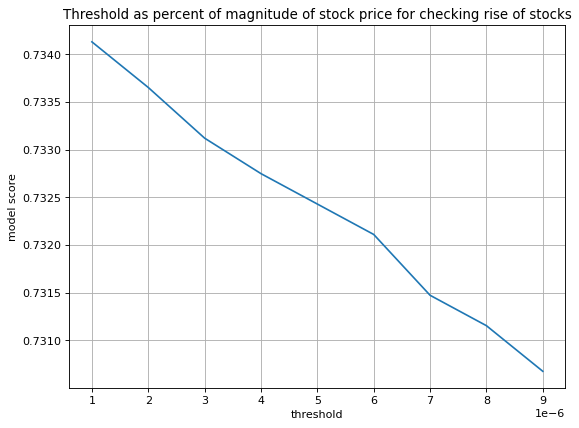

In [101]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='threshold', ylabel='model score')
plt.title("Threshold as percent of magnitude of stock price for checking rise of stocks")
plt.grid()

plt.plot(thresholds,np.sum(comp_thr, axis=0)/99)   ###NAJLEPIEJ DZIAŁA dla eps=0 ?????? ofc przy tych konkretnych parametrach interval, timeback itd

#### Testing min

In [102]:
test_min_max = 'min'
thresholds=np.arange(1e-6,1e-5, 1e-6) #We define epsilons as percent of order of magnitude 
comp_thr=np.zeros((len(list_of_companies_number), len(thresholds)))
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    for threshold in range(thresholds.size):
        X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, thresholds[threshold])
        score, precision, recall = test_logistic_regr_classic(X, np.copy(y),split_percent, thresholds[threshold], True, test_min_max)
        comp_thr[comp_id,threshold]=score

0
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)


NameError: name 'epslon' is not defined

In [ ]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.title("Epsilon as percent of magnitude of stock price for checking fall in price of stocks")
plt.grid()

plt.plot(epsilons,np.sum(comp_eps, axis=0)/99)   ###NAJLEPIEJ DZIAŁA dla eps=0 ?????? ofc przy tych konkretnych parametrach interval, timeback itd

### Find best (interesting in research life) threshold

In [ ]:
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
thresholds = np.geomspace(1e-3, 1e-9, num = 7)
print(thresholds)
comp_thr=np.zeros((len(list_of_companies_number), len(thresholds)))

In [ ]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    for threshold in range(thresholds.size):
        X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, thresholds[threshold])
        score, precision, recall = test_logistic_regr_classic(X, np.copy(y),split_percent, thresholds[threshold], True, test_min_max)
        comp_thr[comp_id,threshold]=score
    

### Find best (interesting in real life) threshold

# check most important features 

In [104]:
for k,v in param_dict_logreg.items():
    print(k, np.sum(np.abs(v))/len(v))

NameError: name 'param_dict' is not defined

# try with different features

In [201]:
comp_id = 90
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.005
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names:
    names_dict[name]=[]

19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
Coefficient impact:
vwaps_buy   0.3550900085287161
vwaps_sell   0.19469958067881107
s2f_impact_buy   -0.04356744572719117
s2f_impact_sell   -0.0303910537237413
trading_volumes   0.028406975611134255
price_volatilities   0.10852520446209332
vwaps_order_sizes_buy   

20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
Coefficient impact:
vwaps_order_sizes_sell   0.22544260499859983
s2f_order_sizes_buy   0.060729884097398504
s2f_order_sizes_sell   -0.3643867592098314
next_trade_time   -0.2469568484833608
next_trade_size   -0.13884100782037956
next_trade_price   -0.35535885650700305
order_inbalance   -0.11932073751611014
vwaps_buy   0.3471924095244914
vwaps_sell   0.1579345551804775
s2f_impact_buy   -0.07414470359747985
s2f_impact_sell   0.042537755497634944
trading_vol

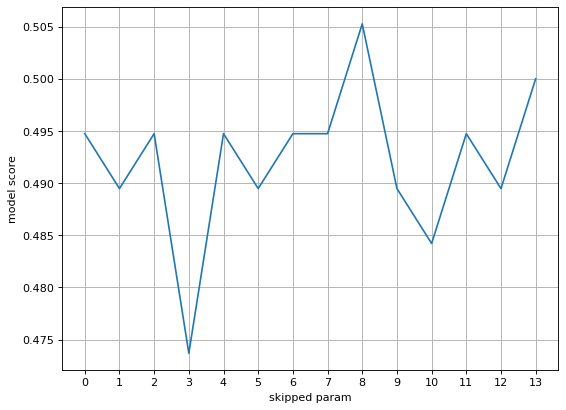

In [202]:

scores=[]
skipped_params=[]
names_len=len(names)
for i in range(names_len):
    name=names.pop(0)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    scores.append(test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, True, local_names=names))
    names.append(name)
    skipped_params.append(name)
    print('\nskipped ', name)
    #AFTER SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(ticks=np.arange(len(skipped_params)))
plt.grid()
plt.plot(scores)

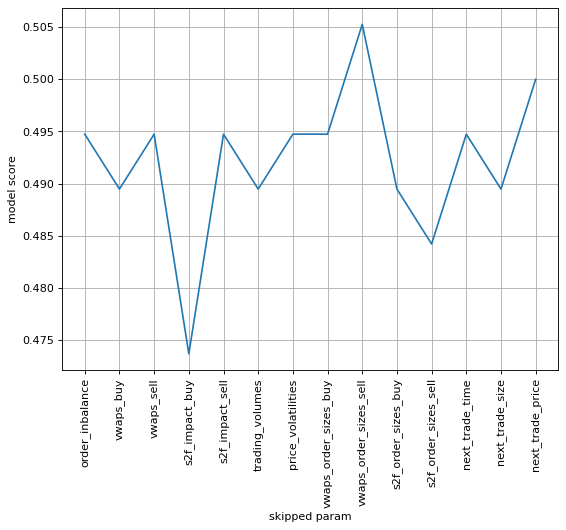

In [203]:
### FEATURE DROPPED ON X AXIS
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='vertical')
plt.grid()
plt.plot(scores)

# Decision trees classification

In [96]:
def test_decision_trees_classic(X, y, split_percent, epsilon, 
                               use_scaling=False, 
                               test_min_max = 'max'):
    if test_min_max == 'max':
        y=np.vectorize(test_high)(y,epsilon*y[0])#currently we hold price change in y
    elif test_min_max == 'min':
        y=np.vectorize(test_down)(y,epsilon*y[0])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier(random_state=0)).fit(X[:split], y[:split])
    else:
        clf = DecisionTreeClassifier(random_state=0).fit(X[:split], y[:split])
    y_predicted=clf.predict(X[split:])
    print("Number of positive class in training dataset =", np.sum(y[:split]==1))
    print("Number of negative class in training dataset =", np.sum(y[:split]==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y[split:])/len(y_predicted))
    print("Confusion matrix:")
    print(confusion_matrix(y[split:], y_predicted))
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty

Epsilon =  0.0
Number of positive class in training dataset = 155
Number of negative class in training dataset = 605
Percent of correct classification:
0.6473684210526316
Confusion matrix:
[[115  32]
 [ 35   8]]

Epsilon =  0.001
Number of positive class in training dataset = 155
Number of negative class in training dataset = 605
Percent of correct classifi

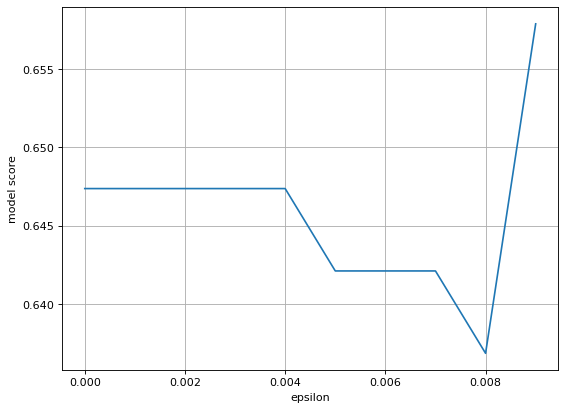

In [136]:
comp_id = 1
interval=5
time_to_skip=30
time_back=1
period_of_getting_data_to_test = 30
y_name='true_price'
test_min_max = 'min'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.arange(0.0,0.01, 0.001)
scores=[]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max)
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    scores.append(test_decision_trees_classic(X, np.copy(y),split_percent, epsilon, False, test_min_max))
#BEFORE SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

In [143]:
xd = np.arange(3)
xdd = np.arange(3)
print(np.concatenate((xd, xdd)))

[0 1 2 0 1 2]


In [147]:
xd

array([0, 1, 2])

In [148]:
np.concatenate((xd[:0], xd[1:]))

array([1, 2])

### Try cross validation

In [111]:
def cross_validation(X, y, model, num_of_day = 10, use_scaling = True):
    num_of_samples_in_day = X.shape[0]//num_of_day
    plot_indicators = np.zeros(shape = (10, 3))
    for day in range(num_of_day):
        try:
            X_train = np.concatenate((X[:day*num_of_samples_in_day], X[(day+1)*num_of_samples_in_day:]))
            y_train = np.concatenate((y[:day*num_of_samples_in_day], y[(day+1)*num_of_samples_in_day:]))
            X_test = X[day*num_of_samples_in_day:(day+1)*num_of_samples_in_day]
            y_test = y[day*num_of_samples_in_day:(day+1)*num_of_samples_in_day]
            if model == 'log_reg':
                score, precision, recall = test_logistic_regr_classic_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling, local_names=names,track_params=False)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
            elif model == 'xgb':
                score, precision, recall = test_xgb_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
        except ValueError as err:
            plot_indicators[day][0] = math.nan
            plot_indicators[day][1] = math.nan
            plot_indicators[day][2] = math.nan
            print(err)
    return plot_indicators

In [ ]:
comp_id = 1
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 180
test_min_max = 'max'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold_plots = []
thresholds = np.geomspace(1e-2, 1e-9, num = 8)
for threshold in range(thresholds.size):
        print("Threshold = ", thresholds[threshold])
        X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, thresholds[threshold])
        threshold_plots.append(cross_validation(X, y, 'log_reg'))

In [ ]:
#figure(figsize=(8, 6), dpi=80)
counter = 0
for threshold in thresholds:
    plt.title("Plot of Score, precision and recall given threshold: {}".format(threshold))
    plt.axes(xlabel='Days', ylabel='Value_of_parameters')
    #plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
    plt.grid()
    for i in range(3):
        plt.plot(threshold_plots[counter][:,i])
    plt.legend(["Score", "Precision", "Recall"])
    plt.show()
    counter +=1

In [ ]:
threshold_plots[3]

In [ ]:
threshold_plots[4]

# XGBOOST

In [98]:
def test_xgb_cross_val(X_train, y_train, X_test, y_test, use_scaling=True):
    neg_class_count = np.sum(y_train==0)
    pos_class_count = np.sum(y_train==1)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), xgb.XGBClassifier(max_depth=3, scale_pos_weight=neg_class_count/pos_class_count)).fit(X_train, y_train)
    else:
        clf = xgb.XGBClassifier().fit(X_train, y_train)
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [99]:
comp_id = 1
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 180
test_min_max = 'max'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold_plots = []
thresholds = np.geomspace(1e-2, 1e-9, num = 8)
for threshold in range(thresholds.size):
        print("Threshold = ", thresholds[threshold])
        X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, thresholds[threshold])
        threshold_plots.append(cross_validation(X, y, 'xgb'))

Threshold =  0.01
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
[15:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 68
Number of negative class in training dataset = 787
Number of positive class in testing dataset = 27
Number of negative class in testing dataset = 68
Percent of correct classification:
0.6736842105263158
Confusion matrix:
[[ 2 25]
 [ 6 62]]
Precision:
0.07407407407407407
Recall:
0.25
[15:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 93
Number of negative class in training dataset = 762
Number of positive class in testing dataset = 2
Number of negative class in testing dataset = 93
Percent of correct classification:
0.8947368421052632
Confusion matrix:
[[ 0  2]
 [ 8 85]]
Precision:
0.0
Recall:
0.0
[15:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 79
Number of negative class in training dataset = 776
Number of positive class in testing dataset = 16
Number of negative class in testing dataset = 79
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[ 0 16]
 [ 4 75]]
Precision:
0.0
Recall:
0.0
[15:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 95
Number of negative class in training dataset = 760
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 95
Percent of correct classification:
0.8842105263157894
Confusion matrix:
[[ 0  0]
 [11 84]]
[15:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 64
Number of negative class in training dataset = 791
Number of positive class in testing dataset = 31
Number of negative class in testing dataset = 64
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[ 4 27]
 [ 0 64]]
Precision:
0.12903225806451613
Recall:
1.0
[15:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 95
Number of negative class in training dataset = 760
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 95
Percent of correct classification:
0.9052631578947369
Confusion matrix:
[[ 0  0]
 [ 9 86]]
[15:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 95
Number of negative class in training dataset = 760
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 95
Percent of correct classification:
1.0
Confusion matrix:
[[ 0  0]
 [ 0 95]]
[15:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 87
Number of negative class in training dataset = 768
Number of positive class in testing dataset = 8
Number of negative class in testing dataset = 87
Percent of correct classification:
0.8736842105263158
Confusion matrix:
[[ 0  8]
 [ 4 83]]
Precision:
0.0
Recall:
0.0
[15:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 84
Number of negative class in training dataset = 771
Number of positive class in testing dataset = 11
Number of negative class in testing dataset = 84
Percent of correct classification:
0.8210526315789474
Confusion matrix:
[[ 0 11]
 [ 6 78]]
Precision:
0.0
Recall:
0.0
[15:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 95
Number of negative class in training dataset = 760
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 95
Percent of correct classification:
0.8842105263157894
Confusion matrix:
[[ 0  0]
 [11 84]]
Threshold =  0.001
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 635
Number of negative class in training dataset = 220
Number of positive class in testing dataset = 73
Number of negative class in testing dataset = 22
Percent of correct classification:
0.631578947368421
Confusion matrix:
[[48 25]
 [10 12]]
Precision:
0.6575342465753424
Recall:
0.8275862068965517
[15:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 632
Number of negative class in training dataset = 223
Number of positive class in testing dataset = 76
Number of negative class in testing dataset = 19
Percent of correct classification:
0.5263157894736842
Confusion matrix:
[[42 34]
 [11  8]]
Precision:
0.5526315789473685
Recall:
0.7924528301886793
[15:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 639
Number of negative class in training dataset = 216
Number of positive class in testing dataset = 69
Number of negative class in testing dataset = 26
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[62  7]
 [21  5]]
Precision:
0.8985507246376812
Recall:
0.7469879518072289
[15:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 637
Number of negative class in training dataset = 218
Number of positive class in testing dataset = 71
Number of negative class in testing dataset = 24
Percent of correct classification:
0.6736842105263158
Confusion matrix:
[[57 14]
 [17  7]]
Precision:
0.8028169014084507
Recall:
0.7702702702702703
[15:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 630
Number of negative class in training dataset = 225
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.4842105263157895
Confusion matrix:
[[34 44]
 [ 5 12]]
Precision:
0.4358974358974359
Recall:
0.8717948717948718
[15:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 651
Number of negative class in training dataset = 204
Number of positive class in testing dataset = 57
Number of negative class in testing dataset = 38
Percent of correct classification:
0.5684210526315789
Confusion matrix:
[[46 11]
 [30  8]]
Precision:
0.8070175438596491
Recall:
0.6052631578947368
[15:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 636
Number of negative class in training dataset = 219
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.47368421052631576
Confusion matrix:
[[36 36]
 [14  9]]
Precision:
0.5
Recall:
0.72
[15:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 640
Number of negative class in training dataset = 215
Number of positive class in testing dataset = 68
Number of negative class in testing dataset = 27
Percent of correct classification:
0.631578947368421
Confusion matrix:
[[51 17]
 [18  9]]
Precision:
0.75
Recall:
0.7391304347826086
[15:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 645
Number of negative class in training dataset = 210
Number of positive class in testing dataset = 63
Number of negative class in testing dataset = 32
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[56  7]
 [26  6]]
Precision:
0.8888888888888888
Recall:
0.6829268292682927
[15:32:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 627
Number of negative class in training dataset = 228
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6736842105263158
Confusion matrix:
[[59 22]
 [ 9  5]]
Precision:
0.7283950617283951
Recall:
0.8676470588235294
Threshold =  0.0001
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BU

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 719
Number of negative class in training dataset = 136
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 13
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[70 12]
 [ 8  5]]
Precision:
0.8536585365853658
Recall:
0.8974358974358975
[15:32:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 720
Number of negative class in training dataset = 135
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[53 28]
 [ 9  5]]
Precision:
0.654320987654321
Recall:
0.8548387096774194
[15:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 722
Number of negative class in training dataset = 133
Number of positive class in testing dataset = 79
Number of negative class in testing dataset = 16
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[74  5]
 [13  3]]
Precision:
0.9367088607594937
Recall:
0.8505747126436781
[15:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 722
Number of negative class in training dataset = 133
Number of positive class in testing dataset = 79
Number of negative class in testing dataset = 16
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[71  8]
 [13  3]]
Precision:
0.8987341772151899
Recall:
0.8452380952380952
[15:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 716
Number of negative class in training dataset = 139
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[52 33]
 [ 4  6]]
Precision:
0.611764705882353
Recall:
0.9285714285714286
[15:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 726
Number of negative class in training dataset = 129
Number of positive class in testing dataset = 75
Number of negative class in testing dataset = 20
Percent of correct classification:
0.6842105263157895
Confusion matrix:
[[63 12]
 [18  2]]
Precision:
0.84
Recall:
0.7777777777777778
[15:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 716
Number of negative class in training dataset = 139
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6
Confusion matrix:
[[56 29]
 [ 9  1]]
Precision:
0.6588235294117647
Recall:
0.8615384615384616
[15:32:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[64 14]
 [11  6]]
Precision:
0.8205128205128205
Recall:
0.8533333333333334
[15:32:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 730
Number of negative class in training dataset = 125
Number of positive class in testing dataset = 71
Number of negative class in testing dataset = 24
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[67  4]
 [20  4]]
Precision:
0.9436619718309859
Recall:
0.7701149425287356
[15:32:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 715
Number of negative class in training dataset = 140
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[72 14]
 [ 6  3]]
Precision:
0.8372093023255814
Recall:
0.9230769230769231
Threshold =  1e-05
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY 

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 727
Number of negative class in training dataset = 128
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 13
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[67 15]
 [ 7  6]]
Precision:
0.8170731707317073
Recall:
0.9054054054054054
[15:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 728
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[58 23]
 [10  4]]
Precision:
0.7160493827160493
Recall:
0.8529411764705882
[15:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[76  4]
 [12  3]]
Precision:
0.95
Recall:
0.8636363636363636
[15:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[70 10]
 [12  3]]
Precision:
0.875
Recall:
0.8536585365853658
[15:32:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 721
Number of negative class in training dataset = 134
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 7
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[52 36]
 [ 3  4]]
Precision:
0.5909090909090909
Recall:
0.9454545454545454
[15:32:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 732
Number of negative class in training dataset = 123
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 18
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[65 12]
 [16  2]]
Precision:
0.8441558441558441
Recall:
0.8024691358024691
[15:32:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 724
Number of negative class in training dataset = 131
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[56 29]
 [ 8  2]]
Precision:
0.6588235294117647
Recall:
0.875
[15:32:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 731
Number of negative class in training dataset = 124
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[63 15]
 [11  6]]
Precision:
0.8076923076923077
Recall:
0.8513513513513513
[15:32:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[68  4]
 [19  4]]
Precision:
0.9444444444444444
Recall:
0.7816091954022989
[15:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[77  9]
 [ 5  4]]
Precision:
0.8953488372093024
Recall:
0.9390243902439024
Threshold =  1e-06
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY 

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 727
Number of negative class in training dataset = 128
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 13
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[67 15]
 [ 7  6]]
Precision:
0.8170731707317073
Recall:
0.9054054054054054
[15:32:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 728
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[58 23]
 [10  4]]
Precision:
0.7160493827160493
Recall:
0.8529411764705882
[15:32:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[76  4]
 [12  3]]
Precision:
0.95
Recall:
0.8636363636363636
[15:32:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[70 10]
 [12  3]]
Precision:
0.875
Recall:
0.8536585365853658
[15:32:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 721
Number of negative class in training dataset = 134
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 7
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[52 36]
 [ 3  4]]
Precision:
0.5909090909090909
Recall:
0.9454545454545454
[15:32:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 732
Number of negative class in training dataset = 123
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 18
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[65 12]
 [16  2]]
Precision:
0.8441558441558441
Recall:
0.8024691358024691
[15:32:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 724
Number of negative class in training dataset = 131
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[56 29]
 [ 8  2]]
Precision:
0.6588235294117647
Recall:
0.875
[15:32:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 731
Number of negative class in training dataset = 124
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[63 15]
 [11  6]]
Precision:
0.8076923076923077
Recall:
0.8513513513513513
[15:32:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[68  4]
 [19  4]]
Precision:
0.9444444444444444
Recall:
0.7816091954022989
[15:32:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[77  9]
 [ 5  4]]
Precision:
0.8953488372093024
Recall:
0.9390243902439024
Threshold =  1e-07
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY 

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 727
Number of negative class in training dataset = 128
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 13
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[67 15]
 [ 7  6]]
Precision:
0.8170731707317073
Recall:
0.9054054054054054
[15:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 728
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[58 23]
 [10  4]]
Precision:
0.7160493827160493
Recall:
0.8529411764705882
[15:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[76  4]
 [12  3]]
Precision:
0.95
Recall:
0.8636363636363636
[15:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[70 10]
 [12  3]]
Precision:
0.875
Recall:
0.8536585365853658
[15:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 721
Number of negative class in training dataset = 134
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 7
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[52 36]
 [ 3  4]]
Precision:
0.5909090909090909
Recall:
0.9454545454545454
[15:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 732
Number of negative class in training dataset = 123
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 18
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[65 12]
 [16  2]]
Precision:
0.8441558441558441
Recall:
0.8024691358024691
[15:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 724
Number of negative class in training dataset = 131
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[56 29]
 [ 8  2]]
Precision:
0.6588235294117647
Recall:
0.875
[15:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 731
Number of negative class in training dataset = 124
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[63 15]
 [11  6]]
Precision:
0.8076923076923077
Recall:
0.8513513513513513
[15:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[68  4]
 [19  4]]
Precision:
0.9444444444444444
Recall:
0.7816091954022989
[15:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[77  9]
 [ 5  4]]
Precision:
0.8953488372093024
Recall:
0.9390243902439024
Threshold =  1e-08
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY 

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 727
Number of negative class in training dataset = 128
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 13
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[67 15]
 [ 7  6]]
Precision:
0.8170731707317073
Recall:
0.9054054054054054
[15:33:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 728
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[58 23]
 [10  4]]
Precision:
0.7160493827160493
Recall:
0.8529411764705882
[15:33:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[76  4]
 [12  3]]
Precision:
0.95
Recall:
0.8636363636363636
[15:33:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[70 10]
 [12  3]]
Precision:
0.875
Recall:
0.8536585365853658
[15:33:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 721
Number of negative class in training dataset = 134
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 7
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[52 36]
 [ 3  4]]
Precision:
0.5909090909090909
Recall:
0.9454545454545454
[15:33:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 732
Number of negative class in training dataset = 123
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 18
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[65 12]
 [16  2]]
Precision:
0.8441558441558441
Recall:
0.8024691358024691
[15:33:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 724
Number of negative class in training dataset = 131
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[56 29]
 [ 8  2]]
Precision:
0.6588235294117647
Recall:
0.875
[15:33:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 731
Number of negative class in training dataset = 124
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[63 15]
 [11  6]]
Precision:
0.8076923076923077
Recall:
0.8513513513513513
[15:33:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[68  4]
 [19  4]]
Precision:
0.9444444444444444
Recall:
0.7816091954022989
[15:33:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[77  9]
 [ 5  4]]
Precision:
0.8953488372093024
Recall:
0.9390243902439024
Threshold =  1e-09
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY 

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 727
Number of negative class in training dataset = 128
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 13
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[67 15]
 [ 7  6]]
Precision:
0.8170731707317073
Recall:
0.9054054054054054
[15:33:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 728
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[58 23]
 [10  4]]
Precision:
0.7160493827160493
Recall:
0.8529411764705882
[15:33:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[76  4]
 [12  3]]
Precision:
0.95
Recall:
0.8636363636363636
[15:33:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[70 10]
 [12  3]]
Precision:
0.875
Recall:
0.8536585365853658
[15:33:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 721
Number of negative class in training dataset = 134
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 7
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[52 36]
 [ 3  4]]
Precision:
0.5909090909090909
Recall:
0.9454545454545454
[15:33:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 732
Number of negative class in training dataset = 123
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 18
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[65 12]
 [16  2]]
Precision:
0.8441558441558441
Recall:
0.8024691358024691
[15:33:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 724
Number of negative class in training dataset = 131
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[56 29]
 [ 8  2]]
Precision:
0.6588235294117647
Recall:
0.875
[15:33:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 731
Number of negative class in training dataset = 124
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[63 15]
 [11  6]]
Precision:
0.8076923076923077
Recall:
0.8513513513513513
[15:33:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[68  4]
 [19  4]]
Precision:
0.9444444444444444
Recall:
0.7816091954022989
[15:33:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[77  9]
 [ 5  4]]
Precision:
0.8953488372093024
Recall:
0.9390243902439024


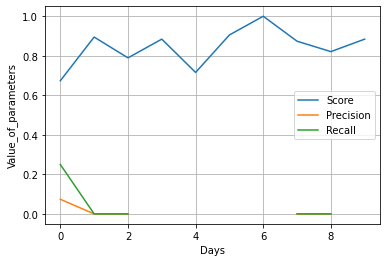

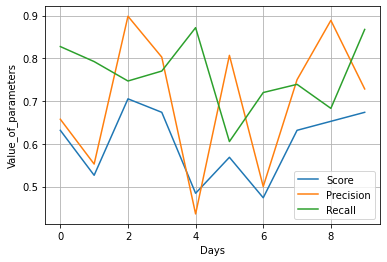

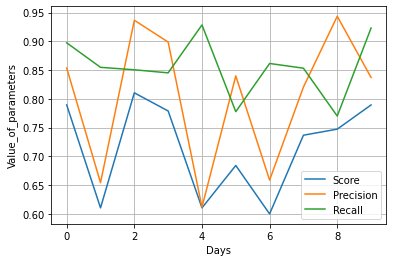

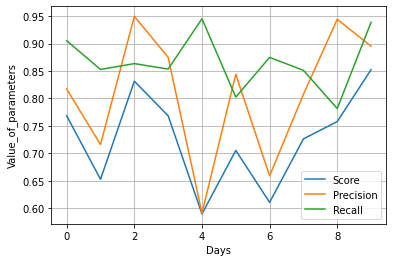

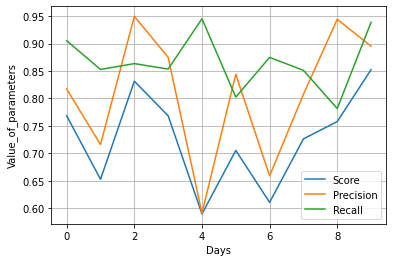

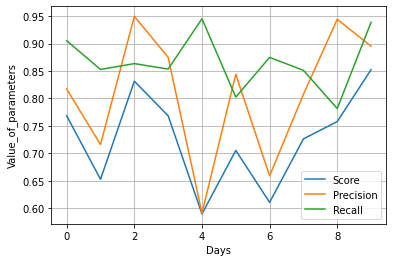

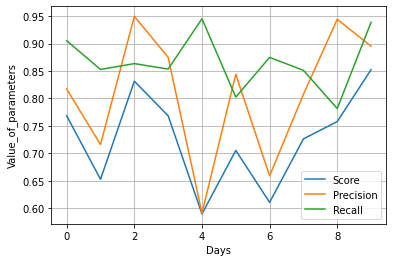

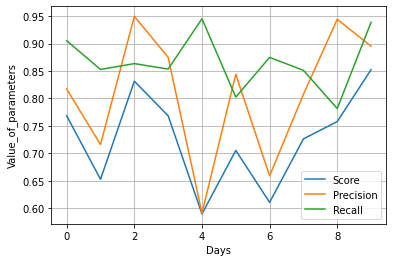

In [100]:
#figure(figsize=(8, 6), dpi=80)
counter = 0
for threshold in thresholds:
    plt.title("Plot of Score, precision and recall given threshold: {}".format(threshold))
    plt.axes(xlabel='Days', ylabel='Value_of_parameters')
    #plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
    plt.grid()
    for i in range(3):
        plt.plot(threshold_plots[counter][:,i])
    plt.legend(["Score", "Precision", "Recall"])
    plt.show()
    counter +=1

# Testy modeli na wybranym thresholdzie i porównanie

### Logistic regression

#### Bez skalowania

Przyklad 1

In [126]:
comp_id = 1
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
use_scaling = False
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
print("Threshold = ", threshold)
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
print("Average model accuracy:", np.sum(res_per_day[:,0])/res_per_day.shape[0])
print("Average precision:", np.sum(res_per_day[:,1])/res_per_day.shape[0])
print("Average recall:", np.sum(res_per_day[:,2])/res_per_day.shape[0])

Threshold =  0.001
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(910,)
Coefficient impact:
order_inbalance   8.958366031258646e-06
vwaps_buy   3.0516588145082533e-05
vwaps_sell   5.015759178496835e-05
s2f_impact_buy   5.266956588630212e-08
s2f_impact_sell   3.0739595775388243e-06
trading_volumes   -1.5225888596041367e-05
price_volatilities   -1.5289425886087315e-07
vwaps_order_sizes_buy   1.15427019648

Coefficient impact:
order_inbalance   1.3012823051175764e-05
vwaps_buy   2.0148395111908768e-05
vwaps_sell   5.995847826238521e-05
s2f_impact_buy   5.015614276206595e-07
s2f_impact_sell   5.442508776756967e-06
trading_volumes   -1.8256229621429465e-05
price_volatilities   -1.2790720712773357e-07
vwaps_order_sizes_buy   8.552025893850436e-06
vwaps_order_sizes_sell   5.023722702461653e-06
s2f_order_sizes_buy   -3.254186218591969e-05
s2f_order_sizes_sell   2.6455775655935704e-05
next_trade_time   0.001577909835914259
next_trade_size   0.0009662520002931313
next_trade_price   7.342250357168114e-05
Number of positive class in training dataset = 499
Number of negative class in training dataset = 320
Number of positive class in testing dataset = 60
Number of negative class in testing dataset = 31
Percent of correct classification:
0.6593406593406593
Confusion matrix:
[[59  1]
 [30  1]]
Precision:
0.9833333333333333
Recall:
0.6629213483146067
Average model accuracy: 0.5659340659340659
Average 

Przyklad 2

In [127]:
comp_id = 7
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
use_scaling = False
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
print("Threshold = ", threshold)
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
print("Average model accuracy:", np.sum(res_per_day[:,0])/res_per_day.shape[0])
print("Average precision:", np.sum(res_per_day[:,1])/res_per_day.shape[0])
print("Average recall:", np.sum(res_per_day[:,2])/res_per_day.shape[0])

Threshold =  0.001
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(910,)
Coefficient impact:
order_inbalance   -1.4123571190476623e-05
vwaps_buy   5.2943026815144355e-06
vwaps_sell   6.651981835325485e-06
s2f_impact_buy   -2.0398321613548575e-07
s2f_impact_sell   -5.800892943800377e-07
trading_volumes   -7.2144118

Mean of all companies for max:

In [130]:
#comp_id = 1
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
use_scaling = False
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]

Threshold =  0.001
32.25% of intervals were SELL empty
24.21875% of intervals were BUY empty
32.25% of intervals were SELL empty
24.21875% of intervals were BUY empty
32.5% of intervals were SELL empty
24.40625% of intervals were BUY empty
32.5% of intervals were SELL empty
24.40625% of intervals were BUY empty
32.25% of intervals were SELL empty
24.21875% of intervals were BUY empty
32.25% of intervals were SELL empty
24.21875% of intervals were BUY empty
32.5% of intervals were SELL empty
24.40625% of intervals were BUY empty
32.5% of intervals were SELL empty
24.40625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   4.96661505772283e-08
vwaps_buy   -2.625632101632235e-07
vwaps_sell   2.563389857439201e-07
s2f_impact_buy   1.804788398643193e-07
s2f_impact_sell   4.2293680166902764e-07
trading_volumes   -4.517996371148785e-06
price_volatilities   -5.344612026907993e-08
vwaps_order_sizes_buy   -7.903232953991964e-05
vwaps_order_sizes_sell   9.466142833283428e-

23.53125% of intervals were SELL empty
24.0% of intervals were BUY empty
23.53125% of intervals were SELL empty
24.0% of intervals were BUY empty
24.90625% of intervals were SELL empty
26.40625% of intervals were BUY empty
24.90625% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.53125% of intervals were SELL empty
24.0% of intervals were BUY empty
23.53125% of intervals were SELL empty
24.0% of intervals were BUY empty
24.90625% of intervals were SELL empty
26.40625% of intervals were BUY empty
24.90625% of intervals were SELL empty
26.40625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   1.4526601954438775e-06
vwaps_buy   1.3542261185051741e-05
vwaps_sell   3.067290306818619e-05
s2f_impact_buy   4.483781466720271e-07
s2f_impact_sell   3.1011440834167374e-06
trading_volumes   -1.2341075105025749e-05
price_volatilities   -5.9441120251414455e-08
vwaps_order_sizes_buy   -9.851464767799592e-06
vwaps_order_sizes_sell   -7.664925517138417e-06

23.40625% of intervals were SELL empty
23.84375% of intervals were BUY empty
23.40625% of intervals were SELL empty
23.84375% of intervals were BUY empty
23.71875% of intervals were SELL empty
24.25% of intervals were BUY empty
23.71875% of intervals were SELL empty
24.25% of intervals were BUY empty
23.40625% of intervals were SELL empty
23.84375% of intervals were BUY empty
23.40625% of intervals were SELL empty
23.84375% of intervals were BUY empty
23.71875% of intervals were SELL empty
24.25% of intervals were BUY empty
23.71875% of intervals were SELL empty
24.25% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   8.503348738990639e-08
vwaps_buy   -1.2766267363304788e-08
vwaps_sell   2.259554827932328e-07
s2f_impact_buy   3.101971046171425e-08
s2f_impact_sell   3.420783833800674e-08
trading_volumes   -1.2330035806833827e-06
price_volatilities   -1.4043422091744765e-07
vwaps_order_sizes_buy   3.303269462682168e-05
vwaps_order_sizes_sell   9.562543988031904e-0

32.0625% of intervals were SELL empty
19.78125% of intervals were BUY empty
32.0625% of intervals were SELL empty
19.78125% of intervals were BUY empty
32.5625% of intervals were SELL empty
20.65625% of intervals were BUY empty
32.5625% of intervals were SELL empty
20.65625% of intervals were BUY empty
32.0625% of intervals were SELL empty
19.78125% of intervals were BUY empty
32.0625% of intervals were SELL empty
19.78125% of intervals were BUY empty
32.5625% of intervals were SELL empty
20.65625% of intervals were BUY empty
32.5625% of intervals were SELL empty
20.65625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -1.0023748542462695e-07
vwaps_buy   -1.0526274741410712e-07
vwaps_sell   1.0333855731183889e-07
s2f_impact_buy   5.585711211883518e-08
s2f_impact_sell   3.1071633241215085e-08
trading_volumes   7.177797160852104e-06
price_volatilities   -3.958989365112204e-08
vwaps_order_sizes_buy   -1.3796024791888348e-05
vwaps_order_sizes_sell   4.11118823420

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



order_inbalance   -2.3749777630709278e-08
vwaps_buy   -5.270979540820682e-10
vwaps_sell   3.336418217506084e-08
s2f_impact_buy   1.8644578579756363e-08
s2f_impact_sell   1.042976352967607e-08
trading_volumes   9.371124098612998e-06
price_volatilities   -7.803203594964304e-08
vwaps_order_sizes_buy   -1.656602196449123e-05
vwaps_order_sizes_sell   1.7182057494500522e-06
s2f_order_sizes_buy   1.0734716898107273e-05
s2f_order_sizes_sell   0.00010288470445044386
next_trade_time   -1.4090861537417576e-07
next_trade_size   1.0157893408190606e-05
next_trade_price   4.15432073539901e-08
Number of positive class in training dataset = 846
Number of negative class in training dataset = 549
Number of positive class in testing dataset = 76
Number of negative class in testing dataset = 79
Percent of correct classification:
0.49032258064516127
Confusion matrix:
[[76  0]
 [79  0]]
Precision:
1.0
Recall:
0.49032258064516127
Coefficient impact:
order_inbalance   -1.4443508344886525e-08
vwaps_buy   -6.85

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   3.4378455862963712e-06
vwaps_buy   5.874950883271191e-06
vwaps_sell   8.502635853218935e-06
s2f_impact_buy   2.2223629932101184e-06
s2f_impact_sell   1.778784913844644e-06
trading_volumes   -2.0627261778034253e-06
price_volatilities   2.161310816442027e-08
vwaps_order_sizes_buy   -3.1605547763056274e-05
vwaps_order_sizes_sell   -6.538033782572299e-05
s2f_order_sizes_buy   4.0522911192466934e-05
s2f_order_sizes_sell   3.2018261012900215e-05
next_trade_time   0.0007053624806110026
next_trade_size   0.0004264962305016592
next_trade_price   1.207357714873439e-05
Number of positive class in training dataset = 779
Number of negative class in training dataset = 616
Number of positive class in testing dataset = 103
Number of negative class in testing dataset = 52
Percent of correct classification:
0.5548387096774193
Confusion matrix:
[[63 40]
 [29 23]]
Precision:
0.6116504854368932
Recall:
0.6847826086956522
Coefficient impact:
order_inbalance   5.18267611

23.78125% of intervals were SELL empty
21.5% of intervals were BUY empty
23.78125% of intervals were SELL empty
21.5% of intervals were BUY empty
27.28125% of intervals were SELL empty
26.1875% of intervals were BUY empty
27.28125% of intervals were SELL empty
26.1875% of intervals were BUY empty
23.78125% of intervals were SELL empty
21.5% of intervals were BUY empty
23.78125% of intervals were SELL empty
21.5% of intervals were BUY empty
27.28125% of intervals were SELL empty
26.1875% of intervals were BUY empty
27.28125% of intervals were SELL empty
26.1875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -6.177684864438588e-09
vwaps_buy   -1.030894315575273e-08
vwaps_sell   1.8088186626697585e-08
s2f_impact_buy   -8.439326609836768e-10
s2f_impact_sell   -1.2045430899508475e-09
trading_volumes   2.0903806579059254e-06
price_volatilities   7.890494198754922e-08
vwaps_order_sizes_buy   1.4410312289222192e-06
vwaps_order_sizes_sell   1.8461922266572894e-05
s2f

32.6875% of intervals were SELL empty
24.59375% of intervals were BUY empty
33.1875% of intervals were SELL empty
25.09375% of intervals were BUY empty
33.1875% of intervals were SELL empty
25.09375% of intervals were BUY empty
32.6875% of intervals were SELL empty
24.59375% of intervals were BUY empty
32.6875% of intervals were SELL empty
24.59375% of intervals were BUY empty
33.1875% of intervals were SELL empty
25.09375% of intervals were BUY empty
33.1875% of intervals were SELL empty
25.09375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -1.2663787126688428e-06
vwaps_buy   -2.20013198317407e-05
vwaps_sell   2.1513217781370043e-06
s2f_impact_buy   5.989883842801824e-06
s2f_impact_sell   3.278013066501038e-06
trading_volumes   3.506917901661727e-06
price_volatilities   -1.6785995749855634e-07
vwaps_order_sizes_buy   0.0002767174046642904
vwaps_order_sizes_sell   0.00035081730980937294
s2f_order_sizes_buy   -0.00015717995841901862
s2f_order_sizes_sell   0

25.09375% of intervals were SELL empty
19.1875% of intervals were BUY empty
25.09375% of intervals were SELL empty
19.1875% of intervals were BUY empty
27.1875% of intervals were SELL empty
22.0625% of intervals were BUY empty
27.1875% of intervals were SELL empty
22.0625% of intervals were BUY empty
25.09375% of intervals were SELL empty
19.1875% of intervals were BUY empty
25.09375% of intervals were SELL empty
19.1875% of intervals were BUY empty
27.1875% of intervals were SELL empty
22.0625% of intervals were BUY empty
27.1875% of intervals were SELL empty
22.0625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -5.7355699896349244e-08
vwaps_buy   9.332799726422234e-08
vwaps_sell   3.177620387019968e-08
s2f_impact_buy   5.496313349660807e-09
s2f_impact_sell   -1.9345209358222967e-09
trading_volumes   -8.518723425362819e-06
price_volatilities   1.1932412895576369e-07
vwaps_order_sizes_buy   9.990790570468547e-07
vwaps_order_sizes_sell   2.281700006947138e-0

25.0625% of intervals were SELL empty
25.84375% of intervals were BUY empty
25.0625% of intervals were SELL empty
25.84375% of intervals were BUY empty
29.1875% of intervals were SELL empty
29.375% of intervals were BUY empty
29.1875% of intervals were SELL empty
29.375% of intervals were BUY empty
25.0625% of intervals were SELL empty
25.84375% of intervals were BUY empty
25.0625% of intervals were SELL empty
25.84375% of intervals were BUY empty
29.1875% of intervals were SELL empty
29.375% of intervals were BUY empty
29.1875% of intervals were SELL empty
29.375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -8.301852902199875e-08
vwaps_buy   -1.0750431707121629e-07
vwaps_sell   2.2568212249842974e-08
s2f_impact_buy   1.706012893064477e-09
s2f_impact_sell   6.632808969487893e-09
trading_volumes   -3.1940733493831632e-06
price_volatilities   -6.714891285611906e-08
vwaps_order_sizes_buy   2.014639236720959e-05
vwaps_order_sizes_sell   -9.902541891935344e-06


Coefficient impact:
order_inbalance   -1.4235292889600949e-07
vwaps_buy   -2.2272643196755868e-07
vwaps_sell   3.111792476718897e-08
s2f_impact_buy   4.148879171159642e-09
s2f_impact_sell   1.0556190289736478e-08
trading_volumes   2.795449071679039e-06
price_volatilities   -1.329527363441497e-07
vwaps_order_sizes_buy   2.5039876704967035e-05
vwaps_order_sizes_sell   -1.1893575217600508e-05
s2f_order_sizes_buy   4.9264307180452984e-05
s2f_order_sizes_sell   0.00013883547350296166
next_trade_time   1.3964184207579168e-05
next_trade_size   -0.00010128155413883595
next_trade_price   -1.5826049045653826e-07
Number of positive class in training dataset = 880
Number of negative class in training dataset = 515
Number of positive class in testing dataset = 98
Number of negative class in testing dataset = 57
Percent of correct classification:
0.632258064516129
Confusion matrix:
[[95  3]
 [54  3]]
Precision:
0.9693877551020408
Recall:
0.6375838926174496
27.90625% of intervals were SELL empty
17.2

20.25% of intervals were SELL empty
28.375% of intervals were BUY empty
20.25% of intervals were SELL empty
28.375% of intervals were BUY empty
21.0% of intervals were SELL empty
28.71875% of intervals were BUY empty
21.0% of intervals were SELL empty
28.71875% of intervals were BUY empty
20.25% of intervals were SELL empty
28.375% of intervals were BUY empty
20.25% of intervals were SELL empty
28.375% of intervals were BUY empty
21.0% of intervals were SELL empty
28.71875% of intervals were BUY empty
21.0% of intervals were SELL empty
28.71875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -5.830394803194385e-07
vwaps_buy   -7.232534205543537e-06
vwaps_sell   7.884282697963984e-06
s2f_impact_buy   -1.3880853254190208e-06
s2f_impact_sell   -1.0434503395626793e-06
trading_volumes   8.197724236654909e-06
price_volatilities   -1.7601212228090446e-08
vwaps_order_sizes_buy   -2.456977092121232e-05
vwaps_order_sizes_sell   -1.3500305843504383e-05
s2f_order_sizes_b

30.21875% of intervals were SELL empty
17.0625% of intervals were BUY empty
30.21875% of intervals were SELL empty
17.0625% of intervals were BUY empty
31.5% of intervals were SELL empty
18.5% of intervals were BUY empty
31.5% of intervals were SELL empty
18.5% of intervals were BUY empty
30.21875% of intervals were SELL empty
17.0625% of intervals were BUY empty
30.21875% of intervals were SELL empty
17.0625% of intervals were BUY empty
31.5% of intervals were SELL empty
18.5% of intervals were BUY empty
31.5% of intervals were SELL empty
18.5% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   7.903903896348545e-08
vwaps_buy   -8.485011536153497e-07
vwaps_sell   1.8138794645091745e-06
s2f_impact_buy   4.092720624115189e-07
s2f_impact_sell   2.1679636763640935e-07
trading_volumes   2.2062020166283797e-06
price_volatilities   -1.691837466953748e-07
vwaps_order_sizes_buy   -8.575072251828214e-07
vwaps_order_sizes_sell   1.0198450951390305e-05
s2f_order_sizes_buy  

Recall:
0.6438356164383562
23.90625% of intervals were SELL empty
23.8125% of intervals were BUY empty
23.90625% of intervals were SELL empty
23.8125% of intervals were BUY empty
28.59375% of intervals were SELL empty
25.6875% of intervals were BUY empty
28.59375% of intervals were SELL empty
25.6875% of intervals were BUY empty
23.90625% of intervals were SELL empty
23.8125% of intervals were BUY empty
23.90625% of intervals were SELL empty
23.8125% of intervals were BUY empty
28.59375% of intervals were SELL empty
25.6875% of intervals were BUY empty
28.59375% of intervals were SELL empty
25.6875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   6.129097769243923e-07
vwaps_buy   -1.2004313566862838e-07
vwaps_sell   3.89790358505443e-07
s2f_impact_buy   2.3662297376349254e-07
s2f_impact_sell   5.255230985328806e-08
trading_volumes   -1.3940196235372923e-06
price_volatilities   -2.5462384734952383e-08
vwaps_order_sizes_buy   1.8848848288275459e-06
vwaps_order_s

Coefficient impact:
order_inbalance   -4.390115946696408e-07
vwaps_buy   -1.1466617898678362e-06
vwaps_sell   -1.3730619296105952e-06
s2f_impact_buy   2.269380897578616e-07
s2f_impact_sell   -2.479629867905863e-08
trading_volumes   1.4737935456011962e-06
price_volatilities   -2.772168288883486e-08
vwaps_order_sizes_buy   -1.203253512382289e-06
vwaps_order_sizes_sell   1.1482315592280546e-06
s2f_order_sizes_buy   7.857378432132481e-06
s2f_order_sizes_sell   3.5394239832182374e-06
next_trade_time   0.0005887619024780618
next_trade_size   -1.7152517047786115e-05
next_trade_price   -2.374547510998689e-06
Number of positive class in training dataset = 749
Number of negative class in training dataset = 646
Number of positive class in testing dataset = 83
Number of negative class in testing dataset = 72
Percent of correct classification:
0.535483870967742
Confusion matrix:
[[83  0]
 [72  0]]
Precision:
1.0
Recall:
0.535483870967742
Coefficient impact:
order_inbalance   -1.070610090122115e-07


Coefficient impact:
order_inbalance   2.1370366433264988e-09
vwaps_buy   -5.086145334016679e-10
vwaps_sell   3.372383640543233e-10
s2f_impact_buy   -1.5251507916809622e-11
s2f_impact_sell   1.2764828809325682e-10
trading_volumes   8.866954566904446e-07
price_volatilities   1.565262258158024e-08
vwaps_order_sizes_buy   -1.1040074495799804e-05
vwaps_order_sizes_sell   -9.688610139332146e-06
s2f_order_sizes_buy   2.0288615508533206e-05
s2f_order_sizes_sell   2.8285713284758326e-05
next_trade_time   -3.4014897064381313e-07
next_trade_size   1.3504266826164726e-05
next_trade_price   2.1944563124225258e-10
Number of positive class in training dataset = 832
Number of negative class in training dataset = 563
Number of positive class in testing dataset = 92
Number of negative class in testing dataset = 63
Percent of correct classification:
0.5870967741935483
Confusion matrix:
[[91  1]
 [63  0]]
Precision:
0.9891304347826086
Recall:
0.5909090909090909
24.625% of intervals were SELL empty
25.5937

Coefficient impact:
order_inbalance   1.203029285117389e-06
vwaps_buy   4.95009027045577e-06
vwaps_sell   4.203136169370728e-05
s2f_impact_buy   2.0132217756951016e-07
s2f_impact_sell   4.570932291100156e-06
trading_volumes   2.9326973339739103e-05
price_volatilities   -1.3983791004632696e-07
vwaps_order_sizes_buy   8.790563869391731e-05
vwaps_order_sizes_sell   2.4447303720364323e-06
s2f_order_sizes_buy   -0.0002894891837243118
s2f_order_sizes_sell   4.801738481759949e-05
next_trade_time   -0.00010730301444553094
next_trade_size   0.0009999182871977446
next_trade_price   4.637570465640317e-05
Number of positive class in training dataset = 828
Number of negative class in training dataset = 567
Number of positive class in testing dataset = 65
Number of negative class in testing dataset = 90
Percent of correct classification:
0.5483870967741935
Confusion matrix:
[[63  2]
 [68 22]]
Precision:
0.9692307692307692
Recall:
0.48091603053435117
Coefficient impact:
order_inbalance   2.7028218877

Coefficient impact:
order_inbalance   1.633174281833092e-07
vwaps_buy   2.7269497384890354e-07
vwaps_sell   9.020441989687407e-06
s2f_impact_buy   -2.454367493383367e-07
s2f_impact_sell   1.4188572739916641e-08
trading_volumes   -5.209827384471184e-05
price_volatilities   1.1443542115866197e-07
vwaps_order_sizes_buy   -0.00014466307420831612
vwaps_order_sizes_sell   6.711309666374849e-05
s2f_order_sizes_buy   0.00019972748209168116
s2f_order_sizes_sell   -1.6279810133219543e-05
next_trade_time   0.00022252746750433852
next_trade_size   0.001038672542454664
next_trade_price   8.990466319935715e-06
Number of positive class in training dataset = 786
Number of negative class in training dataset = 609
Number of positive class in testing dataset = 61
Number of negative class in testing dataset = 94
Percent of correct classification:
0.535483870967742
Confusion matrix:
[[49 12]
 [60 34]]
Precision:
0.8032786885245902
Recall:
0.44954128440366975
Coefficient impact:
order_inbalance   5.02208004

Coefficient impact:
order_inbalance   -1.0835978169662008e-08
vwaps_buy   2.6333265095652737e-08
vwaps_sell   1.8399950474772664e-08
s2f_impact_buy   1.2972481489787405e-08
s2f_impact_sell   1.2058346779021516e-08
trading_volumes   -6.570417758922701e-06
price_volatilities   -2.4578929151447167e-07
vwaps_order_sizes_buy   2.262536212141483e-05
vwaps_order_sizes_sell   -9.554909935176638e-06
s2f_order_sizes_buy   1.9677425349682635e-05
s2f_order_sizes_sell   8.464407067237077e-05
next_trade_time   -1.8128831293878392e-07
next_trade_size   -2.284751986435958e-05
next_trade_price   4.096822991449464e-08
Number of positive class in training dataset = 953
Number of negative class in training dataset = 442
Number of positive class in testing dataset = 106
Number of negative class in testing dataset = 49
Percent of correct classification:
0.6580645161290323
Confusion matrix:
[[100   6]
 [ 47   2]]
Precision:
0.9433962264150944
Recall:
0.6802721088435374
Coefficient impact:
order_inbalance   -

s2f_impact_buy   1.5972644546718728e-07
s2f_impact_sell   6.700546983278987e-08
trading_volumes   -1.8203474223077147e-05
price_volatilities   1.3934524593039022e-07
vwaps_order_sizes_buy   -8.427752711392868e-05
vwaps_order_sizes_sell   -2.5348458834093446e-05
s2f_order_sizes_buy   0.00012262600659237056
s2f_order_sizes_sell   2.746432438240614e-05
next_trade_time   -1.966299826614684e-06
next_trade_size   1.263605939904754e-05
next_trade_price   3.3789778410511577e-07
Number of positive class in training dataset = 687
Number of negative class in training dataset = 708
Number of positive class in testing dataset = 57
Number of negative class in testing dataset = 98
Percent of correct classification:
0.4838709677419355
Confusion matrix:
[[11 46]
 [34 64]]
Precision:
0.19298245614035087
Recall:
0.24444444444444444
Coefficient impact:
order_inbalance   2.010178669512128e-07
vwaps_buy   -8.004277661097796e-07
vwaps_sell   1.772036593106644e-06
s2f_impact_buy   9.494494802620003e-08
s2f_im

<ipython-input-95-7ba136a4f916>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-95-7ba136a4f916>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



order_inbalance   1.7392705705806328e-07
vwaps_buy   -8.506123944283771e-07
vwaps_sell   1.9299736495174852e-06
s2f_impact_buy   2.022912223205182e-07
s2f_impact_sell   1.7585775269883743e-07
trading_volumes   -2.1486751482292278e-05
price_volatilities   1.3119423800027906e-07
vwaps_order_sizes_buy   -0.00017009467591083975
vwaps_order_sizes_sell   -7.775328155434352e-06
s2f_order_sizes_buy   0.0001373206171311477
s2f_order_sizes_sell   1.883894343022041e-05
next_trade_time   -2.042356093526165e-05
next_trade_size   -2.357705197306218e-05
next_trade_price   7.536982173000605e-07
Number of positive class in training dataset = 626
Number of negative class in training dataset = 769
Number of positive class in testing dataset = 118
Number of negative class in testing dataset = 37
Percent of correct classification:
0.23870967741935484
Confusion matrix:
[[  0 118]
 [  0  37]]
Precision:
0.0
Recall:
nan
Coefficient impact:
order_inbalance   1.3001759457385776e-07
vwaps_buy   -5.6731691486080

Coefficient impact:
order_inbalance   -1.3208447562634477e-07
vwaps_buy   -4.704783854676333e-06
vwaps_sell   5.743701341345772e-06
s2f_impact_buy   1.1510533955886035e-06
s2f_impact_sell   1.5249894225548851e-06
trading_volumes   -1.2729924442197106e-05
price_volatilities   4.2324036090490396e-08
vwaps_order_sizes_buy   -1.7603698982472655e-05
vwaps_order_sizes_sell   -1.2546647983989584e-05
s2f_order_sizes_buy   7.354636225321816e-05
s2f_order_sizes_sell   0.00012128845872432207
next_trade_time   0.0007405199999921795
next_trade_size   -0.00019795775446288931
next_trade_price   -1.5415855635942123e-06
Number of positive class in training dataset = 767
Number of negative class in training dataset = 628
Number of positive class in testing dataset = 94
Number of negative class in testing dataset = 61
Percent of correct classification:
0.5419354838709678
Confusion matrix:
[[83 11]
 [60  1]]
Precision:
0.8829787234042553
Recall:
0.5804195804195804
Coefficient impact:
order_inbalance   -5.

Precision:
0.9426229508196722
Recall:
0.777027027027027
Coefficient impact:
order_inbalance   1.743925109068987e-08
vwaps_buy   2.185077459416629e-06
vwaps_sell   5.4604909725597545e-06
s2f_impact_buy   1.9094443757378712e-07
s2f_impact_sell   4.6993343275820776e-07
trading_volumes   2.4022704406867754e-06
price_volatilities   -1.1376929820194024e-07
vwaps_order_sizes_buy   -2.4299502488884743e-05
vwaps_order_sizes_sell   7.566155725650623e-05
s2f_order_sizes_buy   0.00029165955812528887
s2f_order_sizes_sell   0.00012314039098907168
next_trade_time   -5.556059975786832e-05
next_trade_size   -3.876327374769664e-05
next_trade_price   7.632605612732866e-06
Number of positive class in training dataset = 918
Number of negative class in training dataset = 477
Number of positive class in testing dataset = 104
Number of negative class in testing dataset = 51
Percent of correct classification:
0.6838709677419355
Confusion matrix:
[[104   0]
 [ 49   2]]
Precision:
1.0
Recall:
0.6797385620915033


Coefficient impact:
order_inbalance   -5.882818252462681e-06
vwaps_buy   -1.7944098276529346e-05
vwaps_sell   2.8789232830962216e-06
s2f_impact_buy   5.772196957243907e-07
s2f_impact_sell   9.848199944393985e-07
trading_volumes   1.411540449073779e-06
price_volatilities   7.829448185563482e-08
vwaps_order_sizes_buy   -5.556377132698752e-06
vwaps_order_sizes_sell   3.7356146971211678e-06
s2f_order_sizes_buy   3.5057491878391804e-05
s2f_order_sizes_sell   8.376960615487913e-05
next_trade_time   0.000505525750347229
next_trade_size   -3.0431910816812855e-05
next_trade_price   -1.6897620255585592e-05
Number of positive class in training dataset = 824
Number of negative class in training dataset = 571
Number of positive class in testing dataset = 95
Number of negative class in testing dataset = 60
Percent of correct classification:
0.5419354838709678
Confusion matrix:
[[72 23]
 [48 12]]
Precision:
0.7578947368421053
Recall:
0.6
Coefficient impact:
order_inbalance   -4.665571823664079e-06
vw

Precision:
1.0
Recall:
0.5612903225806452
Coefficient impact:
order_inbalance   -7.269491731764366e-07
vwaps_buy   2.1685254821861266e-06
vwaps_sell   9.989713623307233e-07
s2f_impact_buy   2.449557869850179e-07
s2f_impact_sell   1.1429229500335278e-07
trading_volumes   4.421295677312464e-06
price_volatilities   -1.6497775684341289e-07
vwaps_order_sizes_buy   -1.5073010707923802e-05
vwaps_order_sizes_sell   5.5127915830152616e-05
s2f_order_sizes_buy   4.6594689879769015e-05
s2f_order_sizes_sell   -5.389075384511803e-05
next_trade_time   6.659806682234474e-05
next_trade_size   3.4608687863622776e-05
next_trade_price   3.2451934598399775e-06
Number of positive class in training dataset = 880
Number of negative class in training dataset = 515
Number of positive class in testing dataset = 106
Number of negative class in testing dataset = 49
Percent of correct classification:
0.6645161290322581
Confusion matrix:
[[103   3]
 [ 49   0]]
Precision:
0.9716981132075472
Recall:
0.6776315789473685

Coefficient impact:
order_inbalance   -5.427467057931932e-06
vwaps_buy   1.6837327700502362e-05
vwaps_sell   9.282230450937412e-05
s2f_impact_buy   5.181911178986321e-07
s2f_impact_sell   -9.795785031523215e-06
trading_volumes   -9.529149029777607e-05
price_volatilities   -1.9073869027930502e-07
vwaps_order_sizes_buy   7.331185137332042e-07
vwaps_order_sizes_sell   0.00028736815561751803
s2f_order_sizes_buy   -0.00013911879109071705
s2f_order_sizes_sell   -0.0002922044099428973
next_trade_time   0.0013218616909103933
next_trade_size   0.0029354689272412288
next_trade_price   8.471083176319626e-05
Number of positive class in training dataset = 839
Number of negative class in training dataset = 556
Number of positive class in testing dataset = 92
Number of negative class in testing dataset = 63
Percent of correct classification:
0.5612903225806452
Confusion matrix:
[[78 14]
 [54  9]]
Precision:
0.8478260869565217
Recall:
0.5909090909090909
Coefficient impact:
order_inbalance   -1.3621896

Coefficient impact:
order_inbalance   -4.891065161391406e-06
vwaps_buy   -3.535633630381751e-07
vwaps_sell   7.291365087167825e-06
s2f_impact_buy   2.3995467270947245e-07
s2f_impact_sell   3.783198638756127e-07
trading_volumes   1.191113727968686e-07
price_volatilities   -3.4741365408993524e-07
vwaps_order_sizes_buy   1.6652690123329428e-06
vwaps_order_sizes_sell   2.8130091253923736e-06
s2f_order_sizes_buy   1.765337584447387e-05
s2f_order_sizes_sell   2.6359509171944865e-05
next_trade_time   0.00030304481427742395
next_trade_size   6.687615753898301e-05
next_trade_price   7.275462659439259e-06
Number of positive class in training dataset = 858
Number of negative class in training dataset = 537
Number of positive class in testing dataset = 103
Number of negative class in testing dataset = 52
Percent of correct classification:
0.6645161290322581
Confusion matrix:
[[103   0]
 [ 52   0]]
Precision:
1.0
Recall:
0.6645161290322581
Coefficient impact:
order_inbalance   -6.698898399034892e-0

Coefficient impact:
order_inbalance   4.823098988841297e-07
vwaps_buy   9.316900506542345e-06
vwaps_sell   3.064655082879395e-05
s2f_impact_buy   4.096901624042349e-06
s2f_impact_sell   3.754912199295443e-06
trading_volumes   -1.349311205176971e-05
price_volatilities   -1.1402018346501927e-07
vwaps_order_sizes_buy   -9.410987761074068e-06
vwaps_order_sizes_sell   7.600312323320906e-05
s2f_order_sizes_buy   0.00027314410968907213
s2f_order_sizes_sell   1.3927850093057778e-05
next_trade_time   0.0006497999995050876
next_trade_size   -6.80443013225653e-05
next_trade_price   3.51974374780586e-05
Number of positive class in training dataset = 923
Number of negative class in training dataset = 472
Number of positive class in testing dataset = 103
Number of negative class in testing dataset = 52
Percent of correct classification:
0.6645161290322581
Confusion matrix:
[[103   0]
 [ 52   0]]
Precision:
1.0
Recall:
0.6645161290322581
Coefficient impact:
order_inbalance   9.186507674039168e-08
vwa

Coefficient impact:
order_inbalance   -1.9885355010011684e-08
vwaps_buy   2.8958881833930268e-06
vwaps_sell   1.182288851214614e-07
s2f_impact_buy   2.446320333178856e-07
s2f_impact_sell   5.6883931517321716e-08
trading_volumes   -1.7950429780491934e-06
price_volatilities   -5.187408376661277e-07
vwaps_order_sizes_buy   -3.1664439200909624e-07
vwaps_order_sizes_sell   6.509515579774353e-06
s2f_order_sizes_buy   7.6021546135474e-06
s2f_order_sizes_sell   1.910435546022651e-05
next_trade_time   -0.0006033753049565912
next_trade_size   0.0002698857961853036
next_trade_price   3.4481013169158863e-06
Number of positive class in training dataset = 1044
Number of negative class in training dataset = 351
Number of positive class in testing dataset = 102
Number of negative class in testing dataset = 53
Percent of correct classification:
0.6129032258064516
Confusion matrix:
[[95  7]
 [53  0]]
Precision:
0.9313725490196079
Recall:
0.6418918918918919
Coefficient impact:
order_inbalance   -7.431783

vwaps_order_sizes_sell   -1.3164036308081976e-05
s2f_order_sizes_buy   -1.3094716127773701e-05
s2f_order_sizes_sell   -1.0869550680825025e-05
next_trade_time   0.0005020175121012129
next_trade_size   3.146849831226312e-05
next_trade_price   -7.662300296238956e-07
Number of positive class in training dataset = 749
Number of negative class in training dataset = 646
Number of positive class in testing dataset = 32
Number of negative class in testing dataset = 123
Percent of correct classification:
0.49032258064516127
Confusion matrix:
[[ 9 23]
 [56 67]]
Precision:
0.28125
Recall:
0.13846153846153847
Coefficient impact:
order_inbalance   -5.383289133589184e-07
vwaps_buy   1.9871740846519731e-07
vwaps_sell   7.034357800558207e-07
s2f_impact_buy   2.128468073908542e-07
s2f_impact_sell   4.3519838849689235e-07
trading_volumes   2.8887759436509946e-06
price_volatilities   -1.9333252851556273e-07
vwaps_order_sizes_buy   -6.978406702451395e-07
vwaps_order_sizes_sell   -3.3169684465695555e-05
s2f

26.21875% of intervals were SELL empty
20.65625% of intervals were BUY empty
26.21875% of intervals were SELL empty
20.65625% of intervals were BUY empty
28.34375% of intervals were SELL empty
24.65625% of intervals were BUY empty
28.34375% of intervals were SELL empty
24.65625% of intervals were BUY empty
26.21875% of intervals were SELL empty
20.65625% of intervals were BUY empty
26.21875% of intervals were SELL empty
20.65625% of intervals were BUY empty
28.34375% of intervals were SELL empty
24.65625% of intervals were BUY empty
28.34375% of intervals were SELL empty
24.65625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   6.634973668510325e-09
vwaps_buy   9.028461041914876e-09
vwaps_sell   1.8410652472105334e-08
s2f_impact_buy   -5.274312654475267e-10
s2f_impact_sell   6.737496184875998e-10
trading_volumes   6.612533562134124e-06
price_volatilities   -5.931089490914042e-08
vwaps_order_sizes_buy   -2.3060312222313137e-06
vwaps_order_sizes_sell   -1.475571

Coefficient impact:
order_inbalance   8.112491059562524e-07
vwaps_buy   1.325265058096283e-06
vwaps_sell   2.7399263153529773e-06
s2f_impact_buy   -1.9255630506275565e-07
s2f_impact_sell   -6.617425925283557e-08
trading_volumes   5.5876937707242165e-06
price_volatilities   -9.017885645271625e-08
vwaps_order_sizes_buy   -8.31601595141833e-06
vwaps_order_sizes_sell   -1.8732838609192606e-05
s2f_order_sizes_buy   6.2222081804439e-05
s2f_order_sizes_sell   6.58047688360386e-05
next_trade_time   -0.0001951851157368455
next_trade_size   5.275977401225787e-06
next_trade_price   4.68960957763157e-06
Number of positive class in training dataset = 911
Number of negative class in training dataset = 484
Number of positive class in testing dataset = 83
Number of negative class in testing dataset = 72
Percent of correct classification:
0.4967741935483871
Confusion matrix:
[[77  6]
 [72  0]]
Precision:
0.927710843373494
Recall:
0.5167785234899329
27.40625% of intervals were SELL empty
23.875% of inte

next_trade_size   -0.00014281427761497686
next_trade_price   1.112002568222344e-06
Number of positive class in training dataset = 718
Number of negative class in training dataset = 677
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 67
Percent of correct classification:
0.6516129032258065
Confusion matrix:
[[74 14]
 [40 27]]
Precision:
0.8409090909090909
Recall:
0.6491228070175439
Coefficient impact:
order_inbalance   -6.370317982009426e-07
vwaps_buy   -2.8729885632973263e-07
vwaps_sell   2.9002828668298897e-06
s2f_impact_buy   2.506687107433983e-07
s2f_impact_sell   7.832916281058101e-08
trading_volumes   -1.7662621793125765e-05
price_volatilities   -8.339612485078034e-08
vwaps_order_sizes_buy   -3.294914627174954e-05
vwaps_order_sizes_sell   -4.3800447276842075e-06
s2f_order_sizes_buy   -7.37030265430711e-05
s2f_order_sizes_sell   0.00016360011693845078
next_trade_time   -1.8810095758491378e-05
next_trade_size   -0.00018572357816785986
n

Coefficient impact:
order_inbalance   -1.7639598328953866e-06
vwaps_buy   -5.240625082163994e-06
vwaps_sell   3.0549697091132255e-06
s2f_impact_buy   -1.3571923300603182e-07
s2f_impact_sell   -2.5774295256684746e-07
trading_volumes   -2.5850153126766314e-06
price_volatilities   -7.759542188254159e-07
vwaps_order_sizes_buy   4.705673086023e-06
vwaps_order_sizes_sell   -1.4516106842508348e-06
s2f_order_sizes_buy   -6.044786798612652e-06
s2f_order_sizes_sell   3.6360792684297736e-05
next_trade_time   -0.0006633570094893204
next_trade_size   4.014268552072946e-06
next_trade_price   -1.7800594833937367e-06
Number of positive class in training dataset = 798
Number of negative class in training dataset = 597
Number of positive class in testing dataset = 41
Number of negative class in testing dataset = 114
Percent of correct classification:
0.3032258064516129
Confusion matrix:
[[ 38   3]
 [105   9]]
Precision:
0.926829268292683
Recall:
0.26573426573426573
28.15625% of intervals were SELL empty

Coefficient impact:
order_inbalance   -1.2615988408480315e-08
vwaps_buy   3.8610811477527065e-05
vwaps_sell   3.835542497092177e-05
s2f_impact_buy   1.0983789291153402e-07
s2f_impact_sell   1.360973166546411e-07
trading_volumes   -7.397105685866806e-05
price_volatilities   -7.755266058494117e-08
vwaps_order_sizes_buy   -0.0003426507669777543
vwaps_order_sizes_sell   -0.00010978439594295014
s2f_order_sizes_buy   -0.00017375419799865968
s2f_order_sizes_sell   0.0002881177370416205
next_trade_time   0.00010202744561694289
next_trade_size   0.00030929195652746493
next_trade_price   8.334825611488881e-05
Number of positive class in training dataset = 708
Number of negative class in training dataset = 687
Number of positive class in testing dataset = 122
Number of negative class in testing dataset = 33
Percent of correct classification:
0.5419354838709678
Confusion matrix:
[[67 55]
 [16 17]]
Precision:
0.5491803278688525
Recall:
0.8072289156626506
19.8125% of intervals were SELL empty
21.093

[[  3 102]
 [  1  49]]
Precision:
0.02857142857142857
Recall:
0.75
Coefficient impact:
order_inbalance   4.2447311453739376e-08
vwaps_buy   -9.073877476661685e-08
vwaps_sell   2.3359029030960776e-07
s2f_impact_buy   4.92581561426025e-09
s2f_impact_sell   4.6988930955369655e-08
trading_volumes   -1.1773001504625923e-06
price_volatilities   3.548447430281435e-07
vwaps_order_sizes_buy   3.3182380562850006e-06
vwaps_order_sizes_sell   -9.431230446610979e-06
s2f_order_sizes_buy   -3.0606833008362796e-06
s2f_order_sizes_sell   2.035992424972157e-05
next_trade_time   -1.6161505693517413e-06
next_trade_size   -4.3940007816844634e-05
next_trade_price   1.60617371760607e-07
Number of positive class in training dataset = 747
Number of negative class in training dataset = 648
Number of positive class in testing dataset = 59
Number of negative class in testing dataset = 96
Percent of correct classification:
0.5225806451612903
Confusion matrix:
[[18 41]
 [33 63]]
Precision:
0.3050847457627119
Recall

Coefficient impact:
order_inbalance   -7.85963427956188e-06
vwaps_buy   3.790091551404697e-05
vwaps_sell   2.2882398955206404e-05
s2f_impact_buy   4.279335475003228e-06
s2f_impact_sell   1.7636684293394824e-06
trading_volumes   -1.9177229033939918e-05
price_volatilities   1.9945066071302094e-08
vwaps_order_sizes_buy   -0.00040016988601691676
vwaps_order_sizes_sell   0.0001699547841254426
s2f_order_sizes_buy   0.00048328045326780664
s2f_order_sizes_sell   -0.00014434076221483548
next_trade_time   0.0005843269259483608
next_trade_size   0.0012608001194880378
next_trade_price   6.253350030265024e-05
Number of positive class in training dataset = 834
Number of negative class in training dataset = 561
Number of positive class in testing dataset = 95
Number of negative class in testing dataset = 60
Percent of correct classification:
0.6129032258064516
Confusion matrix:
[[95  0]
 [60  0]]
Precision:
1.0
Recall:
0.6129032258064516
19.78125% of intervals were SELL empty
24.03125% of intervals w

Coefficient impact:
order_inbalance   1.4091115536991379e-06
vwaps_buy   -9.944997013417326e-06
vwaps_sell   2.013994743687451e-05
s2f_impact_buy   -2.0370167077170798e-06
s2f_impact_sell   -1.0721378075566078e-07
trading_volumes   -5.280187385618576e-06
price_volatilities   -3.217885656846874e-07
vwaps_order_sizes_buy   -7.998689673066624e-06
vwaps_order_sizes_sell   -1.285395467959254e-05
s2f_order_sizes_buy   1.4054378193549695e-05
s2f_order_sizes_sell   2.1763354665654313e-05
next_trade_time   0.0015511734931670013
next_trade_size   -0.00021843006656007406
next_trade_price   8.07985888281913e-06
Number of positive class in training dataset = 686
Number of negative class in training dataset = 709
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 77
Percent of correct classification:
0.5741935483870968
Confusion matrix:
[[33 45]
 [21 56]]
Precision:
0.4230769230769231
Recall:
0.6111111111111112
27.875% of intervals were SELL empty
18.40625

24.96875% of intervals were SELL empty
29.3125% of intervals were BUY empty
24.96875% of intervals were SELL empty
29.3125% of intervals were BUY empty
25.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
25.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
24.96875% of intervals were SELL empty
29.3125% of intervals were BUY empty
24.96875% of intervals were SELL empty
29.3125% of intervals were BUY empty
25.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
25.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   1.9069648904351214e-07
vwaps_buy   5.2897396667095595e-06
vwaps_sell   8.823752449425405e-07
s2f_impact_buy   -1.771268682472707e-08
s2f_impact_sell   -6.948422811595814e-08
trading_volumes   -6.307822140119683e-06
price_volatilities   -3.8100810409718456e-08
vwaps_order_sizes_buy   7.919084863084907e-06
vwaps_order_sizes_sell   -1.8775008918163733e-05
s2f

29.6875% of intervals were SELL empty
22.9375% of intervals were BUY empty
29.6875% of intervals were SELL empty
22.9375% of intervals were BUY empty
30.03125% of intervals were SELL empty
23.25% of intervals were BUY empty
30.03125% of intervals were SELL empty
23.25% of intervals were BUY empty
29.6875% of intervals were SELL empty
22.9375% of intervals were BUY empty
29.6875% of intervals were SELL empty
22.9375% of intervals were BUY empty
30.03125% of intervals were SELL empty
23.25% of intervals were BUY empty
30.03125% of intervals were SELL empty
23.25% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -8.48165748381282e-08
vwaps_buy   2.511877007646686e-06
vwaps_sell   8.25908989577827e-06
s2f_impact_buy   1.289589555037025e-06
s2f_impact_sell   1.4309843425895253e-06
trading_volumes   9.344304270095924e-05
price_volatilities   -5.910375223211571e-08
vwaps_order_sizes_buy   0.00017658395800915146
vwaps_order_sizes_sell   -0.0003365676631161445
s2f_order

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



order_inbalance   -6.022163125834537e-08
vwaps_buy   1.760650716068554e-06
vwaps_sell   3.1183302497992368e-06
s2f_impact_buy   5.095900942771639e-07
s2f_impact_sell   7.363515586660282e-07
trading_volumes   0.00014500026737648865
price_volatilities   -1.7432909816632848e-07
vwaps_order_sizes_buy   -6.548964685536458e-05
vwaps_order_sizes_sell   -0.00029561849730455207
s2f_order_sizes_buy   7.081185876622784e-05
s2f_order_sizes_sell   0.00030471937454320516
next_trade_time   9.732373015651781e-05
next_trade_size   -3.492194536793572e-05
next_trade_price   4.482204521473323e-06
Number of positive class in training dataset = 899
Number of negative class in training dataset = 496
Number of positive class in testing dataset = 91
Number of negative class in testing dataset = 64
Percent of correct classification:
0.5806451612903226
Confusion matrix:
[[90  1]
 [64  0]]
Precision:
0.989010989010989
Recall:
0.5844155844155844
Coefficient impact:
order_inbalance   -3.558586258484295e-07
vwaps_b

Coefficient impact:
order_inbalance   -1.432828900169594e-07
vwaps_buy   -7.87882698758451e-06
vwaps_sell   8.493015400472472e-06
s2f_impact_buy   -4.935002021028448e-07
s2f_impact_sell   5.360871390646288e-07
trading_volumes   4.889425654995953e-07
price_volatilities   -2.3338173780171583e-08
vwaps_order_sizes_buy   6.784042897603147e-05
vwaps_order_sizes_sell   -1.1037420226677262e-05
s2f_order_sizes_buy   4.130974411606097e-06
s2f_order_sizes_sell   0.0004901574579434608
next_trade_time   -6.598498072366068e-07
next_trade_size   -0.00026313270026586744
next_trade_price   3.1794580548645563e-06
Number of positive class in training dataset = 830
Number of negative class in training dataset = 565
Number of positive class in testing dataset = 93
Number of negative class in testing dataset = 62
Percent of correct classification:
0.6064516129032258
Confusion matrix:
[[93  0]
 [61  1]]
Precision:
1.0
Recall:
0.6038961038961039
Coefficient impact:
order_inbalance   -1.2662838164711636e-06
v

33.5% of intervals were SELL empty
22.625% of intervals were BUY empty
33.5% of intervals were SELL empty
22.625% of intervals were BUY empty
33.5625% of intervals were SELL empty
22.84375% of intervals were BUY empty
33.5625% of intervals were SELL empty
22.84375% of intervals were BUY empty
33.5% of intervals were SELL empty
22.625% of intervals were BUY empty
33.5% of intervals were SELL empty
22.625% of intervals were BUY empty
33.5625% of intervals were SELL empty
22.84375% of intervals were BUY empty
33.5625% of intervals were SELL empty
22.84375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   6.933573988011297e-07
vwaps_buy   3.7515331290829396e-06
vwaps_sell   4.631571064528595e-06
s2f_impact_buy   1.034866211571644e-06
s2f_impact_sell   1.7515043090462888e-06
trading_volumes   -3.985074924117667e-05
price_volatilities   -8.32030018392326e-08
vwaps_order_sizes_buy   2.3309731012034945e-05
vwaps_order_sizes_sell   0.0002808145568849903
s2f_order_sizes_

[[91  5]
 [49 10]]
Precision:
0.9479166666666666
Recall:
0.65
Coefficient impact:
order_inbalance   -1.147979406147194e-07
vwaps_buy   2.6724517230499742e-06
vwaps_sell   3.1290537017267076e-06
s2f_impact_buy   1.1383558269512377e-06
s2f_impact_sell   1.045043682911168e-06
trading_volumes   -4.810076410891e-05
price_volatilities   -1.2989568974698485e-07
vwaps_order_sizes_buy   2.8973562283104695e-05
vwaps_order_sizes_sell   0.00025669585642972963
s2f_order_sizes_buy   6.0149565785013176e-05
s2f_order_sizes_sell   6.944911344907645e-05
next_trade_time   0.00018106835677935112
next_trade_size   -0.0004957454525913659
next_trade_price   5.700414537904532e-06
Number of positive class in training dataset = 840
Number of negative class in training dataset = 555
Number of positive class in testing dataset = 79
Number of negative class in testing dataset = 76
Percent of correct classification:
0.4258064516129032
Confusion matrix:
[[63 16]
 [73  3]]
Precision:
0.7974683544303798
Recall:
0.4632

vwaps_order_sizes_sell   -2.0949902963122702e-05
s2f_order_sizes_buy   1.8713054037428976e-05
s2f_order_sizes_sell   0.00014416382851459086
next_trade_time   2.812423446881944e-06
next_trade_size   6.277274217436477e-05
next_trade_price   1.4475513075440873e-07
Number of positive class in training dataset = 831
Number of negative class in training dataset = 564
Number of positive class in testing dataset = 112
Number of negative class in testing dataset = 43
Percent of correct classification:
0.6774193548387096
Confusion matrix:
[[104   8]
 [ 42   1]]
Precision:
0.9285714285714286
Recall:
0.7123287671232876
Coefficient impact:
order_inbalance   -3.6302950545345006e-08
vwaps_buy   4.6778630995779595e-08
vwaps_sell   1.0173976883962558e-07
s2f_impact_buy   2.4739608277369826e-10
s2f_impact_sell   -3.744010015169159e-10
trading_volumes   -2.9547195884127547e-06
price_volatilities   -3.231386357664247e-07
vwaps_order_sizes_buy   1.7078040676289065e-06
vwaps_order_sizes_sell   2.71972041302

trading_volumes   -2.3701428178092414e-05
price_volatilities   -7.673694984982398e-08
vwaps_order_sizes_buy   -8.88139747023301e-05
vwaps_order_sizes_sell   -2.2378068820137494e-05
s2f_order_sizes_buy   0.00010072457544247975
s2f_order_sizes_sell   0.00016774951754844558
next_trade_time   0.00011430275959158331
next_trade_size   0.00038550684516646956
next_trade_price   -1.7558998056654088e-06
Number of positive class in training dataset = 845
Number of negative class in training dataset = 550
Number of positive class in testing dataset = 76
Number of negative class in testing dataset = 79
Percent of correct classification:
0.49032258064516127
Confusion matrix:
[[76  0]
 [79  0]]
Precision:
1.0
Recall:
0.49032258064516127
Coefficient impact:
order_inbalance   1.9940267175396817e-06
vwaps_buy   -3.8614768592700115e-06
vwaps_sell   1.8589340013858397e-06
s2f_impact_buy   9.60744873411673e-07
s2f_impact_sell   1.1377556545819495e-06
trading_volumes   -3.0716661515674583e-05
price_volatili

Coefficient impact:
order_inbalance   -4.7889213066115805e-05
vwaps_buy   -0.01765213538081354
vwaps_sell   0.02881937840675202
s2f_impact_buy   -0.002739715124289091
s2f_impact_sell   -0.0007544980979573774
trading_volumes   -1.1066329705342259e-05
price_volatilities   7.710991360957684e-08
vwaps_order_sizes_buy   0.0001707959278588267
vwaps_order_sizes_sell   4.64700790396865e-05
s2f_order_sizes_buy   -0.00018235640204551597
s2f_order_sizes_sell   -0.0001428631931165532
next_trade_time   -0.00019853406403558122
next_trade_size   -0.00023600604296574276
next_trade_price   0.010315677154380877
Number of positive class in training dataset = 711
Number of negative class in training dataset = 684
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 70
Percent of correct classification:
0.7096774193548387
Confusion matrix:
[[65 20]
 [25 45]]
Precision:
0.7647058823529411
Recall:
0.7222222222222222
Coefficient impact:
order_inbalance   3.55127177144

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


s2f_impact_sell   -7.875803494839319e-08
trading_volumes   4.929870318492526e-06
price_volatilities   -5.838348771825639e-08
vwaps_order_sizes_buy   -5.853439053411591e-06
vwaps_order_sizes_sell   3.0772636281613534e-05
s2f_order_sizes_buy   7.258570784294826e-05
s2f_order_sizes_sell   -1.8489422648610885e-05
next_trade_time   0.0005961059916571023
next_trade_size   -5.3330943379034585e-05
next_trade_price   2.6367314684738416e-06
Number of positive class in training dataset = 872
Number of negative class in training dataset = 523
Number of positive class in testing dataset = 126
Number of negative class in testing dataset = 29
Percent of correct classification:
0.8129032258064516
Confusion matrix:
[[126   0]
 [ 29   0]]
Precision:
1.0
Recall:
0.8129032258064516
Coefficient impact:
order_inbalance   -1.2599893151196238e-06
vwaps_buy   -1.955014101776599e-07
vwaps_sell   2.296476698766796e-06
s2f_impact_buy   -2.3176880760782034e-07
s2f_impact_sell   1.6158783749445248e-09
trading_volum

27.46875% of intervals were SELL empty
22.6875% of intervals were BUY empty
27.46875% of intervals were SELL empty
22.6875% of intervals were BUY empty
28.09375% of intervals were SELL empty
23.3125% of intervals were BUY empty
28.09375% of intervals were SELL empty
23.3125% of intervals were BUY empty
27.46875% of intervals were SELL empty
22.6875% of intervals were BUY empty
27.46875% of intervals were SELL empty
22.6875% of intervals were BUY empty
28.09375% of intervals were SELL empty
23.3125% of intervals were BUY empty
28.09375% of intervals were SELL empty
23.3125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   3.1367941740297758e-06
vwaps_buy   1.8873410626854434e-06
vwaps_sell   8.988022929794583e-06
s2f_impact_buy   -6.863534488339274e-07
s2f_impact_sell   -9.122408210433343e-07
trading_volumes   2.7843851274064262e-06
price_volatilities   6.801244115564435e-08
vwaps_order_sizes_buy   -9.690486873034687e-07
vwaps_order_sizes_sell   6.05028413057433

Coefficient impact:
order_inbalance   3.740432906895315e-08
vwaps_buy   4.354863127341504e-06
vwaps_sell   6.342946548963218e-06
s2f_impact_buy   4.76769467556363e-09
s2f_impact_sell   -2.3375375200010868e-07
trading_volumes   5.995050786921568e-06
price_volatilities   -4.218111473258067e-08
vwaps_order_sizes_buy   -2.8947508990397065e-06
vwaps_order_sizes_sell   4.890262909568505e-06
s2f_order_sizes_buy   -1.169439464127555e-05
s2f_order_sizes_sell   2.5704124021716013e-05
next_trade_time   -0.001042677928120284
next_trade_size   2.869021034143212e-05
next_trade_price   1.2454512337148717e-05
Number of positive class in training dataset = 770
Number of negative class in training dataset = 625
Number of positive class in testing dataset = 16
Number of negative class in testing dataset = 139
Percent of correct classification:
0.16129032258064516
Confusion matrix:
[[ 11   5]
 [125  14]]
Precision:
0.6875
Recall:
0.08088235294117647
20.1875% of intervals were SELL empty
25.6875% of interv

Coefficient impact:
order_inbalance   2.7991175131080844e-07
vwaps_buy   1.8068556716102648e-05
vwaps_sell   4.3585687106598733e-05
s2f_impact_buy   5.51206492508572e-06
s2f_impact_sell   6.502087296344219e-06
trading_volumes   2.4192838964504634e-06
price_volatilities   -2.3404024740593614e-07
vwaps_order_sizes_buy   1.5771686396034075e-05
vwaps_order_sizes_sell   2.3591991429291147e-05
s2f_order_sizes_buy   0.00015117907127910768
s2f_order_sizes_sell   0.0001949958589941652
next_trade_time   0.0008725062558590009
next_trade_size   -4.100767127997426e-05
next_trade_price   5.456832759396207e-05
Number of positive class in training dataset = 1046
Number of negative class in training dataset = 349
Number of positive class in testing dataset = 130
Number of negative class in testing dataset = 25
Percent of correct classification:
0.8387096774193549
Confusion matrix:
[[130   0]
 [ 25   0]]
Precision:
1.0
Recall:
0.8387096774193549
Coefficient impact:
order_inbalance   1.6031539393052108e-

Coefficient impact:
order_inbalance   7.170511825943367e-08
vwaps_buy   -2.2450660298947353e-08
vwaps_sell   1.8651311212344918e-07
s2f_impact_buy   -1.12879634214899e-08
s2f_impact_sell   1.6219548021933548e-08
trading_volumes   -1.273158950926952e-05
price_volatilities   7.89956772212592e-08
vwaps_order_sizes_buy   -5.0649873110002575e-06
vwaps_order_sizes_sell   -1.9225502886592696e-05
s2f_order_sizes_buy   -3.129068105767331e-05
s2f_order_sizes_sell   9.227573394087709e-05
next_trade_time   -1.0397847058475137e-05
next_trade_size   7.309884865819737e-05
next_trade_price   1.8787658552620446e-07
Number of positive class in training dataset = 707
Number of negative class in training dataset = 688
Number of positive class in testing dataset = 99
Number of negative class in testing dataset = 56
Percent of correct classification:
0.5548387096774193
Confusion matrix:
[[39 60]
 [ 9 47]]
Precision:
0.3939393939393939
Recall:
0.8125
Coefficient impact:
order_inbalance   4.2833298060952034e-

Coefficient impact:
order_inbalance   -1.8483596449192583e-06
vwaps_buy   2.3735198286802253e-05
vwaps_sell   5.2403522718349846e-05
s2f_impact_buy   -5.168786138877183e-06
s2f_impact_sell   3.759485866971787e-06
trading_volumes   -1.2201448626073774e-05
price_volatilities   -5.49446331606e-08
vwaps_order_sizes_buy   -2.629381799875967e-05
vwaps_order_sizes_sell   -1.012542681366682e-05
s2f_order_sizes_buy   5.5101327052808636e-05
s2f_order_sizes_sell   0.00013624773780070596
next_trade_time   0.0012744973497062517
next_trade_size   -0.00104283873441038
next_trade_price   7.426781578717338e-05
Number of positive class in training dataset = 737
Number of negative class in training dataset = 658
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 69
Percent of correct classification:
0.5548387096774193
Confusion matrix:
[[50 36]
 [33 36]]
Precision:
0.5813953488372093
Recall:
0.6024096385542169
Coefficient impact:
order_inbalance   -5.7146963426

Coefficient impact:
order_inbalance   -7.073922138953321e-07
vwaps_buy   1.2211618051752906e-06
vwaps_sell   1.1274374950178659e-05
s2f_impact_buy   -6.651079489282135e-08
s2f_impact_sell   -3.158927765068923e-07
trading_volumes   1.6511431144180363e-05
price_volatilities   -6.117219357506509e-08
vwaps_order_sizes_buy   -4.9197970894190616e-05
vwaps_order_sizes_sell   6.35749838284675e-06
s2f_order_sizes_buy   3.450839520470953e-05
s2f_order_sizes_sell   2.8809204027968282e-05
next_trade_time   -0.00033853122821548865
next_trade_size   -0.00011390763251725743
next_trade_price   1.4488609755990048e-05
Number of positive class in training dataset = 770
Number of negative class in training dataset = 625
Number of positive class in testing dataset = 120
Number of negative class in testing dataset = 35
Percent of correct classification:
0.567741935483871
Confusion matrix:
[[77 43]
 [24 11]]
Precision:
0.6416666666666667
Recall:
0.7623762376237624
Coefficient impact:
order_inbalance   3.2224

Coefficient impact:
order_inbalance   -1.5610512636882206e-07
vwaps_buy   5.665664432195099e-06
vwaps_sell   0.00011980348713589155
s2f_impact_buy   6.658142557262411e-07
s2f_impact_sell   3.962903912973855e-06
trading_volumes   2.7516807304872792e-05
price_volatilities   -6.940946972935724e-08
vwaps_order_sizes_buy   6.490761598918163e-05
vwaps_order_sizes_sell   -3.291595665130881e-05
s2f_order_sizes_buy   0.00012681905842371304
s2f_order_sizes_sell   0.00011921642946381265
next_trade_time   0.0005410068103861911
next_trade_size   0.00027257184316602923
next_trade_price   0.00011662791844502817
Number of positive class in training dataset = 851
Number of negative class in training dataset = 544
Number of positive class in testing dataset = 51
Number of negative class in testing dataset = 104
Percent of correct classification:
0.32903225806451614
Confusion matrix:
[[46  5]
 [99  5]]
Precision:
0.9019607843137255
Recall:
0.31724137931034485
Coefficient impact:
order_inbalance   1.76583

Coefficient impact:
order_inbalance   3.603218060058301e-07
vwaps_buy   8.104640137575647e-07
vwaps_sell   1.2202566461007633e-06
s2f_impact_buy   5.502418190981387e-07
s2f_impact_sell   -1.96567068153172e-08
trading_volumes   2.783803192498002e-05
price_volatilities   -1.0635338829626668e-07
vwaps_order_sizes_buy   4.1412902751196336e-05
vwaps_order_sizes_sell   -9.193756893832966e-06
s2f_order_sizes_buy   -0.00016167320541885186
s2f_order_sizes_sell   0.00018306027675850373
next_trade_time   4.319142560121227e-05
next_trade_size   -5.392230599017489e-05
next_trade_price   2.4732449818344256e-06
Number of positive class in training dataset = 772
Number of negative class in training dataset = 623
Number of positive class in testing dataset = 84
Number of negative class in testing dataset = 71
Percent of correct classification:
0.5483870967741935
Confusion matrix:
[[74 10]
 [60 11]]
Precision:
0.8809523809523809
Recall:
0.5522388059701493
Coefficient impact:
order_inbalance   2.39922102

Coefficient impact:
order_inbalance   9.527415558838749e-07
vwaps_buy   3.5996118609066544e-05
vwaps_sell   1.662507196321569e-05
s2f_impact_buy   3.4008030700473255e-06
s2f_impact_sell   -6.329711075433294e-07
trading_volumes   1.2973770667046102e-05
price_volatilities   -1.8957949088614462e-07
vwaps_order_sizes_buy   6.373398854144463e-06
vwaps_order_sizes_sell   -8.491491106206557e-05
s2f_order_sizes_buy   -6.211220895560143e-05
s2f_order_sizes_sell   0.00017603793315328087
next_trade_time   0.0006647542242214946
next_trade_size   9.774480743342176e-05
next_trade_price   5.7159163781279215e-05
Number of positive class in training dataset = 861
Number of negative class in training dataset = 534
Number of positive class in testing dataset = 83
Number of negative class in testing dataset = 72
Percent of correct classification:
0.5096774193548387
Confusion matrix:
[[73 10]
 [66  6]]
Precision:
0.8795180722891566
Recall:
0.5251798561151079
Coefficient impact:
order_inbalance   1.98780573

Coefficient impact:
order_inbalance   -2.048475977290411e-06
vwaps_buy   2.0074048723529624e-05
vwaps_sell   -8.910672295920978e-06
s2f_impact_buy   2.042877606091438e-06
s2f_impact_sell   1.2542632083193134e-06
trading_volumes   -1.5269377231777807e-05
price_volatilities   8.331494879015127e-07
vwaps_order_sizes_buy   1.8104101698905036e-05
vwaps_order_sizes_sell   1.897348241505511e-05
s2f_order_sizes_buy   2.0765723619460446e-05
s2f_order_sizes_sell   8.535783556565362e-05
next_trade_time   -0.0001424605891715259
next_trade_size   -0.0001810095796801712
next_trade_price   9.86521294409576e-06
Number of positive class in training dataset = 831
Number of negative class in training dataset = 564
Number of positive class in testing dataset = 87
Number of negative class in testing dataset = 68
Percent of correct classification:
0.6129032258064516
Confusion matrix:
[[81  6]
 [54 14]]
Precision:
0.9310344827586207
Recall:
0.6
Coefficient impact:
order_inbalance   -0.009788680935097141
vwap

25.09375% of intervals were SELL empty
18.8125% of intervals were BUY empty
25.09375% of intervals were SELL empty
18.8125% of intervals were BUY empty
38.9375% of intervals were SELL empty
37.8125% of intervals were BUY empty
38.9375% of intervals were SELL empty
37.8125% of intervals were BUY empty
25.09375% of intervals were SELL empty
18.8125% of intervals were BUY empty
25.09375% of intervals were SELL empty
18.8125% of intervals were BUY empty
38.9375% of intervals were SELL empty
37.8125% of intervals were BUY empty
38.9375% of intervals were SELL empty
37.8125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.00880668021028821
vwaps_buy   0.008609736771758681
vwaps_sell   0.0057304558403763195
s2f_impact_buy   -0.00044034372684396115
s2f_impact_sell   0.010340889887527759
trading_volumes   3.2332184103298294e-06
price_volatilities   -0.061338755295903366
vwaps_order_sizes_buy   2.2639615873708258e-05
vwaps_order_sizes_sell   3.227571896373435e-05
s2f_

Number of positive class in training dataset = 913
Number of negative class in training dataset = 482
Number of positive class in testing dataset = 102
Number of negative class in testing dataset = 53
Percent of correct classification:
0.6645161290322581
Confusion matrix:
[[96  6]
 [46  7]]
Precision:
0.9411764705882353
Recall:
0.676056338028169
Coefficient impact:
order_inbalance   -0.00217704288948922
vwaps_buy   0.011722030868269343
vwaps_sell   0.0026104945062995952
s2f_impact_buy   0.004155001723550994
s2f_impact_sell   0.010143165375114867
trading_volumes   3.918206120321302e-06
price_volatilities   -0.07587312530929607
vwaps_order_sizes_buy   2.20165444224753e-05
vwaps_order_sizes_sell   3.06179551951704e-05
s2f_order_sizes_buy   -4.659906992392369e-05
s2f_order_sizes_sell   0.00023251953601585262
next_trade_time   0.0008559303196510991
next_trade_size   0.00013858364686208024
next_trade_price   0.004721172389714627
Number of positive class in training dataset = 896
Number of ne

Coefficient impact:
order_inbalance   -7.119238299763413e-07
vwaps_buy   2.41191904379134e-06
vwaps_sell   3.087205054982539e-06
s2f_impact_buy   -5.8088138348613206e-08
s2f_impact_sell   -1.9782278270399304e-08
trading_volumes   -2.786022595031461e-06
price_volatilities   -3.096937834265649e-07
vwaps_order_sizes_buy   -5.929678963548078e-06
vwaps_order_sizes_sell   4.886120618202575e-07
s2f_order_sizes_buy   2.8081121391739127e-05
s2f_order_sizes_sell   3.4404685627279033e-06
next_trade_time   0.0005676886717260859
next_trade_size   -2.9322996011226266e-05
next_trade_price   4.055425737122507e-06
Number of positive class in training dataset = 675
Number of negative class in training dataset = 720
Number of positive class in testing dataset = 66
Number of negative class in testing dataset = 89
Percent of correct classification:
0.4258064516129032
Confusion matrix:
[[23 43]
 [46 43]]
Precision:
0.3484848484848485
Recall:
0.3333333333333333
28.90625% of intervals were SELL empty
12.78125

27.8125% of intervals were SELL empty
15.65625% of intervals were BUY empty
27.8125% of intervals were SELL empty
15.65625% of intervals were BUY empty
30.9375% of intervals were SELL empty
22.46875% of intervals were BUY empty
30.9375% of intervals were SELL empty
22.46875% of intervals were BUY empty
27.8125% of intervals were SELL empty
15.65625% of intervals were BUY empty
27.8125% of intervals were SELL empty
15.65625% of intervals were BUY empty
30.9375% of intervals were SELL empty
22.46875% of intervals were BUY empty
30.9375% of intervals were SELL empty
22.46875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.0025597648509639347
vwaps_buy   0.026840518742459768
vwaps_sell   0.03854560134356639
s2f_impact_buy   0.0010573658034990824
s2f_impact_sell   0.00020925604747567704
trading_volumes   -2.1481967597164775e-06
price_volatilities   -0.01780965857685518
vwaps_order_sizes_buy   9.64499070912579e-07
vwaps_order_sizes_sell   2.1249014150886862e-05


23.46875% of intervals were SELL empty
20.0% of intervals were BUY empty
23.46875% of intervals were SELL empty
20.0% of intervals were BUY empty
28.5625% of intervals were SELL empty
26.375% of intervals were BUY empty
28.5625% of intervals were SELL empty
26.375% of intervals were BUY empty
23.46875% of intervals were SELL empty
20.0% of intervals were BUY empty
23.46875% of intervals were SELL empty
20.0% of intervals were BUY empty
28.5625% of intervals were SELL empty
26.375% of intervals were BUY empty
28.5625% of intervals were SELL empty
26.375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -4.4426272028655066e-06
vwaps_buy   2.7536281969768025e-05
vwaps_sell   2.2713948370388867e-05
s2f_impact_buy   -7.342697704531034e-06
s2f_impact_sell   -8.205288021496845e-06
trading_volumes   -1.0184896223321792e-05
price_volatilities   -4.666623691001556e-07
vwaps_order_sizes_buy   -2.606687398505725e-05
vwaps_order_sizes_sell   2.565732948290224e-05
s2f_order_

25.78125% of intervals were SELL empty
17.8125% of intervals were BUY empty
25.78125% of intervals were SELL empty
17.8125% of intervals were BUY empty
40.75% of intervals were SELL empty
38.65625% of intervals were BUY empty
40.75% of intervals were SELL empty
38.65625% of intervals were BUY empty
25.78125% of intervals were SELL empty
17.8125% of intervals were BUY empty
25.78125% of intervals were SELL empty
17.8125% of intervals were BUY empty
40.75% of intervals were SELL empty
38.65625% of intervals were BUY empty
40.75% of intervals were SELL empty
38.65625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   1.826992310585554e-06
vwaps_buy   4.477507584495849e-06
vwaps_sell   3.579601705675733e-06
s2f_impact_buy   -1.2247179036962227e-07
s2f_impact_sell   8.89026837558784e-08
trading_volumes   -3.2642579241508095e-07
price_volatilities   -4.674734338378675e-06
vwaps_order_sizes_buy   9.729444112462525e-07
vwaps_order_sizes_sell   3.829596770867821e-06
s2f_

Coefficient impact:
order_inbalance   -1.205087283419548e-07
vwaps_buy   5.400601499788038e-06
vwaps_sell   2.1646780366063673e-06
s2f_impact_buy   2.15714067582798e-07
s2f_impact_sell   1.0591709801916206e-07
trading_volumes   -1.5105640403381216e-07
price_volatilities   -5.619403412012079e-06
vwaps_order_sizes_buy   1.5016961861985215e-06
vwaps_order_sizes_sell   5.62037732415734e-06
s2f_order_sizes_buy   1.0590893968970683e-05
s2f_order_sizes_sell   1.2374133755952625e-05
next_trade_time   0.0010478194920697194
next_trade_size   -6.356555683454921e-06
next_trade_price   6.457629774494371e-06
Number of positive class in training dataset = 936
Number of negative class in training dataset = 459
Number of positive class in testing dataset = 71
Number of negative class in testing dataset = 84
Percent of correct classification:
0.45806451612903226
Confusion matrix:
[[71  0]
 [84  0]]
Precision:
1.0
Recall:
0.45806451612903226
24.09375% of intervals were SELL empty
20.03125% of intervals w

Coefficient impact:
order_inbalance   -1.019047161368898e-07
vwaps_buy   -1.8217203048328373e-06
vwaps_sell   4.588831222526779e-06
s2f_impact_buy   -4.5146029961588334e-07
s2f_impact_sell   3.961299304589887e-08
trading_volumes   -3.903901285126949e-06
price_volatilities   -4.674009454416629e-08
vwaps_order_sizes_buy   5.92385089772999e-06
vwaps_order_sizes_sell   -5.089937469368895e-06
s2f_order_sizes_buy   -4.425682814550633e-05
s2f_order_sizes_sell   3.3504944974170836e-05
next_trade_time   0.00013426845751485534
next_trade_size   0.00034494078444399675
next_trade_price   2.891312325288088e-06
Number of positive class in training dataset = 712
Number of negative class in training dataset = 683
Number of positive class in testing dataset = 98
Number of negative class in testing dataset = 57
Percent of correct classification:
0.7354838709677419
Confusion matrix:
[[76 22]
 [19 38]]
Precision:
0.7755102040816326
Recall:
0.8
19.15625% of intervals were SELL empty
22.65625% of intervals 

Coefficient impact:
order_inbalance   2.919608681654546e-06
vwaps_buy   -5.132516482177257e-07
vwaps_sell   1.6293645974998365e-06
s2f_impact_buy   6.024681093218202e-08
s2f_impact_sell   1.8568021027936068e-08
trading_volumes   -1.4716113085118566e-07
price_volatilities   -3.5375617393445493e-06
vwaps_order_sizes_buy   -3.1140561810625853e-09
vwaps_order_sizes_sell   3.6407393862250367e-07
s2f_order_sizes_buy   2.803737517307914e-07
s2f_order_sizes_sell   -8.64076523022898e-07
next_trade_time   0.0007637691876892802
next_trade_size   1.6344444991638913e-06
next_trade_price   1.177200168063851e-06
Number of positive class in training dataset = 726
Number of negative class in training dataset = 669
Number of positive class in testing dataset = 96
Number of negative class in testing dataset = 59
Percent of correct classification:
0.5870967741935483
Confusion matrix:
[[41 55]
 [ 9 50]]
Precision:
0.4270833333333333
Recall:
0.82
19.75% of intervals were SELL empty
24.0625% of intervals wer

Coefficient impact:
order_inbalance   -2.551633478451454e-06
vwaps_buy   4.217041595309628e-05
vwaps_sell   4.6118360452771886e-05
s2f_impact_buy   2.836145626967129e-06
s2f_impact_sell   7.245006709276917e-06
trading_volumes   -4.040463096800429e-06
price_volatilities   1.547490627657912e-07
vwaps_order_sizes_buy   2.2605578915394726e-05
vwaps_order_sizes_sell   1.291109888145759e-05
s2f_order_sizes_buy   2.227604132346537e-05
s2f_order_sizes_sell   0.00012005099228007318
next_trade_time   0.0022276788076021083
next_trade_size   0.00029212211859073735
next_trade_price   6.616055851891951e-05
Number of positive class in training dataset = 967
Number of negative class in training dataset = 428
Number of positive class in testing dataset = 89
Number of negative class in testing dataset = 66
Percent of correct classification:
0.567741935483871
Confusion matrix:
[[88  1]
 [66  0]]
Precision:
0.9887640449438202
Recall:
0.5714285714285714
Coefficient impact:
order_inbalance   -4.475229429499

Coefficient impact:
order_inbalance   0.0009598777274289211
vwaps_buy   0.002719152855221702
vwaps_sell   0.023432063613894386
s2f_impact_buy   -0.0005561562827479523
s2f_impact_sell   -0.00022711291215600106
trading_volumes   -4.460487878054411e-06
price_volatilities   8.309198706040851e-07
vwaps_order_sizes_buy   -5.374789741230219e-06
vwaps_order_sizes_sell   1.6971702226852284e-05
s2f_order_sizes_buy   -3.493577935721126e-05
s2f_order_sizes_sell   -0.00021998829499737335
next_trade_time   6.143481011594429e-05
next_trade_size   -8.762779687736063e-05
next_trade_price   0.025334060142762467
Number of positive class in training dataset = 637
Number of negative class in training dataset = 758
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 75
Percent of correct classification:
0.432258064516129
Confusion matrix:
[[ 2 78]
 [10 65]]
Precision:
0.025
Recall:
0.16666666666666666
26.59375% of intervals were SELL empty
17.1875% of intervals wer

26.375% of intervals were SELL empty
16.78125% of intervals were BUY empty
26.375% of intervals were SELL empty
16.78125% of intervals were BUY empty
30.21875% of intervals were SELL empty
21.03125% of intervals were BUY empty
30.21875% of intervals were SELL empty
21.03125% of intervals were BUY empty
26.375% of intervals were SELL empty
16.78125% of intervals were BUY empty
26.375% of intervals were SELL empty
16.78125% of intervals were BUY empty
30.21875% of intervals were SELL empty
21.03125% of intervals were BUY empty
30.21875% of intervals were SELL empty
21.03125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -4.723342032580421e-07
vwaps_buy   6.796823686921169e-06
vwaps_sell   1.1529710084196362e-05
s2f_impact_buy   2.7278745692272544e-06
s2f_impact_sell   2.1493094661210962e-06
trading_volumes   -5.554510686174913e-07
price_volatilities   -4.5869825043546395e-06
vwaps_order_sizes_buy   4.578851765234103e-06
vwaps_order_sizes_sell   4.9579122783290

20.0% of intervals were SELL empty
20.65625% of intervals were BUY empty
20.0% of intervals were SELL empty
20.65625% of intervals were BUY empty
30.8125% of intervals were SELL empty
30.09375% of intervals were BUY empty
30.8125% of intervals were SELL empty
30.09375% of intervals were BUY empty
20.0% of intervals were SELL empty
20.65625% of intervals were BUY empty
20.0% of intervals were SELL empty
20.65625% of intervals were BUY empty
30.8125% of intervals were SELL empty
30.09375% of intervals were BUY empty
30.8125% of intervals were SELL empty
30.09375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   2.0644056160580553e-06
vwaps_buy   -3.4702977212778058e-06
vwaps_sell   3.1054225080354626e-06
s2f_impact_buy   5.042472846456254e-08
s2f_impact_sell   9.970148290617726e-08
trading_volumes   -5.786323886261616e-07
price_volatilities   -1.5028537737322432e-06
vwaps_order_sizes_buy   -4.56714019618896e-06
vwaps_order_sizes_sell   -1.600718373482843e-06
s2f_

22.84375% of intervals were SELL empty
20.46875% of intervals were BUY empty
22.84375% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.375% of intervals were SELL empty
23.96875% of intervals were BUY empty
25.375% of intervals were SELL empty
23.96875% of intervals were BUY empty
22.84375% of intervals were SELL empty
20.46875% of intervals were BUY empty
22.84375% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.375% of intervals were SELL empty
23.96875% of intervals were BUY empty
25.375% of intervals were SELL empty
23.96875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.007005314247112176
vwaps_buy   -0.05455679251987539
vwaps_sell   0.04457652644023554
s2f_impact_buy   -0.010116156772982488
s2f_impact_sell   -0.005741975639943761
trading_volumes   1.0031628378564337e-05
price_volatilities   -0.14107812483164353
vwaps_order_sizes_buy   1.5543407525698943e-06
vwaps_order_sizes_sell   2.6198113612896543e-06
s

19.6875% of intervals were SELL empty
26.625% of intervals were BUY empty
19.6875% of intervals were SELL empty
26.625% of intervals were BUY empty
21.875% of intervals were SELL empty
28.53125% of intervals were BUY empty
21.875% of intervals were SELL empty
28.53125% of intervals were BUY empty
19.6875% of intervals were SELL empty
26.625% of intervals were BUY empty
19.6875% of intervals were SELL empty
26.625% of intervals were BUY empty
21.875% of intervals were SELL empty
28.53125% of intervals were BUY empty
21.875% of intervals were SELL empty
28.53125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   2.2107099666766943e-07
vwaps_buy   3.6430099479910306e-07
vwaps_sell   6.180274379584003e-07
s2f_impact_buy   1.1321732826864075e-07
s2f_impact_sell   1.8053723308662386e-07
trading_volumes   1.6109971604835583e-05
price_volatilities   -2.0032154137110855e-07
vwaps_order_sizes_buy   3.5975331309300557e-06
vwaps_order_sizes_sell   -4.040383856195114e-06
s2f

25.4375% of intervals were SELL empty
20.96875% of intervals were BUY empty
25.4375% of intervals were SELL empty
20.96875% of intervals were BUY empty
29.34375% of intervals were SELL empty
27.40625% of intervals were BUY empty
29.34375% of intervals were SELL empty
27.40625% of intervals were BUY empty
25.4375% of intervals were SELL empty
20.96875% of intervals were BUY empty
25.4375% of intervals were SELL empty
20.96875% of intervals were BUY empty
29.34375% of intervals were SELL empty
27.40625% of intervals were BUY empty
29.34375% of intervals were SELL empty
27.40625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -5.058388179700557e-07
vwaps_buy   3.2245434738130363e-06
vwaps_sell   4.887479373429147e-06
s2f_impact_buy   -5.395391643330277e-07
s2f_impact_sell   -8.395924900815707e-07
trading_volumes   -1.6759617631432756e-05
price_volatilities   2.831681410551423e-07
vwaps_order_sizes_buy   -1.4371556524581905e-05
vwaps_order_sizes_sell   8.87803951

Coefficient impact:
order_inbalance   -7.87540570235296e-07
vwaps_buy   7.32839275815614e-07
vwaps_sell   2.4660156507777706e-06
s2f_impact_buy   -5.575485035315476e-07
s2f_impact_sell   -8.214358099818047e-07
trading_volumes   -1.3326750519202627e-05
price_volatilities   2.763159495241547e-07
vwaps_order_sizes_buy   -6.367865031073904e-06
vwaps_order_sizes_sell   9.509648502113006e-05
s2f_order_sizes_buy   0.00010891833323933416
s2f_order_sizes_sell   0.00010958264223184032
next_trade_time   -0.00013403906211872354
next_trade_size   -0.00018028876485613068
next_trade_price   6.004849043935991e-06
Number of positive class in training dataset = 806
Number of negative class in training dataset = 589
Number of positive class in testing dataset = 104
Number of negative class in testing dataset = 51
Percent of correct classification:
0.6580645161290323
Confusion matrix:
[[95  9]
 [44  7]]
Precision:
0.9134615384615384
Recall:
0.6834532374100719
30.5% of intervals were SELL empty
20.53125% o

 [66  0]]
Precision:
0.9438202247191011
Recall:
0.56
Coefficient impact:
order_inbalance   -4.5014818743826345e-07
vwaps_buy   9.949988378874986e-06
vwaps_sell   8.081050376489685e-06
s2f_impact_buy   1.9699004419567604e-07
s2f_impact_sell   5.114540610438156e-07
trading_volumes   6.610495149404858e-05
price_volatilities   -3.033462939320554e-07
vwaps_order_sizes_buy   -0.00012618441134112134
vwaps_order_sizes_sell   0.00016914352114266653
s2f_order_sizes_buy   0.0001980683825184781
s2f_order_sizes_sell   9.17497331166952e-05
next_trade_time   6.456475355234686e-06
next_trade_size   0.00015791925235527997
next_trade_price   1.877364877542886e-05
Number of positive class in training dataset = 939
Number of negative class in training dataset = 456
Number of positive class in testing dataset = 70
Number of negative class in testing dataset = 85
Percent of correct classification:
0.45806451612903226
Confusion matrix:
[[67  3]
 [81  4]]
Precision:
0.9571428571428572
Recall:
0.45270270270270

Coefficient impact:
order_inbalance   -5.0292640531231976e-08
vwaps_buy   2.2942118508247375e-08
vwaps_sell   -4.07455252896645e-09
s2f_impact_buy   1.4211854486804102e-08
s2f_impact_sell   3.21590985763263e-09
trading_volumes   7.646987703247437e-06
price_volatilities   -6.472203830556957e-08
vwaps_order_sizes_buy   -4.067856312869071e-05
vwaps_order_sizes_sell   2.721012141892425e-05
s2f_order_sizes_buy   2.7051890450254553e-05
s2f_order_sizes_sell   -1.7240284477347445e-05
next_trade_time   -4.476352489249493e-06
next_trade_size   7.987846564761936e-05
next_trade_price   1.3344504462307776e-08
Number of positive class in training dataset = 808
Number of negative class in training dataset = 587
Number of positive class in testing dataset = 56
Number of negative class in testing dataset = 99
Percent of correct classification:
0.41935483870967744
Confusion matrix:
[[56  0]
 [90  9]]
Precision:
1.0
Recall:
0.3835616438356164
Coefficient impact:
order_inbalance   -1.4219127363957672e-08


Coefficient impact:
order_inbalance   -4.73814612682789e-06
vwaps_buy   1.8412476107731117e-06
vwaps_sell   9.91630331821316e-07
s2f_impact_buy   6.211619595724421e-07
s2f_impact_sell   2.786239599682621e-07
trading_volumes   3.839792040198341e-06
price_volatilities   -2.4164145331738887e-07
vwaps_order_sizes_buy   1.7439643148556585e-05
vwaps_order_sizes_sell   3.17237362846363e-05
s2f_order_sizes_buy   4.209806691262653e-05
s2f_order_sizes_sell   -4.748221092371281e-05
next_trade_time   0.0007577378107713967
next_trade_size   8.680162000293844e-07
next_trade_price   2.255831213875335e-06
Number of positive class in training dataset = 907
Number of negative class in training dataset = 488
Number of positive class in testing dataset = 112
Number of negative class in testing dataset = 43
Percent of correct classification:
0.6451612903225806
Confusion matrix:
[[93 19]
 [36  7]]
Precision:
0.8303571428571429
Recall:
0.7209302325581395
26.4375% of intervals were SELL empty
24.6875% of inte

27.4375% of intervals were SELL empty
17.28125% of intervals were BUY empty
27.4375% of intervals were SELL empty
17.28125% of intervals were BUY empty
36.65625% of intervals were SELL empty
30.125% of intervals were BUY empty
36.65625% of intervals were SELL empty
30.125% of intervals were BUY empty
27.4375% of intervals were SELL empty
17.28125% of intervals were BUY empty
27.4375% of intervals were SELL empty
17.28125% of intervals were BUY empty
36.65625% of intervals were SELL empty
30.125% of intervals were BUY empty
36.65625% of intervals were SELL empty
30.125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   2.764962390999436e-06
vwaps_buy   3.1753879577447033e-07
vwaps_sell   5.508111318442417e-07
s2f_impact_buy   8.00449636398537e-08
s2f_impact_sell   4.895501360482922e-07
trading_volumes   -2.2133835942686973e-06
price_volatilities   -7.252751362070153e-08
vwaps_order_sizes_buy   5.850569173188348e-06
vwaps_order_sizes_sell   8.769367967458893e-06
s

29.4375% of intervals were SELL empty
27.78125% of intervals were BUY empty
29.4375% of intervals were SELL empty
27.78125% of intervals were BUY empty
30.15625% of intervals were SELL empty
28.59375% of intervals were BUY empty
30.15625% of intervals were SELL empty
28.59375% of intervals were BUY empty
29.4375% of intervals were SELL empty
27.78125% of intervals were BUY empty
29.4375% of intervals were SELL empty
27.78125% of intervals were BUY empty
30.15625% of intervals were SELL empty
28.59375% of intervals were BUY empty
30.15625% of intervals were SELL empty
28.59375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -3.0002178983554035e-08
vwaps_buy   9.880027678949668e-08
vwaps_sell   1.3617369640382232e-07
s2f_impact_buy   5.6452588920628117e-08
s2f_impact_sell   4.0871497216227175e-08
trading_volumes   -7.852098379077361e-06
price_volatilities   -7.327406717099329e-09
vwaps_order_sizes_buy   0.00013174257447345092
vwaps_order_sizes_sell   9.20523623

18.21875% of intervals were SELL empty
26.625% of intervals were BUY empty
18.21875% of intervals were SELL empty
26.625% of intervals were BUY empty
18.90625% of intervals were SELL empty
27.21875% of intervals were BUY empty
18.90625% of intervals were SELL empty
27.21875% of intervals were BUY empty
18.21875% of intervals were SELL empty
26.625% of intervals were BUY empty
18.21875% of intervals were SELL empty
26.625% of intervals were BUY empty
18.90625% of intervals were SELL empty
27.21875% of intervals were BUY empty
18.90625% of intervals were SELL empty
27.21875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -5.70835205138961e-07
vwaps_buy   3.0745949015521086e-06
vwaps_sell   -1.1565028554374006e-05
s2f_impact_buy   -1.309987833139438e-06
s2f_impact_sell   -2.3795843005549733e-06
trading_volumes   -4.844935155824636e-06
price_volatilities   4.1176314747626985e-08
vwaps_order_sizes_buy   5.969825391373142e-06
vwaps_order_sizes_sell   9.193874224549

Coefficient impact:
order_inbalance   8.042916487532274e-07
vwaps_buy   -7.32279837431715e-07
vwaps_sell   -1.3550218176074857e-05
s2f_impact_buy   -6.481263991048177e-07
s2f_impact_sell   -7.592750065745852e-07
trading_volumes   -4.847326007153941e-06
price_volatilities   -3.6015617408975376e-08
vwaps_order_sizes_buy   7.4407394950444205e-06
vwaps_order_sizes_sell   1.0112785823016832e-05
s2f_order_sizes_buy   -3.097431322561779e-05
s2f_order_sizes_sell   6.973843245652611e-06
next_trade_time   0.0007482892573140459
next_trade_size   1.6040716477273256e-06
next_trade_price   -1.6201185571601332e-05
Number of positive class in training dataset = 665
Number of negative class in training dataset = 730
Number of positive class in testing dataset = 105
Number of negative class in testing dataset = 50
Percent of correct classification:
0.5870967741935483
Confusion matrix:
[[55 50]
 [14 36]]
Precision:
0.5238095238095238
Recall:
0.7971014492753623
Coefficient impact:
order_inbalance   -1.733

27.78125% of intervals were SELL empty
24.71875% of intervals were BUY empty
27.78125% of intervals were SELL empty
24.71875% of intervals were BUY empty
28.375% of intervals were SELL empty
25.3125% of intervals were BUY empty
28.375% of intervals were SELL empty
25.3125% of intervals were BUY empty
27.78125% of intervals were SELL empty
24.71875% of intervals were BUY empty
27.78125% of intervals were SELL empty
24.71875% of intervals were BUY empty
28.375% of intervals were SELL empty
25.3125% of intervals were BUY empty
28.375% of intervals were SELL empty
25.3125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -8.723830769054021e-08
vwaps_buy   2.7013651365327442e-08
vwaps_sell   -3.664555379071732e-07
s2f_impact_buy   1.0476719482390927e-07
s2f_impact_sell   2.9501914713332844e-08
trading_volumes   1.5643934253477575e-05
price_volatilities   -7.268484329967174e-08
vwaps_order_sizes_buy   5.004591202447477e-06
vwaps_order_sizes_sell   4.7445859434701964e

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


 -2.2652104652064508e-08
vwaps_buy   1.2840452951963537e-08
vwaps_sell   -6.107710194933147e-08
s2f_impact_buy   3.8298483976654996e-08
s2f_impact_sell   -3.758535905906131e-09
trading_volumes   2.499634887150508e-05
price_volatilities   -1.2467827723793e-07
vwaps_order_sizes_buy   -1.654199506346985e-05
vwaps_order_sizes_sell   2.2546618644751604e-05
s2f_order_sizes_buy   6.164469667686952e-05
s2f_order_sizes_sell   3.3564746547136555e-06
next_trade_time   -1.2591435937658937e-05
next_trade_size   1.017974800611867e-05
next_trade_price   -4.7979575470091854e-08
Number of positive class in training dataset = 830
Number of negative class in training dataset = 565
Number of positive class in testing dataset = 49
Number of negative class in testing dataset = 106
Percent of correct classification:
0.3161290322580645
Confusion matrix:
[[ 49   0]
 [106   0]]
Precision:
1.0
Recall:
0.3161290322580645
Coefficient impact:
order_inbalance   -9.890370806080062e-08
vwaps_buy   1.7244975346830693e-

Coefficient impact:
order_inbalance   -1.6286416381498355e-06
vwaps_buy   -1.815898536268922e-05
vwaps_sell   3.945986480214901e-05
s2f_impact_buy   1.1274648403115486e-06
s2f_impact_sell   2.454408949584224e-06
trading_volumes   -3.433167458700929e-05
price_volatilities   -2.4821861614646554e-07
vwaps_order_sizes_buy   -1.0444508642126423e-05
vwaps_order_sizes_sell   2.6408975180573935e-05
s2f_order_sizes_buy   0.0002139270024368934
s2f_order_sizes_sell   0.0003789226182024611
next_trade_time   -0.00017146584346970265
next_trade_size   -8.070112820909524e-05
next_trade_price   2.352565155928474e-05
Number of positive class in training dataset = 955
Number of negative class in training dataset = 440
Number of positive class in testing dataset = 76
Number of negative class in testing dataset = 79
Percent of correct classification:
0.4838709677419355
Confusion matrix:
[[73  3]
 [77  2]]
Precision:
0.9605263157894737
Recall:
0.4866666666666667
Coefficient impact:
order_inbalance   1.21815

18.84375% of intervals were SELL empty
25.25% of intervals were BUY empty
18.84375% of intervals were SELL empty
25.25% of intervals were BUY empty
23.21875% of intervals were SELL empty
28.40625% of intervals were BUY empty
23.21875% of intervals were SELL empty
28.40625% of intervals were BUY empty
18.84375% of intervals were SELL empty
25.25% of intervals were BUY empty
18.84375% of intervals were SELL empty
25.25% of intervals were BUY empty
23.21875% of intervals were SELL empty
28.40625% of intervals were BUY empty
23.21875% of intervals were SELL empty
28.40625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   4.316293124383616e-06
vwaps_buy   -1.32498851946041e-05
vwaps_sell   1.8983176673572196e-05
s2f_impact_buy   -2.488904453555765e-06
s2f_impact_sell   -2.5517263453800957e-06
trading_volumes   -1.535032037716834e-05
price_volatilities   4.994619964763633e-07
vwaps_order_sizes_buy   -1.264552412163531e-05
vwaps_order_sizes_sell   1.1900460085700772e-

Coefficient impact:
order_inbalance   3.7971303324569793e-06
vwaps_buy   -4.953623955854613e-06
vwaps_sell   3.058312821720084e-05
s2f_impact_buy   -2.2504167150150482e-06
s2f_impact_sell   -3.2841460032714755e-06
trading_volumes   -2.1838128488034265e-05
price_volatilities   4.3821891396176673e-07
vwaps_order_sizes_buy   -2.471548749575958e-05
vwaps_order_sizes_sell   2.1768542580715426e-05
s2f_order_sizes_buy   0.00017040789085027343
s2f_order_sizes_sell   6.259736848589284e-05
next_trade_time   -0.0016442859046311583
next_trade_size   -0.00030993098559140085
next_trade_price   3.40450979403297e-05
Number of positive class in training dataset = 743
Number of negative class in training dataset = 652
Number of positive class in testing dataset = 89
Number of negative class in testing dataset = 66
Percent of correct classification:
0.5096774193548387
Confusion matrix:
[[57 32]
 [44 22]]
Precision:
0.6404494382022472
Recall:
0.5643564356435643
30.34375% of intervals were SELL empty
27.12

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


next_trade_price   -2.492974073119245e-06
Number of positive class in training dataset = 869
Number of negative class in training dataset = 526
Number of positive class in testing dataset = 91
Number of negative class in testing dataset = 64
Percent of correct classification:
0.5612903225806452
Confusion matrix:
[[84  7]
 [61  3]]
Precision:
0.9230769230769231
Recall:
0.5793103448275863
Coefficient impact:
order_inbalance   -6.7902684039434656e-09
vwaps_buy   -1.4793886006474566e-08
vwaps_sell   1.4192856239270676e-08
s2f_impact_buy   1.9326150618478266e-09
s2f_impact_sell   9.669460178935849e-10
trading_volumes   1.7657169111525687e-05
price_volatilities   -1.0006873653925502e-07
vwaps_order_sizes_buy   4.571860540102634e-05
vwaps_order_sizes_sell   5.078437712291169e-06
s2f_order_sizes_buy   3.353200002970188e-05
s2f_order_sizes_sell   1.5926065468336633e-05
next_trade_time   8.423979986101747e-08
next_trade_size   2.5778941322782726e-06
next_trade_price   -2.5745943894398757e-09
Num

Coefficient impact:
order_inbalance   -1.8389506991107967e-06
vwaps_buy   8.627621640029848e-06
vwaps_sell   2.1576517042448652e-05
s2f_impact_buy   1.9069713995422313e-06
s2f_impact_sell   1.4034034810022904e-06
trading_volumes   1.2764170889823266e-05
price_volatilities   -1.0317711157908746e-07
vwaps_order_sizes_buy   -3.1997256558776684e-05
vwaps_order_sizes_sell   1.8715827361893348e-05
s2f_order_sizes_buy   5.6580302369587956e-05
s2f_order_sizes_sell   -6.7615882290300885e-06
next_trade_time   0.0008440264246582789
next_trade_size   0.0007265755657850489
next_trade_price   3.225214560045686e-05
Number of positive class in training dataset = 969
Number of negative class in training dataset = 426
Number of positive class in testing dataset = 96
Number of negative class in testing dataset = 59
Percent of correct classification:
0.6
Confusion matrix:
[[93  3]
 [59  0]]
Precision:
0.96875
Recall:
0.6118421052631579
Coefficient impact:
order_inbalance   -1.7550074232310092e-07
vwaps_bu

28.75% of intervals were SELL empty
16.34375% of intervals were BUY empty
28.75% of intervals were SELL empty
16.34375% of intervals were BUY empty
32.5625% of intervals were SELL empty
23.25% of intervals were BUY empty
32.5625% of intervals were SELL empty
23.25% of intervals were BUY empty
28.75% of intervals were SELL empty
16.34375% of intervals were BUY empty
28.75% of intervals were SELL empty
16.34375% of intervals were BUY empty
32.5625% of intervals were SELL empty
23.25% of intervals were BUY empty
32.5625% of intervals were SELL empty
23.25% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   1.447865880457143e-06
vwaps_buy   3.8596292399459886e-06
vwaps_sell   1.1032591146974818e-05
s2f_impact_buy   4.3330639431252864e-07
s2f_impact_sell   5.869348009338516e-07
trading_volumes   -1.8205895483027825e-06
price_volatilities   -2.2501934147849893e-08
vwaps_order_sizes_buy   -3.908511755436136e-06
vwaps_order_sizes_sell   1.0564326170356376e-06
s2f_order_s

Coefficient impact:
order_inbalance   7.378184876352757e-07
vwaps_buy   7.674678589453455e-07
vwaps_sell   1.1528754633744943e-05
s2f_impact_buy   3.958079281442531e-07
s2f_impact_sell   6.716598723227932e-07
trading_volumes   -1.1275186003457435e-06
price_volatilities   -8.689963235688388e-09
vwaps_order_sizes_buy   -4.007342915112653e-06
vwaps_order_sizes_sell   -1.83647881852034e-07
s2f_order_sizes_buy   8.758940752394083e-05
s2f_order_sizes_sell   5.727045092682559e-05
next_trade_time   0.0008617999331869861
next_trade_size   6.3535872865395256e-06
next_trade_price   1.1055011101021229e-05
Number of positive class in training dataset = 972
Number of negative class in training dataset = 423
Number of positive class in testing dataset = 110
Number of negative class in testing dataset = 45
Percent of correct classification:
0.7161290322580646
Confusion matrix:
[[110   0]
 [ 44   1]]
Precision:
1.0
Recall:
0.7142857142857143
27.96875% of intervals were SELL empty
27.125% of intervals w

28.84375% of intervals were SELL empty
22.375% of intervals were BUY empty
28.84375% of intervals were SELL empty
22.375% of intervals were BUY empty
29.21875% of intervals were SELL empty
22.6875% of intervals were BUY empty
29.21875% of intervals were SELL empty
22.6875% of intervals were BUY empty
28.84375% of intervals were SELL empty
22.375% of intervals were BUY empty
28.84375% of intervals were SELL empty
22.375% of intervals were BUY empty
29.21875% of intervals were SELL empty
22.6875% of intervals were BUY empty
29.21875% of intervals were SELL empty
22.6875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   3.4914174902451123e-08
vwaps_buy   1.3754405512274883e-08
vwaps_sell   5.208469450191735e-08
s2f_impact_buy   3.2030482043510782e-09
s2f_impact_sell   5.90222959362027e-09
trading_volumes   1.111977452982251e-07
price_volatilities   -6.916254197891051e-08
vwaps_order_sizes_buy   -5.688000893089749e-07
vwaps_order_sizes_sell   1.0049897948188506e-06

29.53125% of intervals were SELL empty
14.03125% of intervals were BUY empty
29.53125% of intervals were SELL empty
14.03125% of intervals were BUY empty
37.03125% of intervals were SELL empty
24.4375% of intervals were BUY empty
37.03125% of intervals were SELL empty
24.4375% of intervals were BUY empty
29.53125% of intervals were SELL empty
14.03125% of intervals were BUY empty
29.53125% of intervals were SELL empty
14.03125% of intervals were BUY empty
37.03125% of intervals were SELL empty
24.4375% of intervals were BUY empty
37.03125% of intervals were SELL empty
24.4375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   1.5948830469778706e-06
vwaps_buy   -2.384060198606502e-06
vwaps_sell   2.8045977685015407e-06
s2f_impact_buy   6.213974669334621e-07
s2f_impact_sell   7.545794917491203e-07
trading_volumes   -1.5500170539145403e-06
price_volatilities   1.1409958897367262e-06
vwaps_order_sizes_buy   9.880769463739089e-06
vwaps_order_sizes_sell   3.2169495588

28.75% of intervals were SELL empty
29.46875% of intervals were BUY empty
28.75% of intervals were SELL empty
29.46875% of intervals were BUY empty
29.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
29.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
28.75% of intervals were SELL empty
29.46875% of intervals were BUY empty
28.75% of intervals were SELL empty
29.46875% of intervals were BUY empty
29.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
29.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -1.7630644202373135e-08
vwaps_buy   3.873359156198382e-08
vwaps_sell   8.080746170314147e-08
s2f_impact_buy   -9.563713004576314e-09
s2f_impact_sell   1.4675282027342647e-08
trading_volumes   -3.081626297394373e-05
price_volatilities   -3.421895983898872e-08
vwaps_order_sizes_buy   -9.467145932421494e-05
vwaps_order_sizes_sell   1.4335158566684994e-05
s2f_order_si

24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   1.5721515750977305e-07
vwaps_buy   -1.426719076074746e-06
vwaps_sell   -1.4189088464084787e-06
s2f_impact_buy   4.6779543943529904e-07
s2f_impact_sell   3.6301571500531704e-07
trading_volumes   -5.167850474910883e-05
price_volatilities   -9.142045741446025e-08
vwaps_order_sizes_buy   8.240637950729126e-05
vwaps_order_sizes_sell   -4.38863820618

Coefficient impact:
order_inbalance   -1.3021219292651514e-07
vwaps_buy   9.318567731922736e-07
vwaps_sell   4.577011380179144e-06
s2f_impact_buy   1.3673722048588757e-06
s2f_impact_sell   1.1328092226420783e-06
trading_volumes   -5.5109549149531136e-05
price_volatilities   -1.446115376789455e-07
vwaps_order_sizes_buy   0.00010394840581756608
vwaps_order_sizes_sell   -0.00011842165296017247
s2f_order_sizes_buy   3.509223078025426e-05
s2f_order_sizes_sell   0.0004443644198580823
next_trade_time   7.410006317643683e-05
next_trade_size   0.00012079393296627958
next_trade_price   4.3354061186023255e-06
Number of positive class in training dataset = 817
Number of negative class in training dataset = 578
Number of positive class in testing dataset = 45
Number of negative class in testing dataset = 110
Percent of correct classification:
0.32903225806451614
Confusion matrix:
[[40  5]
 [99 11]]
Precision:
0.8888888888888888
Recall:
0.28776978417266186
Coefficient impact:
order_inbalance   3.690

s2f_order_sizes_sell   0.00045129192607427563
next_trade_time   -9.699425174029536e-05
next_trade_size   -0.0002180246251917368
next_trade_price   7.153566892705753e-06
Number of positive class in training dataset = 804
Number of negative class in training dataset = 591
Number of positive class in testing dataset = 124
Number of negative class in testing dataset = 31
Percent of correct classification:
0.3548387096774194
Confusion matrix:
[[31 93]
 [ 7 24]]
Precision:
0.25
Recall:
0.8157894736842105
Coefficient impact:
order_inbalance   -6.094106168105628e-07
vwaps_buy   -1.860969476132808e-06
vwaps_sell   3.0428320303174144e-06
s2f_impact_buy   8.428166291995339e-07
s2f_impact_sell   4.1930564018095385e-07
trading_volumes   1.5132688477122435e-05
price_volatilities   8.556294294149056e-09
vwaps_order_sizes_buy   7.481193670830574e-06
vwaps_order_sizes_sell   -0.00021707773746775446
s2f_order_sizes_buy   -1.674456671170475e-05
s2f_order_sizes_sell   0.00042350106570945926
next_trade_tim

Coefficient impact:
order_inbalance   -5.653163558557478e-07
vwaps_buy   -2.38487327408711e-07
vwaps_sell   2.517603281648696e-06
s2f_impact_buy   2.6303613530928483e-07
s2f_impact_sell   2.0497312735777944e-07
trading_volumes   -3.1329333167589503e-06
price_volatilities   -1.571037513122515e-07
vwaps_order_sizes_buy   -4.418551488687679e-07
vwaps_order_sizes_sell   2.56559877194765e-05
s2f_order_sizes_buy   0.00012289810626851417
s2f_order_sizes_sell   0.00016513988975133667
next_trade_time   -0.0012057667769511185
next_trade_size   1.3718082595398223e-05
next_trade_price   2.377196320237676e-06
Number of positive class in training dataset = 929
Number of negative class in training dataset = 466
Number of positive class in testing dataset = 132
Number of negative class in testing dataset = 23
Percent of correct classification:
0.8516129032258064
Confusion matrix:
[[129   3]
 [ 20   3]]
Precision:
0.9772727272727273
Recall:
0.8657718120805369
Coefficient impact:
order_inbalance   -3.06

Coefficient impact:
order_inbalance   7.413822195203403e-07
vwaps_buy   5.415518077070293e-05
vwaps_sell   5.6284261354454787e-05
s2f_impact_buy   5.21712987150955e-06
s2f_impact_sell   6.9070296792568e-07
trading_volumes   -2.8409993409756645e-05
price_volatilities   -4.9003275762645646e-08
vwaps_order_sizes_buy   -7.230623517126204e-05
vwaps_order_sizes_sell   2.5417634036591303e-05
s2f_order_sizes_buy   0.000325261684334103
s2f_order_sizes_sell   9.17639406539211e-05
next_trade_time   0.0005246261014576219
next_trade_size   0.001051218032983744
next_trade_price   0.00010961798329409444
Number of positive class in training dataset = 897
Number of negative class in training dataset = 498
Number of positive class in testing dataset = 113
Number of negative class in testing dataset = 42
Percent of correct classification:
0.7225806451612903
Confusion matrix:
[[111   2]
 [ 41   1]]
Precision:
0.9823008849557522
Recall:
0.7302631578947368
Coefficient impact:
order_inbalance   -4.9495708301

Coefficient impact:
order_inbalance   -1.5144221377755152e-07
vwaps_buy   -1.1763679552051622e-07
vwaps_sell   6.119677080473964e-07
s2f_impact_buy   -8.719251577399694e-08
s2f_impact_sell   1.183228334604129e-09
trading_volumes   3.545872570294968e-07
price_volatilities   1.6695917463967298e-07
vwaps_order_sizes_buy   -6.4392284531635696e-06
vwaps_order_sizes_sell   -1.8336398010199233e-05
s2f_order_sizes_buy   6.403563378521538e-05
s2f_order_sizes_sell   8.283158689348938e-05
next_trade_time   1.9105222550491085e-06
next_trade_size   -6.209326980141499e-05
next_trade_price   5.009066605031293e-07
Number of positive class in training dataset = 863
Number of negative class in training dataset = 532
Number of positive class in testing dataset = 117
Number of negative class in testing dataset = 38
Percent of correct classification:
0.6129032258064516
Confusion matrix:
[[93 24]
 [36  2]]
Precision:
0.7948717948717948
Recall:
0.7209302325581395
Coefficient impact:
order_inbalance   -4.1902

Coefficient impact:
order_inbalance   -6.116496230458462e-08
vwaps_buy   -3.0302389980866064e-07
vwaps_sell   6.459625512650046e-07
s2f_impact_buy   2.430294735085077e-07
s2f_impact_sell   -3.087980012135423e-08
trading_volumes   7.27445585518021e-06
price_volatilities   2.3934222443619264e-08
vwaps_order_sizes_buy   -4.521733507927969e-05
vwaps_order_sizes_sell   9.620770551942288e-07
s2f_order_sizes_buy   9.23273668872357e-05
s2f_order_sizes_sell   4.649014475862485e-05
next_trade_time   6.252852586829781e-05
next_trade_size   -0.0001755042582948962
next_trade_price   3.7652474327906494e-07
Number of positive class in training dataset = 748
Number of negative class in training dataset = 647
Number of positive class in testing dataset = 34
Number of negative class in testing dataset = 121
Percent of correct classification:
0.5870967741935483
Confusion matrix:
[[ 8 26]
 [38 83]]
Precision:
0.23529411764705882
Recall:
0.17391304347826086
Coefficient impact:
order_inbalance   -3.45390614

Coefficient impact:
order_inbalance   2.1523252685645143e-06
vwaps_buy   2.1444363717558184e-05
vwaps_sell   2.49627556949532e-05
s2f_impact_buy   4.999130353036628e-07
s2f_impact_sell   9.011775806046986e-07
trading_volumes   -2.2571126964094702e-05
price_volatilities   -2.27370262533805e-07
vwaps_order_sizes_buy   1.9054390303445333e-05
vwaps_order_sizes_sell   2.8014111436751438e-05
s2f_order_sizes_buy   0.0002682524965768508
s2f_order_sizes_sell   0.00016893015305583542
next_trade_time   -0.0005958579795667875
next_trade_size   -9.901831113679538e-05
next_trade_price   5.3843043495520756e-05
Number of positive class in training dataset = 1008
Number of negative class in training dataset = 387
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 78
Percent of correct classification:
0.4838709677419355
Confusion matrix:
[[75  2]
 [78  0]]
Precision:
0.974025974025974
Recall:
0.49019607843137253
Coefficient impact:
order_inbalance   1.62802875

0.5392156862745098
Coefficient impact:
order_inbalance   -1.0671208774878648e-07
vwaps_buy   2.7797552118515e-08
vwaps_sell   5.1117268768423757e-08
s2f_impact_buy   1.8538107756199868e-08
s2f_impact_sell   1.355071247244072e-08
trading_volumes   -1.0227109588961299e-05
price_volatilities   -1.1228662930563002e-07
vwaps_order_sizes_buy   -9.209132412953731e-06
vwaps_order_sizes_sell   -2.3926729756878237e-06
s2f_order_sizes_buy   4.364148489051008e-05
s2f_order_sizes_sell   2.7642860307261e-05
next_trade_time   -2.596623883956994e-06
next_trade_size   3.1217046491861308e-06
next_trade_price   7.479712503077412e-08
Number of positive class in training dataset = 713
Number of negative class in training dataset = 682
Number of positive class in testing dataset = 105
Number of negative class in testing dataset = 50
Percent of correct classification:
0.3161290322580645
Confusion matrix:
[[23 82]
 [24 26]]
Precision:
0.21904761904761905
Recall:
0.48936170212765956
Coefficient impact:
order_i

Coefficient impact:
order_inbalance   3.4617625398479115e-08
vwaps_buy   2.0788869555965642e-08
vwaps_sell   1.2232525984977654e-08
s2f_impact_buy   2.9700743635739516e-10
s2f_impact_sell   2.9620890995148935e-09
trading_volumes   -1.6550703558398575e-06
price_volatilities   -9.955025802814378e-08
vwaps_order_sizes_buy   1.3067065369292087e-05
vwaps_order_sizes_sell   -4.505230447426891e-06
s2f_order_sizes_buy   -3.5666127814355305e-05
s2f_order_sizes_sell   2.8982800722406133e-05
next_trade_time   3.931577699275966e-06
next_trade_size   1.7652616945537344e-05
next_trade_price   3.429872096658664e-08
Number of positive class in training dataset = 771
Number of negative class in training dataset = 624
Number of positive class in testing dataset = 71
Number of negative class in testing dataset = 84
Percent of correct classification:
0.4645161290322581
Confusion matrix:
[[39 32]
 [51 33]]
Precision:
0.5492957746478874
Recall:
0.43333333333333335
Coefficient impact:
order_inbalance   1.557

Coefficient impact:
order_inbalance   -7.411805081267373e-07
vwaps_buy   -1.6407323339496166e-06
vwaps_sell   -4.323451258285669e-06
s2f_impact_buy   9.761202303866878e-08
s2f_impact_sell   6.987273539763758e-07
trading_volumes   1.5519628230242172e-05
price_volatilities   -1.1326676970473244e-07
vwaps_order_sizes_buy   0.00048379825311994354
vwaps_order_sizes_sell   0.0003233374274914493
s2f_order_sizes_buy   -0.00047310410599197135
s2f_order_sizes_sell   -0.0002232011637123455
next_trade_time   0.0001462349256836976
next_trade_size   0.0002883940311101003
next_trade_price   -7.337987103397374e-06
Number of positive class in training dataset = 856
Number of negative class in training dataset = 539
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 78
Percent of correct classification:
0.4967741935483871
Confusion matrix:
[[77  0]
 [78  0]]
Precision:
1.0
Recall:
0.4967741935483871
Coefficient impact:
order_inbalance   -5.607039925055535e-07


In [131]:
print("Average accuracy without scaling:",sum_of_acc/99)
print("Average precision without scaling:",sum_of_prec/99)
print("Average recall without scaling:",sum_of_recall/99)

Average accuracy without scaling: 0.5809514499837084
Average precision without scaling: 0.8166219402862377
Average recall without scaling: nan


Mean of all companies for min:

In [ ]:
#comp_id = 1
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'min'
use_scaling = False
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]

In [ ]:
print("Average accuracy without scaling:",sum_of_acc/99)
print("Average precision without scaling:",sum_of_prec/99)
print("Average recall without scaling:",sum_of_recall/99)

#### Ze skalowaniem

Przyklad 1

In [128]:
comp_id = 1
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
print("Threshold = ", threshold)
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
print("Average model accuracy:", np.sum(res_per_day[:,0])/res_per_day.shape[0])
print("Average precision:", np.sum(res_per_day[:,1])/res_per_day.shape[0])
print("Average recall:", np.sum(res_per_day[:,2])/res_per_day.shape[0])

Threshold =  0.001
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(910,)
Coefficient impact:
order_inbalance   0.49300372601524534
vwaps_buy   0.9132857101568185
vwaps_sell   0.2670640292581275
s2f_impact_buy   -0.5486624840963027
s2f_impact_sell   0.47228139645147144
trading_volumes   -1.6306580163159883
price_volatilities   -0.22770019193000932
vwaps_order_sizes_buy   -0.3732044179603877
vwaps_order_si

price_volatilities   -0.1845190196218273
vwaps_order_sizes_buy   -0.14336711760972873
vwaps_order_sizes_sell   -0.4055779633107162
s2f_order_sizes_buy   -0.7079982116784835
s2f_order_sizes_sell   -1.3498941774610989
next_trade_time   1.0598943354977115
next_trade_size   0.28802605834045036
next_trade_price   0.1914725493920535
Number of positive class in training dataset = 499
Number of negative class in training dataset = 320
Number of positive class in testing dataset = 60
Number of negative class in testing dataset = 31
Percent of correct classification:
0.6263736263736264
Confusion matrix:
[[56  4]
 [30  1]]
Precision:
0.9333333333333333
Recall:
0.6511627906976745
Average model accuracy: 0.5483516483516484
Average precision: 0.8545125519800398
Average recall: 0.5957459452104377


Przyklad 2

In [129]:
comp_id = 7
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
print("Threshold = ", threshold)
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
print("Average model accuracy:", np.sum(res_per_day[:,0])/res_per_day.shape[0])
print("Average precision:", np.sum(res_per_day[:,1])/res_per_day.shape[0])
print("Average recall:", np.sum(res_per_day[:,2])/res_per_day.shape[0])

Threshold =  0.001
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(910,)
Coefficient impact:
order_inbalance   -1.0942033991263067
vwaps_buy   0.7003903726970446
vwaps_sell   0.29186449686765237
s2f_impact_buy   -0.190489157835137
s2f_impact_sell   -0.250947536707174
trading_volumes   -1.413752386790275
price_vola

 [26 20]]
Precision:
0.7111111111111111
Recall:
0.5517241379310345
Average model accuracy: 0.5120879120879122
Average precision: 0.5348780852767921
Average recall: 0.49404847807396657


Mean of all companies for max

In [132]:
#comp_id = 1
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]

Threshold =  0.001
32.25% of intervals were SELL empty
24.21875% of intervals were BUY empty
32.25% of intervals were SELL empty
24.21875% of intervals were BUY empty
32.5% of intervals were SELL empty
24.40625% of intervals were BUY empty
32.5% of intervals were SELL empty
24.40625% of intervals were BUY empty
32.25% of intervals were SELL empty
24.21875% of intervals were BUY empty
32.25% of intervals were SELL empty
24.21875% of intervals were BUY empty
32.5% of intervals were SELL empty
24.40625% of intervals were BUY empty
32.5% of intervals were SELL empty
24.40625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.013986962426016134
vwaps_buy   0.6640566085216867
vwaps_sell   0.2942312836181875
s2f_impact_buy   0.15425383388422637
s2f_impact_sell   1.4292547552387442
trading_volumes   -0.5118948481198949
price_volatilities   0.16953445960391203
vwaps_order_sizes_buy   -0.4537026594870929
vwaps_order_sizes_sell   -0.3070122748398902
s2f_order_sizes_buy  

23.53125% of intervals were SELL empty
24.0% of intervals were BUY empty
23.53125% of intervals were SELL empty
24.0% of intervals were BUY empty
24.90625% of intervals were SELL empty
26.40625% of intervals were BUY empty
24.90625% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.53125% of intervals were SELL empty
24.0% of intervals were BUY empty
23.53125% of intervals were SELL empty
24.0% of intervals were BUY empty
24.90625% of intervals were SELL empty
26.40625% of intervals were BUY empty
24.90625% of intervals were SELL empty
26.40625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.06677560634571195
vwaps_buy   0.813562294333281
vwaps_sell   0.5450339770021447
s2f_impact_buy   -0.20720963888148136
s2f_impact_sell   0.9958036366970222
trading_volumes   -1.423455571954637
price_volatilities   -0.23447411984624714
vwaps_order_sizes_buy   -0.4794853325226745
vwaps_order_sizes_sell   -0.8599368033537804
s2f_order_sizes_buy   0.10894

23.40625% of intervals were SELL empty
23.84375% of intervals were BUY empty
23.40625% of intervals were SELL empty
23.84375% of intervals were BUY empty
23.71875% of intervals were SELL empty
24.25% of intervals were BUY empty
23.71875% of intervals were SELL empty
24.25% of intervals were BUY empty
23.40625% of intervals were SELL empty
23.84375% of intervals were BUY empty
23.40625% of intervals were SELL empty
23.84375% of intervals were BUY empty
23.71875% of intervals were SELL empty
24.25% of intervals were BUY empty
23.71875% of intervals were SELL empty
24.25% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.6680473459799304
vwaps_buy   -0.5819206701645063
vwaps_sell   1.4322107467675493
s2f_impact_buy   0.9550160546538914
s2f_impact_sell   0.004693885920996834
trading_volumes   -1.0361583565952992
price_volatilities   -0.3542166109574227
vwaps_order_sizes_buy   0.921562999914382
vwaps_order_sizes_sell   1.7917983498151686
s2f_order_sizes_buy   -1.30

32.0625% of intervals were SELL empty
19.78125% of intervals were BUY empty
32.0625% of intervals were SELL empty
19.78125% of intervals were BUY empty
32.5625% of intervals were SELL empty
20.65625% of intervals were BUY empty
32.5625% of intervals were SELL empty
20.65625% of intervals were BUY empty
32.0625% of intervals were SELL empty
19.78125% of intervals were BUY empty
32.0625% of intervals were SELL empty
19.78125% of intervals were BUY empty
32.5625% of intervals were SELL empty
20.65625% of intervals were BUY empty
32.5625% of intervals were SELL empty
20.65625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.8156023470539188
vwaps_buy   -1.2609118546834557
vwaps_sell   0.1066671148053612
s2f_impact_buy   1.029011577278166
s2f_impact_sell   0.0825936782243273
trading_volumes   0.7909065817950874
price_volatilities   -0.153717076150788
vwaps_order_sizes_buy   -1.0610235645632569
vwaps_order_sizes_sell   0.7039693715771518
s2f_order_sizes_buy   -0.

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   -1.061903503712753
vwaps_buy   -1.508696908925071
vwaps_sell   -0.08191040882008765
s2f_impact_buy   1.0101917303887125
s2f_impact_sell   0.18685822314290676
trading_volumes   1.0569433416754994
price_volatilities   -0.31749319889119193
vwaps_order_sizes_buy   -1.5280551790509698
vwaps_order_sizes_sell   0.6042639243775267
s2f_order_sizes_buy   -0.7348387136675834
s2f_order_sizes_sell   0.3513054702085629
next_trade_time   -1.1702395741413634
next_trade_size   0.06291010961485803
next_trade_price   0.388020151485015
Number of positive class in training dataset = 858
Number of negative class in training dataset = 537
Number of positive class in testing dataset = 64
Number of negative class in testing dataset = 91
Percent of correct classification:
0.4258064516129032
Confusion matrix:
[[61  3]
 [86  5]]
Precision:
0.953125
Recall:
0.41496598639455784
Coefficient impact:
order_inbalance   -0.5147918271575198
vwaps_buy   -1.5206262051461263
vwaps_sell 

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



order_inbalance   1.0616663986525074
vwaps_buy   -0.26563051526676845
vwaps_sell   0.6484325298764974
s2f_impact_buy   0.30157188496912585
s2f_impact_sell   0.1129604672654252
trading_volumes   -0.20264839044738503
price_volatilities   0.5733809154841247
vwaps_order_sizes_buy   -0.4942048333240439
vwaps_order_sizes_sell   -0.9063519607088515
s2f_order_sizes_buy   -0.07493057694107343
s2f_order_sizes_sell   -0.6602048926338518
next_trade_time   0.6304262989589214
next_trade_size   0.8337782832834408
next_trade_price   -0.6757967540482511
Number of positive class in training dataset = 761
Number of negative class in training dataset = 634
Number of positive class in testing dataset = 121
Number of negative class in testing dataset = 34
Percent of correct classification:
0.7612903225806451
Confusion matrix:
[[110  11]
 [ 26   8]]
Precision:
0.9090909090909091
Recall:
0.8088235294117647
Coefficient impact:
order_inbalance   1.05407764295469
vwaps_buy   -0.6239550820952584
vwaps_sell   0.6

s2f_impact_buy   -0.6574978086814695
s2f_impact_sell   -1.3623896931648816
trading_volumes   0.7692617587323197
price_volatilities   0.2596355382116199
vwaps_order_sizes_buy   -0.48850144906666937
vwaps_order_sizes_sell   1.7422496256622424
s2f_order_sizes_buy   0.32520636845324297
s2f_order_sizes_sell   0.7024508367411456
next_trade_time   0.2641910559577745
next_trade_size   -0.5482384180241647
next_trade_price   0.5681355961654502
Number of positive class in training dataset = 913
Number of negative class in training dataset = 482
Number of positive class in testing dataset = 118
Number of negative class in testing dataset = 37
Percent of correct classification:
0.7677419354838709
Confusion matrix:
[[106  12]
 [ 24  13]]
Precision:
0.8983050847457628
Recall:
0.8153846153846154
Coefficient impact:
order_inbalance   -0.5237980036215816
vwaps_buy   -1.8193604588408239
vwaps_sell   1.941786652293898
s2f_impact_buy   -0.5613186390332549
s2f_impact_sell   -1.7838871078595684
trading_volum

Coefficient impact:
order_inbalance   -0.5469082197956594
vwaps_buy   -1.037573126122415
vwaps_sell   -0.6526330154003059
s2f_impact_buy   0.2976510163850575
s2f_impact_sell   -1.1899661845280622
trading_volumes   -1.241075044427134
price_volatilities   0.1725404784467462
vwaps_order_sizes_buy   -0.23966552000433292
vwaps_order_sizes_sell   0.1962612963411981
s2f_order_sizes_buy   -1.8887629851781604
s2f_order_sizes_sell   0.4755904723287668
next_trade_time   -1.1610670934188598
next_trade_size   -0.12983957196611462
next_trade_price   -0.20729780667695497
Number of positive class in training dataset = 929
Number of negative class in training dataset = 466
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 77
Percent of correct classification:
0.5032258064516129
Confusion matrix:
[[78  0]
 [77  0]]
Precision:
1.0
Recall:
0.5032258064516129
Coefficient impact:
order_inbalance   -0.4461425486705809
vwaps_buy   -1.1870279166393503
vwaps_sell   -

25.0625% of intervals were SELL empty
25.84375% of intervals were BUY empty
25.0625% of intervals were SELL empty
25.84375% of intervals were BUY empty
29.1875% of intervals were SELL empty
29.375% of intervals were BUY empty
29.1875% of intervals were SELL empty
29.375% of intervals were BUY empty
25.0625% of intervals were SELL empty
25.84375% of intervals were BUY empty
25.0625% of intervals were SELL empty
25.84375% of intervals were BUY empty
29.1875% of intervals were SELL empty
29.375% of intervals were BUY empty
29.1875% of intervals were SELL empty
29.375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.4055195805695455
vwaps_buy   -1.4734198368436844
vwaps_sell   -0.5995693173770664
s2f_impact_buy   -0.8005204422953256
s2f_impact_sell   -0.9865917925155459
trading_volumes   -0.313558409489407
price_volatilities   -0.21740892788641913
vwaps_order_sizes_buy   0.4670577155390186
vwaps_order_sizes_sell   -0.5021916195394865
s2f_order_sizes_buy   0.580

27.90625% of intervals were SELL empty
17.28125% of intervals were BUY empty
27.90625% of intervals were SELL empty
17.28125% of intervals were BUY empty
29.125% of intervals were SELL empty
18.9375% of intervals were BUY empty
29.125% of intervals were SELL empty
18.9375% of intervals were BUY empty
27.90625% of intervals were SELL empty
17.28125% of intervals were BUY empty
27.90625% of intervals were SELL empty
17.28125% of intervals were BUY empty
29.125% of intervals were SELL empty
18.9375% of intervals were BUY empty
29.125% of intervals were SELL empty
18.9375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.26183537395737805
vwaps_buy   -0.9602718740415856
vwaps_sell   1.7205378708650156
s2f_impact_buy   -1.8950774238010781
s2f_impact_sell   0.010852340736345977
trading_volumes   1.0594954958053542
price_volatilities   0.2776617294935439
vwaps_order_sizes_buy   0.521315229944268
vwaps_order_sizes_sell   -0.2882615068461684
s2f_order_sizes_buy   0.6

20.25% of intervals were SELL empty
28.375% of intervals were BUY empty
20.25% of intervals were SELL empty
28.375% of intervals were BUY empty
21.0% of intervals were SELL empty
28.71875% of intervals were BUY empty
21.0% of intervals were SELL empty
28.71875% of intervals were BUY empty
20.25% of intervals were SELL empty
28.375% of intervals were BUY empty
20.25% of intervals were SELL empty
28.375% of intervals were BUY empty
21.0% of intervals were SELL empty
28.71875% of intervals were BUY empty
21.0% of intervals were SELL empty
28.71875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.32208488771870425
vwaps_buy   -1.3955997391226707
vwaps_sell   0.9588721507549939
s2f_impact_buy   0.23150881771565895
s2f_impact_sell   0.07444236433926699
trading_volumes   1.255843435366264
price_volatilities   -0.39372961198983436
vwaps_order_sizes_buy   -0.3892819572565738
vwaps_order_sizes_sell   -0.7851662446319057
s2f_order_sizes_buy   -0.2911280797011423
s2f_o

30.21875% of intervals were SELL empty
17.0625% of intervals were BUY empty
30.21875% of intervals were SELL empty
17.0625% of intervals were BUY empty
31.5% of intervals were SELL empty
18.5% of intervals were BUY empty
31.5% of intervals were SELL empty
18.5% of intervals were BUY empty
30.21875% of intervals were SELL empty
17.0625% of intervals were BUY empty
30.21875% of intervals were SELL empty
17.0625% of intervals were BUY empty
31.5% of intervals were SELL empty
18.5% of intervals were BUY empty
31.5% of intervals were SELL empty
18.5% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.17739079225993923
vwaps_buy   -1.418240656567717
vwaps_sell   1.2152005881114913
s2f_impact_buy   0.05044100723316
s2f_impact_sell   -0.9539016716051604
trading_volumes   -0.10224280746662917
price_volatilities   0.11577925891891595
vwaps_order_sizes_buy   -0.2780140718533611
vwaps_order_sizes_sell   0.4632075393085957
s2f_order_sizes_buy   -0.6859324728767621
s2f_orde

23.90625% of intervals were SELL empty
23.8125% of intervals were BUY empty
23.90625% of intervals were SELL empty
23.8125% of intervals were BUY empty
28.59375% of intervals were SELL empty
25.6875% of intervals were BUY empty
28.59375% of intervals were SELL empty
25.6875% of intervals were BUY empty
23.90625% of intervals were SELL empty
23.8125% of intervals were BUY empty
23.90625% of intervals were SELL empty
23.8125% of intervals were BUY empty
28.59375% of intervals were SELL empty
25.6875% of intervals were BUY empty
28.59375% of intervals were SELL empty
25.6875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.2147187335770715
vwaps_buy   -0.324405242064089
vwaps_sell   0.4355566271163502
s2f_impact_buy   0.7513503268491983
s2f_impact_sell   -0.3231753706910363
trading_volumes   -0.8917364589782087
price_volatilities   -0.06837298263958268
vwaps_order_sizes_buy   -0.038209785634947736
vwaps_order_sizes_sell   -0.7515164271262629
s2f_order_sizes_buy

30.53125% of intervals were SELL empty
19.375% of intervals were BUY empty
30.53125% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
19.53125% of intervals were BUY empty
30.78125% of intervals were SELL empty
19.53125% of intervals were BUY empty
30.53125% of intervals were SELL empty
19.375% of intervals were BUY empty
30.53125% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
19.53125% of intervals were BUY empty
30.78125% of intervals were SELL empty
19.53125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.015461347865588733
vwaps_buy   -0.7130207272825114
vwaps_sell   -0.45247477854059037
s2f_impact_buy   -0.23475514860754942
s2f_impact_sell   0.1499581962154563
trading_volumes   0.4616183508413426
price_volatilities   0.4872609850666368
vwaps_order_sizes_buy   -0.1877692573100827
vwaps_order_sizes_sell   -0.45008777481987544
s2f_order_sizes_

24.625% of intervals were SELL empty
25.59375% of intervals were BUY empty
24.625% of intervals were SELL empty
25.59375% of intervals were BUY empty
25.53125% of intervals were SELL empty
26.90625% of intervals were BUY empty
25.53125% of intervals were SELL empty
26.90625% of intervals were BUY empty
24.625% of intervals were SELL empty
25.59375% of intervals were BUY empty
24.625% of intervals were SELL empty
25.59375% of intervals were BUY empty
25.53125% of intervals were SELL empty
26.90625% of intervals were BUY empty
25.53125% of intervals were SELL empty
26.90625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.25585077521736943
vwaps_buy   0.5535262684549607
vwaps_sell   0.5980833708905324
s2f_impact_buy   -1.1165618666283441
s2f_impact_sell   0.5010711779416198
trading_volumes   0.19321334064045256
price_volatilities   -1.5859954928317521
vwaps_order_sizes_buy   1.54286731550656
vwaps_order_sizes_sell   0.013654492770627375
s2f_order_sizes_buy   -

25.96875% of intervals were SELL empty
26.21875% of intervals were BUY empty
25.96875% of intervals were SELL empty
26.21875% of intervals were BUY empty
26.125% of intervals were SELL empty
26.5% of intervals were BUY empty
26.125% of intervals were SELL empty
26.5% of intervals were BUY empty
25.96875% of intervals were SELL empty
26.21875% of intervals were BUY empty
25.96875% of intervals were SELL empty
26.21875% of intervals were BUY empty
26.125% of intervals were SELL empty
26.5% of intervals were BUY empty
26.125% of intervals were SELL empty
26.5% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.7868613646821064
vwaps_buy   -0.7346925864738374
vwaps_sell   2.8355986190215448
s2f_impact_buy   0.3913812145466324
s2f_impact_sell   -1.652649453931604
trading_volumes   -1.3059230190650992
price_volatilities   0.7129691107174606
vwaps_order_sizes_buy   -1.4661831142243378
vwaps_order_sizes_sell   0.37869212294183074
s2f_order_sizes_buy   1.730083935179242

28.65625% of intervals were SELL empty
21.0625% of intervals were BUY empty
28.65625% of intervals were SELL empty
21.0625% of intervals were BUY empty
30.09375% of intervals were SELL empty
22.34375% of intervals were BUY empty
30.09375% of intervals were SELL empty
22.34375% of intervals were BUY empty
28.65625% of intervals were SELL empty
21.0625% of intervals were BUY empty
28.65625% of intervals were SELL empty
21.0625% of intervals were BUY empty
30.09375% of intervals were SELL empty
22.34375% of intervals were BUY empty
30.09375% of intervals were SELL empty
22.34375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.5760051203255238
vwaps_buy   -0.8144610520655582
vwaps_sell   -0.10797496595075408
s2f_impact_buy   -0.1155746619993065
s2f_impact_sell   0.09075804191104647
trading_volumes   1.3205771436080354
price_volatilities   -0.41795662679143725
vwaps_order_sizes_buy   0.8235243116833182
vwaps_order_sizes_sell   0.9615460280082117
s2f_order_sizes_

Coefficient impact:
order_inbalance   0.6078251833387952
vwaps_buy   -0.7467456568633807
vwaps_sell   0.010125338884100603
s2f_impact_buy   -0.24473158200519873
s2f_impact_sell   -0.29967295399619764
trading_volumes   1.4879410845793317
price_volatilities   -0.08589350428718834
vwaps_order_sizes_buy   0.7132338405101023
vwaps_order_sizes_sell   0.8883901443968537
s2f_order_sizes_buy   0.6300815746483961
s2f_order_sizes_sell   -0.1640779774051844
next_trade_time   -0.8652726625158739
next_trade_size   0.7361651665571471
next_trade_price   0.6067706800914325
Number of positive class in training dataset = 952
Number of negative class in training dataset = 443
Number of positive class in testing dataset = 114
Number of negative class in testing dataset = 41
Percent of correct classification:
0.7096774193548387
Confusion matrix:
[[110   4]
 [ 41   0]]
Precision:
0.9649122807017544
Recall:
0.7284768211920529
26.28125% of intervals were SELL empty
20.125% of intervals were BUY empty
26.28125%

24.0625% of intervals were SELL empty
21.5% of intervals were BUY empty
24.0625% of intervals were SELL empty
21.5% of intervals were BUY empty
24.25% of intervals were SELL empty
21.71875% of intervals were BUY empty
24.25% of intervals were SELL empty
21.71875% of intervals were BUY empty
24.0625% of intervals were SELL empty
21.5% of intervals were BUY empty
24.0625% of intervals were SELL empty
21.5% of intervals were BUY empty
24.25% of intervals were SELL empty
21.71875% of intervals were BUY empty
24.25% of intervals were SELL empty
21.71875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.41071866113770494
vwaps_buy   -0.8280649050256815
vwaps_sell   1.732487057677239
s2f_impact_buy   1.0816462167670586
s2f_impact_sell   -0.3222277789271781
trading_volumes   -1.1768553476346035
price_volatilities   0.8896247104849655
vwaps_order_sizes_buy   -1.2182313147758035
vwaps_order_sizes_sell   -0.5349771078327901
s2f_order_sizes_buy   0.5298746118174754
s2f_o

21.65625% of intervals were SELL empty
29.71875% of intervals were BUY empty
21.65625% of intervals were SELL empty
29.71875% of intervals were BUY empty
23.375% of intervals were SELL empty
30.5625% of intervals were BUY empty
23.375% of intervals were SELL empty
30.5625% of intervals were BUY empty
21.65625% of intervals were SELL empty
29.71875% of intervals were BUY empty
21.65625% of intervals were SELL empty
29.71875% of intervals were BUY empty
23.375% of intervals were SELL empty
30.5625% of intervals were BUY empty
23.375% of intervals were SELL empty
30.5625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.31333059329155244
vwaps_buy   -1.5817280954810908
vwaps_sell   1.3081346470646122
s2f_impact_buy   0.894985126362514
s2f_impact_sell   -0.046324718911968904
trading_volumes   -0.6404436283766447
price_volatilities   0.6472859969648254
vwaps_order_sizes_buy   -0.4655748090021433
vwaps_order_sizes_sell   -0.4707744288574789
s2f_order_sizes_buy   0.

30.96875% of intervals were SELL empty
21.9375% of intervals were BUY empty
30.96875% of intervals were SELL empty
21.9375% of intervals were BUY empty
31.0625% of intervals were SELL empty
22.09375% of intervals were BUY empty
31.0625% of intervals were SELL empty
22.09375% of intervals were BUY empty
30.96875% of intervals were SELL empty
21.9375% of intervals were BUY empty
30.96875% of intervals were SELL empty
21.9375% of intervals were BUY empty
31.0625% of intervals were SELL empty
22.09375% of intervals were BUY empty
31.0625% of intervals were SELL empty
22.09375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.14112742514614757
vwaps_buy   -1.616492821938917
vwaps_sell   1.5778716229515741
s2f_impact_buy   -0.4173284800220146
s2f_impact_sell   -1.1459828043973659
trading_volumes   -0.32252956572642155
price_volatilities   -0.2198435803027446
vwaps_order_sizes_buy   0.025359989119427745
vwaps_order_sizes_sell   0.04406876679809691
s2f_order_sizes_bu

25.75% of intervals were SELL empty
24.375% of intervals were BUY empty
25.75% of intervals were SELL empty
24.375% of intervals were BUY empty
28.15625% of intervals were SELL empty
29.21875% of intervals were BUY empty
28.15625% of intervals were SELL empty
29.21875% of intervals were BUY empty
25.75% of intervals were SELL empty
24.375% of intervals were BUY empty
25.75% of intervals were SELL empty
24.375% of intervals were BUY empty
28.15625% of intervals were SELL empty
29.21875% of intervals were BUY empty
28.15625% of intervals were SELL empty
29.21875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.07687855636053008
vwaps_buy   -0.16898145179124233
vwaps_sell   1.304822197930088
s2f_impact_buy   -0.22693160189867406
s2f_impact_sell   -0.04724637522442364
trading_volumes   -0.6226991188206854
price_volatilities   0.19532683726074482
vwaps_order_sizes_buy   -1.5681152707023427
vwaps_order_sizes_sell   0.6269768142738001
s2f_order_sizes_buy   1.086682

26.65625% of intervals were SELL empty
18.46875% of intervals were BUY empty
26.65625% of intervals were SELL empty
18.46875% of intervals were BUY empty
31.21875% of intervals were SELL empty
24.125% of intervals were BUY empty
31.21875% of intervals were SELL empty
24.125% of intervals were BUY empty
26.65625% of intervals were SELL empty
18.46875% of intervals were BUY empty
26.65625% of intervals were SELL empty
18.46875% of intervals were BUY empty
31.21875% of intervals were SELL empty
24.125% of intervals were BUY empty
31.21875% of intervals were SELL empty
24.125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.48342070389843994
vwaps_buy   -1.3689363937600372
vwaps_sell   1.717739484759233
s2f_impact_buy   0.7517820283701634
s2f_impact_sell   0.0921114879958689
trading_volumes   -0.5820753329081401
price_volatilities   0.4320035139275468
vwaps_order_sizes_buy   0.39026853130709327
vwaps_order_sizes_sell   0.09192550072296428
s2f_order_sizes_buy   

30.34375% of intervals were SELL empty
21.5% of intervals were BUY empty
30.34375% of intervals were SELL empty
21.5% of intervals were BUY empty
31.0625% of intervals were SELL empty
22.1875% of intervals were BUY empty
31.0625% of intervals were SELL empty
22.1875% of intervals were BUY empty
30.34375% of intervals were SELL empty
21.5% of intervals were BUY empty
30.34375% of intervals were SELL empty
21.5% of intervals were BUY empty
31.0625% of intervals were SELL empty
22.1875% of intervals were BUY empty
31.0625% of intervals were SELL empty
22.1875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -1.2922249941101895
vwaps_buy   -0.3641591095433144
vwaps_sell   0.05084492584294871
s2f_impact_buy   -0.27958983003944027
s2f_impact_sell   -0.40522394778921533
trading_volumes   -1.2259654535487785
price_volatilities   0.2052756041624292
vwaps_order_sizes_buy   0.36010873928753506
vwaps_order_sizes_sell   1.0820550049565743
s2f_order_sizes_buy   -0.576283503

25.21875% of intervals were SELL empty
24.125% of intervals were BUY empty
25.21875% of intervals were SELL empty
24.125% of intervals were BUY empty
26.21875% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.21875% of intervals were SELL empty
25.3125% of intervals were BUY empty
25.21875% of intervals were SELL empty
24.125% of intervals were BUY empty
25.21875% of intervals were SELL empty
24.125% of intervals were BUY empty
26.21875% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.21875% of intervals were SELL empty
25.3125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.20962685909779571
vwaps_buy   -0.4347442617610468
vwaps_sell   1.0026425827638152
s2f_impact_buy   0.26175783446874096
s2f_impact_sell   -0.45950866866166334
trading_volumes   -1.2638294044260265
price_volatilities   -1.3892516830214545
vwaps_order_sizes_buy   0.17958223467924883
vwaps_order_sizes_sell   1.3223653614387512
s2f_order_sizes_buy   

26.9375% of intervals were SELL empty
18.78125% of intervals were BUY empty
26.9375% of intervals were SELL empty
18.78125% of intervals were BUY empty
34.25% of intervals were SELL empty
25.1875% of intervals were BUY empty
34.25% of intervals were SELL empty
25.1875% of intervals were BUY empty
26.9375% of intervals were SELL empty
18.78125% of intervals were BUY empty
26.9375% of intervals were SELL empty
18.78125% of intervals were BUY empty
34.25% of intervals were SELL empty
25.1875% of intervals were BUY empty
34.25% of intervals were SELL empty
25.1875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.9108056369237186
vwaps_buy   -1.0562490978653787
vwaps_sell   0.7028109529622942
s2f_impact_buy   0.1622047173961783
s2f_impact_sell   0.983405099430231
trading_volumes   -0.14987592516719023
price_volatilities   -0.3614253441297342
vwaps_order_sizes_buy   1.4226442590624369
vwaps_order_sizes_sell   -0.2433045931635513
s2f_order_sizes_buy   0.4304730095

Coefficient impact:
order_inbalance   -0.8513361809167636
vwaps_buy   -1.3522157725529003
vwaps_sell   1.0728080268356484
s2f_impact_buy   -0.005524476920153015
s2f_impact_sell   0.8144556917009228
trading_volumes   -0.5394451290343674
price_volatilities   -1.6834909219597591
vwaps_order_sizes_buy   1.1043084253129398
vwaps_order_sizes_sell   -0.8091825949847802
s2f_order_sizes_buy   0.4373223891519771
s2f_order_sizes_sell   -0.6491212342498904
next_trade_time   0.6365395233495165
next_trade_size   -0.1636332046877859
next_trade_price   0.9132804501195116
Number of positive class in training dataset = 885
Number of negative class in training dataset = 510
Number of positive class in testing dataset = 76
Number of negative class in testing dataset = 79
Percent of correct classification:
0.4838709677419355
Confusion matrix:
[[72  4]
 [76  3]]
Precision:
0.9473684210526315
Recall:
0.4864864864864865
25.5625% of intervals were SELL empty
31.28125% of intervals were BUY empty
25.5625% of in

31.28125% of intervals were SELL empty
14.6875% of intervals were BUY empty
31.28125% of intervals were SELL empty
14.6875% of intervals were BUY empty
32.03125% of intervals were SELL empty
16.625% of intervals were BUY empty
32.03125% of intervals were SELL empty
16.625% of intervals were BUY empty
31.28125% of intervals were SELL empty
14.6875% of intervals were BUY empty
31.28125% of intervals were SELL empty
14.6875% of intervals were BUY empty
32.03125% of intervals were SELL empty
16.625% of intervals were BUY empty
32.03125% of intervals were SELL empty
16.625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.54740985183417
vwaps_buy   0.17320298107787002
vwaps_sell   -0.9263075335934577
s2f_impact_buy   -0.9027365142974065
s2f_impact_sell   -0.0022199242687986906
trading_volumes   -0.3769958751114044
price_volatilities   -1.3156356551264654
vwaps_order_sizes_buy   -0.5525340427112897
vwaps_order_sizes_sell   -0.9202262819568973
s2f_order_sizes_buy  

27.5% of intervals were SELL empty
19.3125% of intervals were BUY empty
27.5% of intervals were SELL empty
19.3125% of intervals were BUY empty
28.4375% of intervals were SELL empty
21.09375% of intervals were BUY empty
28.4375% of intervals were SELL empty
21.09375% of intervals were BUY empty
27.5% of intervals were SELL empty
19.3125% of intervals were BUY empty
27.5% of intervals were SELL empty
19.3125% of intervals were BUY empty
28.4375% of intervals were SELL empty
21.09375% of intervals were BUY empty
28.4375% of intervals were SELL empty
21.09375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.02669877530356721
vwaps_buy   -0.5781039073698209
vwaps_sell   -0.7784585569478695
s2f_impact_buy   -0.4368049771000111
s2f_impact_sell   1.1930247168664476
trading_volumes   0.006144344768035213
price_volatilities   -1.0079226495467537
vwaps_order_sizes_buy   -0.17646766301551683
vwaps_order_sizes_sell   -0.9834633117198126
s2f_order_sizes_buy   -0.4859078

26.21875% of intervals were SELL empty
20.65625% of intervals were BUY empty
26.21875% of intervals were SELL empty
20.65625% of intervals were BUY empty
28.34375% of intervals were SELL empty
24.65625% of intervals were BUY empty
28.34375% of intervals were SELL empty
24.65625% of intervals were BUY empty
26.21875% of intervals were SELL empty
20.65625% of intervals were BUY empty
26.21875% of intervals were SELL empty
20.65625% of intervals were BUY empty
28.34375% of intervals were SELL empty
24.65625% of intervals were BUY empty
28.34375% of intervals were SELL empty
24.65625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.2006225780617089
vwaps_buy   -0.43580156685414884
vwaps_sell   0.8889870113290606
s2f_impact_buy   -0.21413430524228869
s2f_impact_sell   -0.17269744978320364
trading_volumes   0.6345379158137539
price_volatilities   -0.13319710863821205
vwaps_order_sizes_buy   -0.3155485960847067
vwaps_order_sizes_sell   -1.296141109966564
s2f_order_

27.40625% of intervals were SELL empty
23.875% of intervals were BUY empty
27.40625% of intervals were SELL empty
23.875% of intervals were BUY empty
27.90625% of intervals were SELL empty
24.46875% of intervals were BUY empty
27.90625% of intervals were SELL empty
24.46875% of intervals were BUY empty
27.40625% of intervals were SELL empty
23.875% of intervals were BUY empty
27.40625% of intervals were SELL empty
23.875% of intervals were BUY empty
27.90625% of intervals were SELL empty
24.46875% of intervals were BUY empty
27.90625% of intervals were SELL empty
24.46875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -1.0120508061464841
vwaps_buy   -1.7236660258598921
vwaps_sell   0.8798366194368851
s2f_impact_buy   0.6098818638206834
s2f_impact_sell   -0.21352784901244432
trading_volumes   -1.1907061508716077
price_volatilities   -0.3593676181024496
vwaps_order_sizes_buy   -0.5697300476626674
vwaps_order_sizes_sell   0.2866487042564202
s2f_order_sizes_buy 

23.5625% of intervals were SELL empty
21.5% of intervals were BUY empty
23.5625% of intervals were SELL empty
21.5% of intervals were BUY empty
25.4375% of intervals were SELL empty
23.125% of intervals were BUY empty
25.4375% of intervals were SELL empty
23.125% of intervals were BUY empty
23.5625% of intervals were SELL empty
21.5% of intervals were BUY empty
23.5625% of intervals were SELL empty
21.5% of intervals were BUY empty
25.4375% of intervals were SELL empty
23.125% of intervals were BUY empty
25.4375% of intervals were SELL empty
23.125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.05791369363523703
vwaps_buy   -1.5667777335270054
vwaps_sell   1.532670795937893
s2f_impact_buy   -0.06285148687253453
s2f_impact_sell   -1.706138062014063
trading_volumes   -0.9985217720784327
price_volatilities   -1.2090180912328294
vwaps_order_sizes_buy   0.6848458042696237
vwaps_order_sizes_sell   0.43958233108084993
s2f_order_sizes_buy   0.02105328524610916
s2

28.15625% of intervals were SELL empty
28.5% of intervals were BUY empty
28.15625% of intervals were SELL empty
28.5% of intervals were BUY empty
28.25% of intervals were SELL empty
28.65625% of intervals were BUY empty
28.25% of intervals were SELL empty
28.65625% of intervals were BUY empty
28.15625% of intervals were SELL empty
28.5% of intervals were BUY empty
28.15625% of intervals were SELL empty
28.5% of intervals were BUY empty
28.25% of intervals were SELL empty
28.65625% of intervals were BUY empty
28.25% of intervals were SELL empty
28.65625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.5398260015241004
vwaps_buy   0.1769505526203343
vwaps_sell   0.15270184294267633
s2f_impact_buy   -0.20307030849755306
s2f_impact_sell   -0.023066551937224913
trading_volumes   -1.644542030595369
price_volatilities   -0.046049233795854023
vwaps_order_sizes_buy   -1.8702956678206093
vwaps_order_sizes_sell   -0.30979745209279874
s2f_order_sizes_buy   -2.1451238931

19.8125% of intervals were SELL empty
21.09375% of intervals were BUY empty
19.8125% of intervals were SELL empty
21.09375% of intervals were BUY empty
20.375% of intervals were SELL empty
21.59375% of intervals were BUY empty
20.375% of intervals were SELL empty
21.59375% of intervals were BUY empty
19.8125% of intervals were SELL empty
21.09375% of intervals were BUY empty
19.8125% of intervals were SELL empty
21.09375% of intervals were BUY empty
20.375% of intervals were SELL empty
21.59375% of intervals were BUY empty
20.375% of intervals were SELL empty
21.59375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.3914105802394396
vwaps_buy   -0.6913350273461915
vwaps_sell   0.3584127980747433
s2f_impact_buy   -0.7059780231217954
s2f_impact_sell   0.5056227802202427
trading_volumes   -1.0459633059952385
price_volatilities   0.30933239637593524
vwaps_order_sizes_buy   1.1045131768652203
vwaps_order_sizes_sell   -1.3106561541681023
s2f_order_sizes_buy   0.43

30.5% of intervals were SELL empty
26.5% of intervals were BUY empty
30.875% of intervals were SELL empty
26.75% of intervals were BUY empty
30.875% of intervals were SELL empty
26.75% of intervals were BUY empty
30.5% of intervals were SELL empty
26.5% of intervals were BUY empty
30.5% of intervals were SELL empty
26.5% of intervals were BUY empty
30.875% of intervals were SELL empty
26.75% of intervals were BUY empty
30.875% of intervals were SELL empty
26.75% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -1.267109096105664
vwaps_buy   0.47740159141452376
vwaps_sell   -0.3324433938479707
s2f_impact_buy   0.020143329655453894
s2f_impact_sell   0.11323739779966345
trading_volumes   -0.4437691373389023
price_volatilities   0.7939281223141377
vwaps_order_sizes_buy   -0.4388788483425742
vwaps_order_sizes_sell   0.5932331174515548
s2f_order_sizes_buy   -0.11473570380810935
s2f_order_sizes_sell   -0.32974065980134254
next_trade_time   -0.6427757413250109
next_tra

19.78125% of intervals were SELL empty
24.03125% of intervals were BUY empty
19.78125% of intervals were SELL empty
24.03125% of intervals were BUY empty
20.5% of intervals were SELL empty
24.65625% of intervals were BUY empty
20.5% of intervals were SELL empty
24.65625% of intervals were BUY empty
19.78125% of intervals were SELL empty
24.03125% of intervals were BUY empty
19.78125% of intervals were SELL empty
24.03125% of intervals were BUY empty
20.5% of intervals were SELL empty
24.65625% of intervals were BUY empty
20.5% of intervals were SELL empty
24.65625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.023301639713894456
vwaps_buy   -0.7616488386871151
vwaps_sell   0.5323751582838654
s2f_impact_buy   -0.8382305317859925
s2f_impact_sell   -0.17034845747959446
trading_volumes   -0.7919251465849132
price_volatilities   -1.0572879369030093
vwaps_order_sizes_buy   0.7119875208372874
vwaps_order_sizes_sell   -1.0800185572073564
s2f_order_sizes_buy   1.17

27.875% of intervals were SELL empty
18.40625% of intervals were BUY empty
27.875% of intervals were SELL empty
18.40625% of intervals were BUY empty
32.71875% of intervals were SELL empty
25.03125% of intervals were BUY empty
32.71875% of intervals were SELL empty
25.03125% of intervals were BUY empty
27.875% of intervals were SELL empty
18.40625% of intervals were BUY empty
27.875% of intervals were SELL empty
18.40625% of intervals were BUY empty
32.71875% of intervals were SELL empty
25.03125% of intervals were BUY empty
32.71875% of intervals were SELL empty
25.03125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.054018475501203395
vwaps_buy   -1.201066266965697
vwaps_sell   1.418284019700878
s2f_impact_buy   -0.06651051358987387
s2f_impact_sell   -0.7477058926713197
trading_volumes   0.020563151588731475
price_volatilities   -0.6805071432716108
vwaps_order_sizes_buy   -0.1676294037119731
vwaps_order_sizes_sell   -0.7405667324682684
s2f_order_sizes_bu

24.96875% of intervals were SELL empty
29.3125% of intervals were BUY empty
24.96875% of intervals were SELL empty
29.3125% of intervals were BUY empty
25.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
25.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
24.96875% of intervals were SELL empty
29.3125% of intervals were BUY empty
24.96875% of intervals were SELL empty
29.3125% of intervals were BUY empty
25.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
25.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.1969358157645107
vwaps_buy   0.7751129196054771
vwaps_sell   -0.3148413081812811
s2f_impact_buy   -0.053891312573134044
s2f_impact_sell   0.3054728430501042
trading_volumes   -1.263655717189938
price_volatilities   -0.0527253630388718
vwaps_order_sizes_buy   0.08728799974264928
vwaps_order_sizes_sell   -0.24841535960061778
s2f_order_sizes_buy   -0.254990

29.6875% of intervals were SELL empty
22.9375% of intervals were BUY empty
29.6875% of intervals were SELL empty
22.9375% of intervals were BUY empty
30.03125% of intervals were SELL empty
23.25% of intervals were BUY empty
30.03125% of intervals were SELL empty
23.25% of intervals were BUY empty
29.6875% of intervals were SELL empty
22.9375% of intervals were BUY empty
29.6875% of intervals were SELL empty
22.9375% of intervals were BUY empty
30.03125% of intervals were SELL empty
23.25% of intervals were BUY empty
30.03125% of intervals were SELL empty
23.25% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.20682634088402482
vwaps_buy   -0.42779040108556754
vwaps_sell   0.8123805545397156
s2f_impact_buy   0.650481218181574
s2f_impact_sell   0.2671536466357877
trading_volumes   0.8759199615372966
price_volatilities   0.26242861243713345
vwaps_order_sizes_buy   0.759005631776159
vwaps_order_sizes_sell   -1.5950504403377348
s2f_order_sizes_buy   -0.45900453066

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



next_trade_price   0.20067028373005016
Number of positive class in training dataset = 899
Number of negative class in training dataset = 496
Number of positive class in testing dataset = 91
Number of negative class in testing dataset = 64
Percent of correct classification:
0.5096774193548387
Confusion matrix:
[[79 12]
 [64  0]]
Precision:
0.8681318681318682
Recall:
0.5524475524475524
Coefficient impact:
order_inbalance   0.2950642673286018
vwaps_buy   -0.07819440728439307
vwaps_sell   0.7148740540989454
s2f_impact_buy   0.6045575176020108
s2f_impact_sell   0.7140156235822185
trading_volumes   0.1760504346672539
price_volatilities   -0.047805665884476205
vwaps_order_sizes_buy   -0.7183410233615093
vwaps_order_sizes_sell   -1.9179120599641695
s2f_order_sizes_buy   0.03885004528424918
s2f_order_sizes_sell   0.352527130853616
next_trade_time   0.29432475914997924
next_trade_size   -0.17659857656523628
next_trade_price   0.2368925837270885
Number of positive class in training dataset = 901

[[87 18]
 [41  9]]
Precision:
0.8285714285714286
Recall:
0.6796875
Coefficient impact:
order_inbalance   -0.0781193188581319
vwaps_buy   -1.8025448057821627
vwaps_sell   -0.15518283272846314
s2f_impact_buy   -0.2971950821652182
s2f_impact_sell   -0.18573701169842477
trading_volumes   0.18512600573289698
price_volatilities   0.23361665582917912
vwaps_order_sizes_buy   1.2721365951054993
vwaps_order_sizes_sell   -0.47677611251352303
s2f_order_sizes_buy   0.20007507707373534
s2f_order_sizes_sell   0.6795264213836368
next_trade_time   -0.2931469651813794
next_trade_size   -1.1864229679398541
next_trade_price   1.128210094170843
Number of positive class in training dataset = 830
Number of negative class in training dataset = 565
Number of positive class in testing dataset = 93
Number of negative class in testing dataset = 62
Percent of correct classification:
0.6129032258064516
Confusion matrix:
[[90  3]
 [57  5]]
Precision:
0.967741935483871
Recall:
0.6122448979591837
Coefficient impact:
o

Number of positive class in training dataset = 827
Number of negative class in training dataset = 568
Number of positive class in testing dataset = 92
Number of negative class in testing dataset = 63
Percent of correct classification:
0.6129032258064516
Confusion matrix:
[[91  1]
 [59  4]]
Precision:
0.9891304347826086
Recall:
0.6066666666666667
Coefficient impact:
order_inbalance   0.1640529973576376
vwaps_buy   0.12329389791024424
vwaps_sell   0.11762193688732671
s2f_impact_buy   0.11709981067033885
s2f_impact_sell   0.39303899019909355
trading_volumes   -1.2850468088576015
price_volatilities   0.08390833615926038
vwaps_order_sizes_buy   0.08931663338726914
vwaps_order_sizes_sell   0.7248550147887055
s2f_order_sizes_buy   -0.2535502320488933
s2f_order_sizes_sell   0.11651701859682614
next_trade_time   -0.3613543567589677
next_trade_size   -1.76292956660417
next_trade_price   -0.15200852761660585
Number of positive class in training dataset = 823
Number of negative class in training d

s2f_impact_sell   -0.28781261194267604
trading_volumes   -1.3281689472534715
price_volatilities   -1.3098738129666363
vwaps_order_sizes_buy   0.1487114588085506
vwaps_order_sizes_sell   -1.6378097877107651
s2f_order_sizes_buy   1.0691344927861923
s2f_order_sizes_sell   0.4597640548729427
next_trade_time   0.08148158037706228
next_trade_size   0.7198584007625983
next_trade_price   0.06770380942992636
Number of positive class in training dataset = 831
Number of negative class in training dataset = 564
Number of positive class in testing dataset = 112
Number of negative class in testing dataset = 43
Percent of correct classification:
0.6387096774193548
Confusion matrix:
[[95 17]
 [39  4]]
Precision:
0.8482142857142857
Recall:
0.7089552238805971
Coefficient impact:
order_inbalance   -0.05501038838460175
vwaps_buy   -0.3470134274895438
vwaps_sell   -0.0895284996451307
s2f_impact_buy   -0.654771069980376
s2f_impact_sell   -0.9807808050568937
trading_volumes   -0.45913895726710324
price_volat

23.8125% of intervals were SELL empty
22.0625% of intervals were BUY empty
23.8125% of intervals were SELL empty
22.0625% of intervals were BUY empty
26.09375% of intervals were SELL empty
24.96875% of intervals were BUY empty
26.09375% of intervals were SELL empty
24.96875% of intervals were BUY empty
23.8125% of intervals were SELL empty
22.0625% of intervals were BUY empty
23.8125% of intervals were SELL empty
22.0625% of intervals were BUY empty
26.09375% of intervals were SELL empty
24.96875% of intervals were BUY empty
26.09375% of intervals were SELL empty
24.96875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.2924549102962782
vwaps_buy   -0.918609103091023
vwaps_sell   1.7185370856150524
s2f_impact_buy   -0.8103592733581316
s2f_impact_sell   -0.3325038471999361
trading_volumes   -0.3335800638027095
price_volatilities   0.9760309886174635
vwaps_order_sizes_buy   3.316905754812519
vwaps_order_sizes_sell   1.052859174745993
s2f_order_sizes_buy   0.31

32.25% of intervals were SELL empty
32.9375% of intervals were BUY empty
32.25% of intervals were SELL empty
32.9375% of intervals were BUY empty
36.15625% of intervals were SELL empty
35.84375% of intervals were BUY empty
36.15625% of intervals were SELL empty
35.84375% of intervals were BUY empty
32.25% of intervals were SELL empty
32.9375% of intervals were BUY empty
32.25% of intervals were SELL empty
32.9375% of intervals were BUY empty
36.15625% of intervals were SELL empty
35.84375% of intervals were BUY empty
36.15625% of intervals were SELL empty
35.84375% of intervals were BUY empty
(1550,)


<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   -0.1743830535742457
vwaps_buy   -1.0762534459342816
vwaps_sell   1.2264029126944662
s2f_impact_buy   -0.23945582466032
s2f_impact_sell   -0.1266300958132392
trading_volumes   -0.5448804535050631
price_volatilities   -0.2384717944768236
vwaps_order_sizes_buy   0.2065994207370746
vwaps_order_sizes_sell   0.6769230937216921
s2f_order_sizes_buy   0.3725381684570501
s2f_order_sizes_sell   -1.0210233078454627
next_trade_time   0.8668775590737035
next_trade_size   -0.4051625885814846
next_trade_price   0.3899767931603409
Number of positive class in training dataset = 898
Number of negative class in training dataset = 497
Number of positive class in testing dataset = 100
Number of negative class in testing dataset = 55
Percent of correct classification:
0.6580645161290323
Confusion matrix:
[[99  1]
 [52  3]]
Precision:
0.99
Recall:
0.6556291390728477
Coefficient impact:
order_inbalance   -0.23842637258896998
vwaps_buy   -0.9150082672688478
vwaps_sell   1.4

27.46875% of intervals were SELL empty
22.6875% of intervals were BUY empty
27.46875% of intervals were SELL empty
22.6875% of intervals were BUY empty
28.09375% of intervals were SELL empty
23.3125% of intervals were BUY empty
28.09375% of intervals were SELL empty
23.3125% of intervals were BUY empty
27.46875% of intervals were SELL empty
22.6875% of intervals were BUY empty
27.46875% of intervals were SELL empty
22.6875% of intervals were BUY empty
28.09375% of intervals were SELL empty
23.3125% of intervals were BUY empty
28.09375% of intervals were SELL empty
23.3125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.5885124599117884
vwaps_buy   -0.11348173597319584
vwaps_sell   1.01545556891171
s2f_impact_buy   0.05197478154845417
s2f_impact_sell   -0.27599421931579676
trading_volumes   0.21775428727889196
price_volatilities   0.4718750026328221
vwaps_order_sizes_buy   -0.06899406610386721
vwaps_order_sizes_sell   0.09354974058123439
s2f_order_sizes_buy 

20.1875% of intervals were SELL empty
25.6875% of intervals were BUY empty
20.1875% of intervals were SELL empty
25.6875% of intervals were BUY empty
25.15625% of intervals were SELL empty
28.71875% of intervals were BUY empty
25.15625% of intervals were SELL empty
28.71875% of intervals were BUY empty
20.1875% of intervals were SELL empty
25.6875% of intervals were BUY empty
20.1875% of intervals were SELL empty
25.6875% of intervals were BUY empty
25.15625% of intervals were SELL empty
28.71875% of intervals were BUY empty
25.15625% of intervals were SELL empty
28.71875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.057666043735509404
vwaps_buy   -0.1985730874404561
vwaps_sell   0.6863288606290647
s2f_impact_buy   0.4984837517334739
s2f_impact_sell   0.25449946409717755
trading_volumes   -0.32674573819601904
price_volatilities   -0.06900226420555762
vwaps_order_sizes_buy   -0.43574618790021263
vwaps_order_sizes_sell   -0.591912707395875
s2f_order_sizes_

27.125% of intervals were SELL empty
21.8125% of intervals were BUY empty
27.125% of intervals were SELL empty
21.8125% of intervals were BUY empty
27.375% of intervals were SELL empty
22.15625% of intervals were BUY empty
27.375% of intervals were SELL empty
22.15625% of intervals were BUY empty
27.125% of intervals were SELL empty
21.8125% of intervals were BUY empty
27.125% of intervals were SELL empty
21.8125% of intervals were BUY empty
27.375% of intervals were SELL empty
22.15625% of intervals were BUY empty
27.375% of intervals were SELL empty
22.15625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.8900401280606912
vwaps_buy   -0.045990313664584136
vwaps_sell   0.7372688795154362
s2f_impact_buy   -0.17218679687550145
s2f_impact_sell   0.20788004516983372
trading_volumes   -0.9512233796062356
price_volatilities   0.8845273631894223
vwaps_order_sizes_buy   -0.1593216495112637
vwaps_order_sizes_sell   -0.1802809963601542
s2f_order_sizes_buy   -0.70150

23.90625% of intervals were SELL empty
21.96875% of intervals were BUY empty
23.90625% of intervals were SELL empty
21.96875% of intervals were BUY empty
25.15625% of intervals were SELL empty
23.0% of intervals were BUY empty
25.15625% of intervals were SELL empty
23.0% of intervals were BUY empty
23.90625% of intervals were SELL empty
21.96875% of intervals were BUY empty
23.90625% of intervals were SELL empty
21.96875% of intervals were BUY empty
25.15625% of intervals were SELL empty
23.0% of intervals were BUY empty
25.15625% of intervals were SELL empty
23.0% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.2246811836380468
vwaps_buy   -0.14640297153221773
vwaps_sell   1.1109568267984857
s2f_impact_buy   -1.5729981987222588
s2f_impact_sell   0.555633314325848
trading_volumes   -1.4060254140691317
price_volatilities   -0.4739699644215097
vwaps_order_sizes_buy   -1.056017223550299
vwaps_order_sizes_sell   -0.821828196950395
s2f_order_sizes_buy   1.320219

Number of positive class in training dataset = 754
Number of negative class in training dataset = 641
Number of positive class in testing dataset = 69
Number of negative class in testing dataset = 86
Percent of correct classification:
0.47096774193548385
Confusion matrix:
[[11 58]
 [24 62]]
Precision:
0.15942028985507245
Recall:
0.3142857142857143
25.59375% of intervals were SELL empty
26.21875% of intervals were BUY empty
25.59375% of intervals were SELL empty
26.21875% of intervals were BUY empty
26.3125% of intervals were SELL empty
27.25% of intervals were BUY empty
26.3125% of intervals were SELL empty
27.25% of intervals were BUY empty
25.59375% of intervals were SELL empty
26.21875% of intervals were BUY empty
25.59375% of intervals were SELL empty
26.21875% of intervals were BUY empty
26.3125% of intervals were SELL empty
27.25% of intervals were BUY empty
26.3125% of intervals were SELL empty
27.25% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.31

18.875% of intervals were SELL empty
29.5625% of intervals were BUY empty
18.875% of intervals were SELL empty
29.5625% of intervals were BUY empty
29.03125% of intervals were SELL empty
34.8125% of intervals were BUY empty
29.03125% of intervals were SELL empty
34.8125% of intervals were BUY empty
18.875% of intervals were SELL empty
29.5625% of intervals were BUY empty
18.875% of intervals were SELL empty
29.5625% of intervals were BUY empty
29.03125% of intervals were SELL empty
34.8125% of intervals were BUY empty
29.03125% of intervals were SELL empty
34.8125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.1647114832796077
vwaps_buy   -0.028988645465742896
vwaps_sell   -0.12334765470879952
s2f_impact_buy   -0.27805044147316327
s2f_impact_sell   -0.832076608162891
trading_volumes   -0.1200621584709076
price_volatilities   -0.617995006666165
vwaps_order_sizes_buy   1.016109578100913
vwaps_order_sizes_sell   -0.9422291065597233
s2f_order_sizes_buy   0.659

Coefficient impact:
order_inbalance   0.2930134313562361
vwaps_buy   -0.5913500533617027
vwaps_sell   0.07361611443348696
s2f_impact_buy   0.1502877953397474
s2f_impact_sell   -0.5007353335904989
trading_volumes   -0.5593837009803158
price_volatilities   -0.5690441532818772
vwaps_order_sizes_buy   0.3184071514809223
vwaps_order_sizes_sell   -0.24773852804454186
s2f_order_sizes_buy   0.41426889680662043
s2f_order_sizes_sell   0.4556696176760064
next_trade_time   0.9173383686227748
next_trade_size   -0.0792017133104743
next_trade_price   -0.09137185672459283
Number of positive class in training dataset = 774
Number of negative class in training dataset = 621
Number of positive class in testing dataset = 128
Number of negative class in testing dataset = 27
Percent of correct classification:
0.7419354838709677
Confusion matrix:
[[109  19]
 [ 21   6]]
Precision:
0.8515625
Recall:
0.8384615384615385
25.90625% of intervals were SELL empty
24.65625% of intervals were BUY empty
25.90625% of int

30.5625% of intervals were SELL empty
20.3125% of intervals were BUY empty
30.5625% of intervals were SELL empty
20.3125% of intervals were BUY empty
31.75% of intervals were SELL empty
21.40625% of intervals were BUY empty
31.75% of intervals were SELL empty
21.40625% of intervals were BUY empty
30.5625% of intervals were SELL empty
20.3125% of intervals were BUY empty
30.5625% of intervals were SELL empty
20.3125% of intervals were BUY empty
31.75% of intervals were SELL empty
21.40625% of intervals were BUY empty
31.75% of intervals were SELL empty
21.40625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.5032802842853259
vwaps_buy   -0.7430349314093112
vwaps_sell   0.3635358426963095
s2f_impact_buy   -0.009231667725346678
s2f_impact_sell   -1.1544771493677084
trading_volumes   0.17181536458425553
price_volatilities   -0.2594293798496467
vwaps_order_sizes_buy   0.024061523970999893
vwaps_order_sizes_sell   -1.293338544278844
s2f_order_sizes_buy   -2.15385

25.71875% of intervals were SELL empty
17.8125% of intervals were BUY empty
25.71875% of intervals were SELL empty
17.8125% of intervals were BUY empty
34.25% of intervals were SELL empty
26.28125% of intervals were BUY empty
34.25% of intervals were SELL empty
26.28125% of intervals were BUY empty
25.71875% of intervals were SELL empty
17.8125% of intervals were BUY empty
25.71875% of intervals were SELL empty
17.8125% of intervals were BUY empty
34.25% of intervals were SELL empty
26.28125% of intervals were BUY empty
34.25% of intervals were SELL empty
26.28125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.4809541942268476
vwaps_buy   1.8269437469740422
vwaps_sell   0.33681981946365913
s2f_impact_buy   0.5131744333029048
s2f_impact_sell   1.0348431618659288
trading_volumes   -3.5085441828443957
price_volatilities   0.7275356287895894
vwaps_order_sizes_buy   -0.7355929845037823
vwaps_order_sizes_sell   0.20685810005040672
s2f_order_sizes_buy   -1.04363

Coefficient impact:
order_inbalance   -0.662526077284553
vwaps_buy   0.986734229427983
vwaps_sell   -0.680682974312575
s2f_impact_buy   0.6443218820244933
s2f_impact_sell   1.1755132067055485
trading_volumes   -3.968272657376573
price_volatilities   0.7215486763224174
vwaps_order_sizes_buy   -0.8752072835719298
vwaps_order_sizes_sell   -0.3428788973885941
s2f_order_sizes_buy   -1.0761131366091663
s2f_order_sizes_sell   0.13632213517725134
next_trade_time   -0.16519396243764337
next_trade_size   -1.7496962136967125
next_trade_price   0.3315191446675015
Number of positive class in training dataset = 841
Number of negative class in training dataset = 554
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 78
Percent of correct classification:
0.45161290322580644
Confusion matrix:
[[63 14]
 [71  7]]
Precision:
0.8181818181818182
Recall:
0.4701492537313433
17.75% of intervals were SELL empty
23.8125% of intervals were BUY empty
17.75% of intervals 

25.09375% of intervals were SELL empty
18.8125% of intervals were BUY empty
25.09375% of intervals were SELL empty
18.8125% of intervals were BUY empty
38.9375% of intervals were SELL empty
37.8125% of intervals were BUY empty
38.9375% of intervals were SELL empty
37.8125% of intervals were BUY empty
25.09375% of intervals were SELL empty
18.8125% of intervals were BUY empty
25.09375% of intervals were SELL empty
18.8125% of intervals were BUY empty
38.9375% of intervals were SELL empty
37.8125% of intervals were BUY empty
38.9375% of intervals were SELL empty
37.8125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.6621752302263022
vwaps_buy   0.17585531548951264
vwaps_sell   0.23322937575721467
s2f_impact_buy   -0.429024169141253
s2f_impact_sell   0.6965241672588325
trading_volumes   -0.3671319442190663
price_volatilities   -2.081562328960623
vwaps_order_sizes_buy   0.6408848343474381
vwaps_order_sizes_sell   0.7126194259440668
s2f_order_sizes_buy   -0.901

21.5625% of intervals were SELL empty
19.9375% of intervals were BUY empty
21.5625% of intervals were SELL empty
19.9375% of intervals were BUY empty
32.34375% of intervals were SELL empty
31.9375% of intervals were BUY empty
32.34375% of intervals were SELL empty
31.9375% of intervals were BUY empty
21.5625% of intervals were SELL empty
19.9375% of intervals were BUY empty
21.5625% of intervals were SELL empty
19.9375% of intervals were BUY empty
32.34375% of intervals were SELL empty
31.9375% of intervals were BUY empty
32.34375% of intervals were SELL empty
31.9375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.007455142962949833
vwaps_buy   0.4874399122339086
vwaps_sell   0.08777810986511296
s2f_impact_buy   0.3048362670988823
s2f_impact_sell   -0.3169104485102953
trading_volumes   -0.925361445381071
price_volatilities   0.048124704416657504
vwaps_order_sizes_buy   -2.088502794780481
vwaps_order_sizes_sell   -0.4079041910645178
s2f_order_sizes_buy   0

28.90625% of intervals were SELL empty
12.78125% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.78125% of intervals were BUY empty
46.3125% of intervals were SELL empty
44.0% of intervals were BUY empty
46.3125% of intervals were SELL empty
44.0% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.78125% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.78125% of intervals were BUY empty
46.3125% of intervals were SELL empty
44.0% of intervals were BUY empty
46.3125% of intervals were SELL empty
44.0% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.7527713963539407
vwaps_buy   0.5809062388398468
vwaps_sell   0.8026370414832963
s2f_impact_buy   0.2627833397306159
s2f_impact_sell   0.6250659349317897
trading_volumes   -0.5791485867033539
price_volatilities   -2.8342934629498884
vwaps_order_sizes_buy   -2.027468801455794
vwaps_order_sizes_sell   -1.2719638531893798
s2f_order_sizes_buy   0.969487201059

27.8125% of intervals were SELL empty
15.65625% of intervals were BUY empty
27.8125% of intervals were SELL empty
15.65625% of intervals were BUY empty
30.9375% of intervals were SELL empty
22.46875% of intervals were BUY empty
30.9375% of intervals were SELL empty
22.46875% of intervals were BUY empty
27.8125% of intervals were SELL empty
15.65625% of intervals were BUY empty
27.8125% of intervals were SELL empty
15.65625% of intervals were BUY empty
30.9375% of intervals were SELL empty
22.46875% of intervals were BUY empty
30.9375% of intervals were SELL empty
22.46875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.49589995381196844
vwaps_buy   0.062107157510211106
vwaps_sell   1.5457717561716173
s2f_impact_buy   0.015222810304931642
s2f_impact_sell   -0.19492434373829423
trading_volumes   0.39829149629925426
price_volatilities   -2.7723807781755005
vwaps_order_sizes_buy   0.36896738833070936
vwaps_order_sizes_sell   1.6708282564249102
s2f_order_sizes_

23.46875% of intervals were SELL empty
20.0% of intervals were BUY empty
23.46875% of intervals were SELL empty
20.0% of intervals were BUY empty
28.5625% of intervals were SELL empty
26.375% of intervals were BUY empty
28.5625% of intervals were SELL empty
26.375% of intervals were BUY empty
23.46875% of intervals were SELL empty
20.0% of intervals were BUY empty
23.46875% of intervals were SELL empty
20.0% of intervals were BUY empty
28.5625% of intervals were SELL empty
26.375% of intervals were BUY empty
28.5625% of intervals were SELL empty
26.375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.38717522454611053
vwaps_buy   0.22512963610540543
vwaps_sell   0.527771882691451
s2f_impact_buy   -1.8973422263670001
s2f_impact_sell   -1.8860425150199864
trading_volumes   -1.3868629726806836
price_volatilities   -0.7930402485356521
vwaps_order_sizes_buy   -1.9262705574748331
vwaps_order_sizes_sell   0.6424555246202392
s2f_order_sizes_buy   0.4190711960204227

Coefficient impact:
order_inbalance   -0.6790232154708643
vwaps_buy   -0.3108724338472855
vwaps_sell   0.4760479367975812
s2f_impact_buy   -1.8150988850151537
s2f_impact_sell   -2.2929520181980907
trading_volumes   -1.8577861299902634
price_volatilities   -0.9288078598130782
vwaps_order_sizes_buy   -2.462912430860307
vwaps_order_sizes_sell   0.3231241974485452
s2f_order_sizes_buy   0.0577009480083829
s2f_order_sizes_sell   0.8311887673315083
next_trade_time   -0.1306523551088027
next_trade_size   0.9104094814872434
next_trade_price   -0.8508358578073636
Number of positive class in training dataset = 812
Number of negative class in training dataset = 583
Number of positive class in testing dataset = 42
Number of negative class in testing dataset = 113
Percent of correct classification:
0.38064516129032255
Confusion matrix:
[[42  0]
 [96 17]]
Precision:
1.0
Recall:
0.30434782608695654
25.78125% of intervals were SELL empty
17.8125% of intervals were BUY empty
25.78125% of intervals were 

24.09375% of intervals were SELL empty
20.03125% of intervals were BUY empty
24.09375% of intervals were SELL empty
20.03125% of intervals were BUY empty
24.84375% of intervals were SELL empty
20.9375% of intervals were BUY empty
24.84375% of intervals were SELL empty
20.9375% of intervals were BUY empty
24.09375% of intervals were SELL empty
20.03125% of intervals were BUY empty
24.09375% of intervals were SELL empty
20.03125% of intervals were BUY empty
24.84375% of intervals were SELL empty
20.9375% of intervals were BUY empty
24.84375% of intervals were SELL empty
20.9375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.5159116283169943
vwaps_buy   0.031902742003555314
vwaps_sell   0.1861412730195516
s2f_impact_buy   -1.534636259828268
s2f_impact_sell   -0.1744874352300955
trading_volumes   -0.30707221578749916
price_volatilities   -1.0168422715164602
vwaps_order_sizes_buy   0.10423395051270423
vwaps_order_sizes_sell   -0.10916495236242518
s2f_order_siz

Number of positive class in training dataset = 724
Number of negative class in training dataset = 671
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 69
Percent of correct classification:
0.535483870967742
Confusion matrix:
[[27 59]
 [13 56]]
Precision:
0.313953488372093
Recall:
0.675
Coefficient impact:
order_inbalance   -0.11486363696664784
vwaps_buy   -0.24929419907754127
vwaps_sell   0.4817474877058026
s2f_impact_buy   -1.2861077077248615
s2f_impact_sell   0.008831737884322118
trading_volumes   -0.11117358027887476
price_volatilities   -0.14930455477728108
vwaps_order_sizes_buy   0.6003929167297093
vwaps_order_sizes_sell   -0.20000154746544568
s2f_order_sizes_buy   0.2020572545913419
s2f_order_sizes_sell   0.22110188843431283
next_trade_time   0.6510350997794527
next_trade_size   1.0000058352080012
next_trade_price   0.10568577915579062
Number of positive class in training dataset = 712
Number of negative class in training dataset = 68

Number of negative class in training dataset = 669
Number of positive class in testing dataset = 96
Number of negative class in testing dataset = 59
Percent of correct classification:
0.535483870967742
Confusion matrix:
[[55 41]
 [31 28]]
Precision:
0.5729166666666666
Recall:
0.6395348837209303
19.75% of intervals were SELL empty
24.0625% of intervals were BUY empty
19.75% of intervals were SELL empty
24.0625% of intervals were BUY empty
25.9375% of intervals were SELL empty
31.71875% of intervals were BUY empty
25.9375% of intervals were SELL empty
31.71875% of intervals were BUY empty
19.75% of intervals were SELL empty
24.0625% of intervals were BUY empty
19.75% of intervals were SELL empty
24.0625% of intervals were BUY empty
25.9375% of intervals were SELL empty
31.71875% of intervals were BUY empty
25.9375% of intervals were SELL empty
31.71875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.08042079602605796
vwaps_buy   0.8273716577474866
vwaps_sell

16.78125% of intervals were SELL empty
24.59375% of intervals were BUY empty
16.78125% of intervals were SELL empty
24.59375% of intervals were BUY empty
28.34375% of intervals were SELL empty
33.03125% of intervals were BUY empty
28.34375% of intervals were SELL empty
33.03125% of intervals were BUY empty
16.78125% of intervals were SELL empty
24.59375% of intervals were BUY empty
16.78125% of intervals were SELL empty
24.59375% of intervals were BUY empty
28.34375% of intervals were SELL empty
33.03125% of intervals were BUY empty
28.34375% of intervals were SELL empty
33.03125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.510596633513359
vwaps_buy   -0.2042545191139291
vwaps_sell   2.3261560969176465
s2f_impact_buy   0.12880294388476793
s2f_impact_sell   0.3951177918278964
trading_volumes   -0.13591824400282426
price_volatilities   0.9064165210908245
vwaps_order_sizes_buy   0.3069261793528482
vwaps_order_sizes_sell   1.1433145546316332
s2f_order_sizes_

26.59375% of intervals were SELL empty
17.1875% of intervals were BUY empty
26.59375% of intervals were SELL empty
17.1875% of intervals were BUY empty
29.875% of intervals were SELL empty
22.46875% of intervals were BUY empty
29.875% of intervals were SELL empty
22.46875% of intervals were BUY empty
26.59375% of intervals were SELL empty
17.1875% of intervals were BUY empty
26.59375% of intervals were SELL empty
17.1875% of intervals were BUY empty
29.875% of intervals were SELL empty
22.46875% of intervals were BUY empty
29.875% of intervals were SELL empty
22.46875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.8218070807971656
vwaps_buy   -0.46228098496988174
vwaps_sell   1.7649457710563918
s2f_impact_buy   -0.16559652606757594
s2f_impact_sell   -0.6654489062056403
trading_volumes   -1.2358624040816855
price_volatilities   -0.26541553943799995
vwaps_order_sizes_buy   0.028803597333527747
vwaps_order_sizes_sell   0.6016022936550561
s2f_order_sizes_buy 

26.375% of intervals were SELL empty
16.78125% of intervals were BUY empty
26.375% of intervals were SELL empty
16.78125% of intervals were BUY empty
30.21875% of intervals were SELL empty
21.03125% of intervals were BUY empty
30.21875% of intervals were SELL empty
21.03125% of intervals were BUY empty
26.375% of intervals were SELL empty
16.78125% of intervals were BUY empty
26.375% of intervals were SELL empty
16.78125% of intervals were BUY empty
30.21875% of intervals were SELL empty
21.03125% of intervals were BUY empty
30.21875% of intervals were SELL empty
21.03125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.13977954353765645
vwaps_buy   0.28206067888743747
vwaps_sell   1.34761939918392
s2f_impact_buy   0.7322170643631606
s2f_impact_sell   -0.3986852367910466
trading_volumes   -0.5582707331991892
price_volatilities   -0.9531925066736333
vwaps_order_sizes_buy   0.26092076218840604
vwaps_order_sizes_sell   0.7058607884512806
s2f_order_sizes_buy   -

20.0% of intervals were SELL empty
20.65625% of intervals were BUY empty
20.0% of intervals were SELL empty
20.65625% of intervals were BUY empty
30.8125% of intervals were SELL empty
30.09375% of intervals were BUY empty
30.8125% of intervals were SELL empty
30.09375% of intervals were BUY empty
20.0% of intervals were SELL empty
20.65625% of intervals were BUY empty
20.0% of intervals were SELL empty
20.65625% of intervals were BUY empty
30.8125% of intervals were SELL empty
30.09375% of intervals were BUY empty
30.8125% of intervals were SELL empty
30.09375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.3701785286331164
vwaps_buy   -1.280972052491544
vwaps_sell   1.958838344639828
s2f_impact_buy   1.0670338101771828
s2f_impact_sell   -0.06149118951312021
trading_volumes   -0.23228355644465662
price_volatilities   -1.0327109366699718
vwaps_order_sizes_buy   0.035157396648357854
vwaps_order_sizes_sell   -1.3008769759777208
s2f_order_sizes_buy   0.81226225

22.84375% of intervals were SELL empty
20.46875% of intervals were BUY empty
22.84375% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.375% of intervals were SELL empty
23.96875% of intervals were BUY empty
25.375% of intervals were SELL empty
23.96875% of intervals were BUY empty
22.84375% of intervals were SELL empty
20.46875% of intervals were BUY empty
22.84375% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.375% of intervals were SELL empty
23.96875% of intervals were BUY empty
25.375% of intervals were SELL empty
23.96875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.14560695050172845
vwaps_buy   -0.5806857751353361
vwaps_sell   0.0941733640512835
s2f_impact_buy   -0.8364087056188341
s2f_impact_sell   -0.5082984549424046
trading_volumes   0.6371288833740457
price_volatilities   -2.382901312405639
vwaps_order_sizes_buy   0.18732271008921078
vwaps_order_sizes_sell   0.5376896775197235
s2f_order_sizes_buy  

19.6875% of intervals were SELL empty
26.625% of intervals were BUY empty
19.6875% of intervals were SELL empty
26.625% of intervals were BUY empty
21.875% of intervals were SELL empty
28.53125% of intervals were BUY empty
21.875% of intervals were SELL empty
28.53125% of intervals were BUY empty
19.6875% of intervals were SELL empty
26.625% of intervals were BUY empty
19.6875% of intervals were SELL empty
26.625% of intervals were BUY empty
21.875% of intervals were SELL empty
28.53125% of intervals were BUY empty
21.875% of intervals were SELL empty
28.53125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.16228170933200206
vwaps_buy   0.7303885159006308
vwaps_sell   0.3698086333664906
s2f_impact_buy   -0.7266196792277911
s2f_impact_sell   -1.0229803440707121
trading_volumes   1.6645948498613825
price_volatilities   -0.03489214898698487
vwaps_order_sizes_buy   0.5565903838574456
vwaps_order_sizes_sell   0.03562109067514527
s2f_order_sizes_buy   -0.63932459

25.4375% of intervals were SELL empty
20.96875% of intervals were BUY empty
25.4375% of intervals were SELL empty
20.96875% of intervals were BUY empty
29.34375% of intervals were SELL empty
27.40625% of intervals were BUY empty
29.34375% of intervals were SELL empty
27.40625% of intervals were BUY empty
25.4375% of intervals were SELL empty
20.96875% of intervals were BUY empty
25.4375% of intervals were SELL empty
20.96875% of intervals were BUY empty
29.34375% of intervals were SELL empty
27.40625% of intervals were BUY empty
29.34375% of intervals were SELL empty
27.40625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.3063639788242982
vwaps_buy   -0.6846972353914728
vwaps_sell   -0.11971891664588726
s2f_impact_buy   -0.856632567617965
s2f_impact_sell   -1.171346192676438
trading_volumes   -1.2781848727774845
price_volatilities   1.3594700202411691
vwaps_order_sizes_buy   -0.7217189848537331
vwaps_order_sizes_sell   2.0555179954215763
s2f_order_sizes_b

30.5% of intervals were SELL empty
20.53125% of intervals were BUY empty
30.5% of intervals were SELL empty
20.53125% of intervals were BUY empty
31.21875% of intervals were SELL empty
21.25% of intervals were BUY empty
31.21875% of intervals were SELL empty
21.25% of intervals were BUY empty
30.5% of intervals were SELL empty
20.53125% of intervals were BUY empty
30.5% of intervals were SELL empty
20.53125% of intervals were BUY empty
31.21875% of intervals were SELL empty
21.25% of intervals were BUY empty
31.21875% of intervals were SELL empty
21.25% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.45577274066125795
vwaps_buy   -0.002907999567051315
vwaps_sell   1.04937475292736
s2f_impact_buy   0.41124200022072993
s2f_impact_sell   -0.15168246658292872
trading_volumes   0.5256031423022149
price_volatilities   -0.7757145309484224
vwaps_order_sizes_buy   -1.520164362973857
vwaps_order_sizes_sell   0.7705793651526669
s2f_order_sizes_buy   0.3107991589184102

26.40625% of intervals were SELL empty
24.1875% of intervals were BUY empty
26.40625% of intervals were SELL empty
24.1875% of intervals were BUY empty
29.90625% of intervals were SELL empty
26.71875% of intervals were BUY empty
29.90625% of intervals were SELL empty
26.71875% of intervals were BUY empty
26.40625% of intervals were SELL empty
24.1875% of intervals were BUY empty
26.40625% of intervals were SELL empty
24.1875% of intervals were BUY empty
29.90625% of intervals were SELL empty
26.71875% of intervals were BUY empty
29.90625% of intervals were SELL empty
26.71875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.2548458188798392
vwaps_buy   0.016796046645628865
vwaps_sell   -0.24506531349321434
s2f_impact_buy   0.04895117386541622
s2f_impact_sell   -0.9005146025139154
trading_volumes   0.568019710846455
price_volatilities   0.23490698579634947
vwaps_order_sizes_buy   -1.5373267846185366
vwaps_order_sizes_sell   0.912575197600293
s2f_order_sizes_

26.0% of intervals were SELL empty
19.09375% of intervals were BUY empty
26.0% of intervals were SELL empty
19.09375% of intervals were BUY empty
30.65625% of intervals were SELL empty
25.375% of intervals were BUY empty
30.65625% of intervals were SELL empty
25.375% of intervals were BUY empty
26.0% of intervals were SELL empty
19.09375% of intervals were BUY empty
26.0% of intervals were SELL empty
19.09375% of intervals were BUY empty
30.65625% of intervals were SELL empty
25.375% of intervals were BUY empty
30.65625% of intervals were SELL empty
25.375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -1.0688653126274514
vwaps_buy   -0.0018016987802392257
vwaps_sell   0.3647331937648943
s2f_impact_buy   0.9338063522237116
s2f_impact_sell   0.29895156570267245
trading_volumes   -0.10511485934865251
price_volatilities   -0.8815764495443847
vwaps_order_sizes_buy   0.6274398632418198
vwaps_order_sizes_sell   1.2656356219554679
s2f_order_sizes_buy   0.0894817785

26.4375% of intervals were SELL empty
24.6875% of intervals were BUY empty
26.4375% of intervals were SELL empty
24.6875% of intervals were BUY empty
26.875% of intervals were SELL empty
25.09375% of intervals were BUY empty
26.875% of intervals were SELL empty
25.09375% of intervals were BUY empty
26.4375% of intervals were SELL empty
24.6875% of intervals were BUY empty
26.4375% of intervals were SELL empty
24.6875% of intervals were BUY empty
26.875% of intervals were SELL empty
25.09375% of intervals were BUY empty
26.875% of intervals were SELL empty
25.09375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.8663526603599492
vwaps_buy   -0.7273402933608544
vwaps_sell   -0.28628536856612957
s2f_impact_buy   -1.051783732560287
s2f_impact_sell   -0.6394977879750866
trading_volumes   0.1859893656679234
price_volatilities   0.07265974389626319
vwaps_order_sizes_buy   -0.27818342256187606
vwaps_order_sizes_sell   0.20572126434061513
s2f_order_sizes_buy   0.910

27.4375% of intervals were SELL empty
17.28125% of intervals were BUY empty
27.4375% of intervals were SELL empty
17.28125% of intervals were BUY empty
36.65625% of intervals were SELL empty
30.125% of intervals were BUY empty
36.65625% of intervals were SELL empty
30.125% of intervals were BUY empty
27.4375% of intervals were SELL empty
17.28125% of intervals were BUY empty
27.4375% of intervals were SELL empty
17.28125% of intervals were BUY empty
36.65625% of intervals were SELL empty
30.125% of intervals were BUY empty
36.65625% of intervals were SELL empty
30.125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.697778028376397
vwaps_buy   -0.594167627644414
vwaps_sell   -0.7328782973248046
s2f_impact_buy   -0.5202963229891215
s2f_impact_sell   0.703605047998459
trading_volumes   -1.4502106621687616
price_volatilities   -0.046341193460065794
vwaps_order_sizes_buy   0.6057619501881405
vwaps_order_sizes_sell   0.5065002963844739
s2f_order_sizes_buy   1.076

29.4375% of intervals were SELL empty
27.78125% of intervals were BUY empty
29.4375% of intervals were SELL empty
27.78125% of intervals were BUY empty
30.15625% of intervals were SELL empty
28.59375% of intervals were BUY empty
30.15625% of intervals were SELL empty
28.59375% of intervals were BUY empty
29.4375% of intervals were SELL empty
27.78125% of intervals were BUY empty
29.4375% of intervals were SELL empty
27.78125% of intervals were BUY empty
30.15625% of intervals were SELL empty
28.59375% of intervals were BUY empty
30.15625% of intervals were SELL empty
28.59375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.3243372908600933
vwaps_buy   0.20935176354041807
vwaps_sell   0.6882276688957594
s2f_impact_buy   -0.06308159692128944
s2f_impact_sell   -0.3171668717119511
trading_volumes   -1.0529713444546798
price_volatilities   0.7240256157680054
vwaps_order_sizes_buy   1.2991793398988263
vwaps_order_sizes_sell   0.7209176462152018
s2f_order_sizes_b

18.21875% of intervals were SELL empty
26.625% of intervals were BUY empty
18.21875% of intervals were SELL empty
26.625% of intervals were BUY empty
18.90625% of intervals were SELL empty
27.21875% of intervals were BUY empty
18.90625% of intervals were SELL empty
27.21875% of intervals were BUY empty
18.21875% of intervals were SELL empty
26.625% of intervals were BUY empty
18.21875% of intervals were SELL empty
26.625% of intervals were BUY empty
18.90625% of intervals were SELL empty
27.21875% of intervals were BUY empty
18.90625% of intervals were SELL empty
27.21875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.1056177847119206
vwaps_buy   0.9683315459343299
vwaps_sell   -0.897381572514683
s2f_impact_buy   -0.3736168690151211
s2f_impact_sell   0.1298572647216268
trading_volumes   -0.6461538019859498
price_volatilities   -0.26250191115681104
vwaps_order_sizes_buy   0.41134638215703306
vwaps_order_sizes_sell   1.4498864689395132
s2f_order_sizes_buy  

25.9375% of intervals were SELL empty
16.875% of intervals were BUY empty
25.9375% of intervals were SELL empty
16.875% of intervals were BUY empty
46.3125% of intervals were SELL empty
45.28125% of intervals were BUY empty
46.3125% of intervals were SELL empty
45.28125% of intervals were BUY empty
25.9375% of intervals were SELL empty
16.875% of intervals were BUY empty
25.9375% of intervals were SELL empty
16.875% of intervals were BUY empty
46.3125% of intervals were SELL empty
45.28125% of intervals were BUY empty
46.3125% of intervals were SELL empty
45.28125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.6632189766395753
vwaps_buy   -0.5869000427627961
vwaps_sell   0.07073589643926703
s2f_impact_buy   -0.6461542942191587
s2f_impact_sell   -0.24938140910442302
trading_volumes   -0.5004689121524842
price_volatilities   -1.3336787403331525
vwaps_order_sizes_buy   0.59665141826939
vwaps_order_sizes_sell   -0.7079811176277483
s2f_order_sizes_buy   0.0740

27.78125% of intervals were SELL empty
24.71875% of intervals were BUY empty
27.78125% of intervals were SELL empty
24.71875% of intervals were BUY empty
28.375% of intervals were SELL empty
25.3125% of intervals were BUY empty
28.375% of intervals were SELL empty
25.3125% of intervals were BUY empty
27.78125% of intervals were SELL empty
24.71875% of intervals were BUY empty
27.78125% of intervals were SELL empty
24.71875% of intervals were BUY empty
28.375% of intervals were SELL empty
25.3125% of intervals were BUY empty
28.375% of intervals were SELL empty
25.3125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.1558079747680703
vwaps_buy   0.4134357055996803
vwaps_sell   -0.620705777928909
s2f_impact_buy   0.1898180226604414
s2f_impact_sell   0.05276717445507078
trading_volumes   0.4128956844176045
price_volatilities   -0.384239896499832
vwaps_order_sizes_buy   0.021359327825773964
vwaps_order_sizes_sell   0.9976265102618919
s2f_order_sizes_buy   0.185

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


[[92 23]
 [38  2]]
Precision:
0.8
Recall:
0.7076923076923077
Coefficient impact:
order_inbalance   -0.25774322157637714
vwaps_buy   0.34289516028530864
vwaps_sell   -0.6594160586828167
s2f_impact_buy   0.2687831237386736
s2f_impact_sell   0.31928402658579136
trading_volumes   0.5085277781426746
price_volatilities   -0.36527099972560806
vwaps_order_sizes_buy   -0.2962493649279208
vwaps_order_sizes_sell   0.8913194111043614
s2f_order_sizes_buy   0.5621012972337495
s2f_order_sizes_sell   -0.7570403065629434
next_trade_time   -0.4181158528049409
next_trade_size   0.496670521372884
next_trade_price   -0.5474939751658103
Number of positive class in training dataset = 782
Number of negative class in training dataset = 613
Number of positive class in testing dataset = 97
Number of negative class in testing dataset = 58
Percent of correct classification:
0.6258064516129033
Confusion matrix:
[[97  0]
 [58  0]]
Precision:
1.0
Recall:
0.6258064516129033
Coefficient impact:
order_inbalance   -0.241

Precision:
1.0
Recall:
0.632258064516129
Coefficient impact:
order_inbalance   0.21400568497236927
vwaps_buy   -1.448795718524279
vwaps_sell   1.3998502452623702
s2f_impact_buy   -0.5704631196105712
s2f_impact_sell   -1.0014560580537832
trading_volumes   -0.47844547226793105
price_volatilities   -0.6426179065610794
vwaps_order_sizes_buy   -1.1828787305154536
vwaps_order_sizes_sell   0.10415275329860821
s2f_order_sizes_buy   0.7201865257414649
s2f_order_sizes_sell   -0.42652124555303966
next_trade_time   -0.721835377826755
next_trade_size   -1.303380457575929
next_trade_price   0.08810215173938359
Number of positive class in training dataset = 938
Number of negative class in training dataset = 457
Number of positive class in testing dataset = 93
Number of negative class in testing dataset = 62
Percent of correct classification:
0.5806451612903226
Confusion matrix:
[[88  5]
 [60  2]]
Precision:
0.946236559139785
Recall:
0.5945945945945946
Coefficient impact:
order_inbalance   0.241026711

Coefficient impact:
order_inbalance   0.7697801533316218
vwaps_buy   -1.4025548141089241
vwaps_sell   0.9133519088778946
s2f_impact_buy   0.10896327486523015
s2f_impact_sell   -1.0809450804143168
trading_volumes   -1.6507261848802013
price_volatilities   0.7562499252424801
vwaps_order_sizes_buy   -0.9454536372508808
vwaps_order_sizes_sell   0.771316522293853
s2f_order_sizes_buy   2.0234100374516726
s2f_order_sizes_sell   1.193941939460128
next_trade_time   -1.3060900533873099
next_trade_size   0.49565761280462883
next_trade_price   -0.0032549503408932966
Number of positive class in training dataset = 721
Number of negative class in training dataset = 674
Number of positive class in testing dataset = 111
Number of negative class in testing dataset = 44
Percent of correct classification:
0.7096774193548387
Confusion matrix:
[[81 30]
 [15 29]]
Precision:
0.7297297297297297
Recall:
0.84375
Coefficient impact:
order_inbalance   0.7021644591137803
vwaps_buy   -1.1078137620642687
vwaps_sell  

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



order_inbalance   -0.7244026865631603
vwaps_buy   -2.2243759110265464
vwaps_sell   1.1256636954769526
s2f_impact_buy   0.5137218146276985
s2f_impact_sell   -1.4925397130891684
trading_volumes   0.05256173198649659
price_volatilities   -1.1634059646415102
vwaps_order_sizes_buy   1.2970249844272734
vwaps_order_sizes_sell   -0.47714879096233187
s2f_order_sizes_buy   0.2883248110672251
s2f_order_sizes_sell   0.6575653481880294
next_trade_time   -0.9404612289606725
next_trade_size   0.3188946717729268
next_trade_price   -0.526092685436514
Number of positive class in training dataset = 838
Number of negative class in training dataset = 557
Number of positive class in testing dataset = 122
Number of negative class in testing dataset = 33
Percent of correct classification:
0.6064516129032258
Confusion matrix:
[[78 44]
 [17 16]]
Precision:
0.639344262295082
Recall:
0.8210526315789474
Coefficient impact:
order_inbalance   -1.2471183258619902
vwaps_buy   -1.5985230810926871
vwaps_sell   0.712471

s2f_order_sizes_buy   -0.13733292208184017
s2f_order_sizes_sell   0.1845891275646347
next_trade_time   0.7079424962422067
next_trade_size   1.0935079171033553
next_trade_price   0.7372972258186867
Number of positive class in training dataset = 953
Number of negative class in training dataset = 442
Number of positive class in testing dataset = 112
Number of negative class in testing dataset = 43
Percent of correct classification:
0.7096774193548387
Confusion matrix:
[[110   2]
 [ 43   0]]
Precision:
0.9821428571428571
Recall:
0.7189542483660131
Coefficient impact:
order_inbalance   -0.5017053220258382
vwaps_buy   -0.9721196022221535
vwaps_sell   0.42539915379066284
s2f_impact_buy   0.22217808495490982
s2f_impact_sell   -0.7033654895982531
trading_volumes   0.4476971389463292
price_volatilities   -0.1523171514563077
vwaps_order_sizes_buy   -1.4111704484978937
vwaps_order_sizes_sell   0.7339136418695835
s2f_order_sizes_buy   0.2854987761890044
s2f_order_sizes_sell   0.36737998669062194
ne

Coefficient impact:
order_inbalance   0.33065583634330964
vwaps_buy   -0.49567848540284404
vwaps_sell   1.5279371497849508
s2f_impact_buy   0.35337871331032505
s2f_impact_sell   -0.13577055244664873
trading_volumes   -1.912129846913557
price_volatilities   0.19170900593319223
vwaps_order_sizes_buy   -1.2761179047521398
vwaps_order_sizes_sell   -0.9712958886857109
s2f_order_sizes_buy   0.6658835883472551
s2f_order_sizes_sell   -0.903393099931994
next_trade_time   -0.09369080162703343
next_trade_size   0.5931160719448333
next_trade_price   0.3513329507948047
Number of positive class in training dataset = 964
Number of negative class in training dataset = 431
Number of positive class in testing dataset = 118
Number of negative class in testing dataset = 37
Percent of correct classification:
0.6903225806451613
Confusion matrix:
[[99 19]
 [29  8]]
Precision:
0.8389830508474576
Recall:
0.7734375
Coefficient impact:
order_inbalance   0.06100873971622619
vwaps_buy   -0.8767204264118894
vwaps_s

28.84375% of intervals were SELL empty
22.375% of intervals were BUY empty
28.84375% of intervals were SELL empty
22.375% of intervals were BUY empty
29.21875% of intervals were SELL empty
22.6875% of intervals were BUY empty
29.21875% of intervals were SELL empty
22.6875% of intervals were BUY empty
28.84375% of intervals were SELL empty
22.375% of intervals were BUY empty
28.84375% of intervals were SELL empty
22.375% of intervals were BUY empty
29.21875% of intervals were SELL empty
22.6875% of intervals were BUY empty
29.21875% of intervals were SELL empty
22.6875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.3015973239095807
vwaps_buy   -0.7483629911467797
vwaps_sell   0.5381721138232731
s2f_impact_buy   -0.6068218588210252
s2f_impact_sell   -0.5898083426560302
trading_volumes   -0.5185384051268574
price_volatilities   0.09232619588798611
vwaps_order_sizes_buy   0.06442965426352028
vwaps_order_sizes_sell   -0.20349702206768983
s2f_order_sizes_buy   -

29.53125% of intervals were SELL empty
14.03125% of intervals were BUY empty
29.53125% of intervals were SELL empty
14.03125% of intervals were BUY empty
37.03125% of intervals were SELL empty
24.4375% of intervals were BUY empty
37.03125% of intervals were SELL empty
24.4375% of intervals were BUY empty
29.53125% of intervals were SELL empty
14.03125% of intervals were BUY empty
29.53125% of intervals were SELL empty
14.03125% of intervals were BUY empty
37.03125% of intervals were SELL empty
24.4375% of intervals were BUY empty
37.03125% of intervals were SELL empty
24.4375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.4490140058207496
vwaps_buy   -0.26228142135244314
vwaps_sell   0.6092694157242022
s2f_impact_buy   -0.11176898118811641
s2f_impact_sell   -0.006438513166931957
trading_volumes   -1.040710177224765
price_volatilities   1.5359446599627173
vwaps_order_sizes_buy   1.5710171496180416
vwaps_order_sizes_sell   -0.4099678998895593
s2f_order_sizes

28.75% of intervals were SELL empty
29.46875% of intervals were BUY empty
28.75% of intervals were SELL empty
29.46875% of intervals were BUY empty
29.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
29.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
28.75% of intervals were SELL empty
29.46875% of intervals were BUY empty
28.75% of intervals were SELL empty
29.46875% of intervals were BUY empty
29.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
29.25% of intervals were SELL empty
29.5625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.2823591932840555
vwaps_buy   0.252371703376871
vwaps_sell   -0.1058358679336308
s2f_impact_buy   -0.10366803811494835
s2f_impact_sell   -0.127802396028573
trading_volumes   -1.4145031316329895
price_volatilities   0.027070824959161705
vwaps_order_sizes_buy   -1.4283355022586666
vwaps_order_sizes_sell   0.026605615648730943
s2f_order_sizes_buy   -0.7476443876536

24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.3548541041485347
vwaps_buy   -0.47061338541919767
vwaps_sell   0.30963813156153686
s2f_impact_buy   2.1751256026179164
s2f_impact_sell   0.7903435323487098
trading_volumes   -0.6096930032049019
price_volatilities   -0.7752846068750432
vwaps_order_sizes_buy   0.5365271021924487
vwaps_order_sizes_sell   -0.5115726062615763
s2f_order_sizes_buy  

25.625% of intervals were SELL empty
25.375% of intervals were BUY empty
25.625% of intervals were SELL empty
25.375% of intervals were BUY empty
26.21875% of intervals were SELL empty
25.90625% of intervals were BUY empty
26.21875% of intervals were SELL empty
25.90625% of intervals were BUY empty
25.625% of intervals were SELL empty
25.375% of intervals were BUY empty
25.625% of intervals were SELL empty
25.375% of intervals were BUY empty
26.21875% of intervals were SELL empty
25.90625% of intervals were BUY empty
26.21875% of intervals were SELL empty
25.90625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.7850833901928921
vwaps_buy   -0.8491240337516788
vwaps_sell   0.014831846637826824
s2f_impact_buy   -0.6940916387235285
s2f_impact_sell   -0.6295456573259993
trading_volumes   -1.0380777232140033
price_volatilities   0.8929818027823064
vwaps_order_sizes_buy   -0.17757608669309013
vwaps_order_sizes_sell   -1.6833599955871457
s2f_order_sizes_buy   -0.

30.4375% of intervals were SELL empty
18.46875% of intervals were BUY empty
30.4375% of intervals were SELL empty
18.46875% of intervals were BUY empty
35.53125% of intervals were SELL empty
24.4375% of intervals were BUY empty
35.53125% of intervals were SELL empty
24.4375% of intervals were BUY empty
30.4375% of intervals were SELL empty
18.46875% of intervals were BUY empty
30.4375% of intervals were SELL empty
18.46875% of intervals were BUY empty
35.53125% of intervals were SELL empty
24.4375% of intervals were BUY empty
35.53125% of intervals were SELL empty
24.4375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.5371655491668171
vwaps_buy   -0.5931514626315789
vwaps_sell   1.1197980290949263
s2f_impact_buy   -0.3795189615505755
s2f_impact_sell   -0.49638082175567433
trading_volumes   -1.6887545043276875
price_volatilities   -0.11468763387062375
vwaps_order_sizes_buy   -0.2327979541233609
vwaps_order_sizes_sell   -0.17068331831486536
s2f_order_sizes_

22.53125% of intervals were SELL empty
23.125% of intervals were BUY empty
22.53125% of intervals were SELL empty
23.125% of intervals were BUY empty
25.9375% of intervals were SELL empty
25.03125% of intervals were BUY empty
25.9375% of intervals were SELL empty
25.03125% of intervals were BUY empty
22.53125% of intervals were SELL empty
23.125% of intervals were BUY empty
22.53125% of intervals were SELL empty
23.125% of intervals were BUY empty
25.9375% of intervals were SELL empty
25.03125% of intervals were BUY empty
25.9375% of intervals were SELL empty
25.03125% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.48207568207436374
vwaps_buy   0.36240656917131664
vwaps_sell   1.211247944825965
s2f_impact_buy   0.7586993152339394
s2f_impact_sell   -0.8639644490895871
trading_volumes   -0.9357114157322803
price_volatilities   0.21914939346374349
vwaps_order_sizes_buy   -0.5589300867991833
vwaps_order_sizes_sell   1.1456918967773928
s2f_order_sizes_buy   -0.5

24.0625% of intervals were SELL empty
21.90625% of intervals were BUY empty
24.0625% of intervals were SELL empty
21.90625% of intervals were BUY empty
24.71875% of intervals were SELL empty
22.875% of intervals were BUY empty
24.71875% of intervals were SELL empty
22.875% of intervals were BUY empty
24.0625% of intervals were SELL empty
21.90625% of intervals were BUY empty
24.0625% of intervals were SELL empty
21.90625% of intervals were BUY empty
24.71875% of intervals were SELL empty
22.875% of intervals were BUY empty
24.71875% of intervals were SELL empty
22.875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -1.510805238219225
vwaps_buy   -1.59821487131099
vwaps_sell   1.334784625976499
s2f_impact_buy   -1.069486013146754
s2f_impact_sell   -0.7233117269159377
trading_volumes   0.06862417798989565
price_volatilities   0.30977415583853307
vwaps_order_sizes_buy   0.19027358792620105
vwaps_order_sizes_sell   -0.24974474997878565
s2f_order_sizes_buy   2.458

28.84375% of intervals were SELL empty
28.28125% of intervals were BUY empty
28.84375% of intervals were SELL empty
28.28125% of intervals were BUY empty
30.03125% of intervals were SELL empty
29.25% of intervals were BUY empty
30.03125% of intervals were SELL empty
29.25% of intervals were BUY empty
28.84375% of intervals were SELL empty
28.28125% of intervals were BUY empty
28.84375% of intervals were SELL empty
28.28125% of intervals were BUY empty
30.03125% of intervals were SELL empty
29.25% of intervals were BUY empty
30.03125% of intervals were SELL empty
29.25% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.006033483271147379
vwaps_buy   -1.2856667776507151
vwaps_sell   0.3483325821438723
s2f_impact_buy   1.6241925670536375
s2f_impact_sell   -0.6669464152084256
trading_volumes   -0.8218555910526908
price_volatilities   0.8707840104344512
vwaps_order_sizes_buy   -1.2965674623723416
vwaps_order_sizes_sell   -0.22639488131090638
s2f_order_sizes_buy   0

24.9375% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.9375% of intervals were SELL empty
20.15625% of intervals were BUY empty
28.875% of intervals were SELL empty
24.5625% of intervals were BUY empty
28.875% of intervals were SELL empty
24.5625% of intervals were BUY empty
24.9375% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.9375% of intervals were SELL empty
20.15625% of intervals were BUY empty
28.875% of intervals were SELL empty
24.5625% of intervals were BUY empty
28.875% of intervals were SELL empty
24.5625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.3951830303584784
vwaps_buy   -0.47464377074528713
vwaps_sell   0.2996633003433487
s2f_impact_buy   -0.2858966108041508
s2f_impact_sell   -0.22836521755959246
trading_volumes   -2.4517666928718205
price_volatilities   -0.12888951557329306
vwaps_order_sizes_buy   0.9748057935453778
vwaps_order_sizes_sell   0.762525895697171
s2f_order_sizes_buy   2.0482

22.46875% of intervals were SELL empty
24.21875% of intervals were BUY empty
22.46875% of intervals were SELL empty
24.21875% of intervals were BUY empty
31.65625% of intervals were SELL empty
32.46875% of intervals were BUY empty
31.65625% of intervals were SELL empty
32.46875% of intervals were BUY empty
22.46875% of intervals were SELL empty
24.21875% of intervals were BUY empty
22.46875% of intervals were SELL empty
24.21875% of intervals were BUY empty
31.65625% of intervals were SELL empty
32.46875% of intervals were BUY empty
31.65625% of intervals were SELL empty
32.46875% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.4781325807647883
vwaps_buy   0.5555366398478165
vwaps_sell   0.18715784234798108
s2f_impact_buy   1.5860048998743854
s2f_impact_sell   0.7763619095124378
trading_volumes   -1.904998513854611
price_volatilities   0.2963284912928655
vwaps_order_sizes_buy   -0.687549809970242
vwaps_order_sizes_sell   -0.950119882389227
s2f_order_sizes_b

31.40625% of intervals were SELL empty
21.15625% of intervals were BUY empty
31.40625% of intervals were SELL empty
21.15625% of intervals were BUY empty
33.34375% of intervals were SELL empty
24.09375% of intervals were BUY empty
33.34375% of intervals were SELL empty
24.09375% of intervals were BUY empty
31.40625% of intervals were SELL empty
21.15625% of intervals were BUY empty
31.40625% of intervals were SELL empty
21.15625% of intervals were BUY empty
33.34375% of intervals were SELL empty
24.09375% of intervals were BUY empty
33.34375% of intervals were SELL empty
24.09375% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   0.6201771092220015
vwaps_buy   -0.046024010623204686
vwaps_sell   -0.051317486248994196
s2f_impact_buy   -0.12316338455479994
s2f_impact_sell   0.3314060205228369
trading_volumes   -0.2895540046613294
price_volatilities   -0.2750376273031464
vwaps_order_sizes_buy   0.2652952344868876
vwaps_order_sizes_sell   -0.4013310990777609
s2f_orde

28.8125% of intervals were SELL empty
24.6875% of intervals were BUY empty
28.8125% of intervals were SELL empty
24.6875% of intervals were BUY empty
29.125% of intervals were SELL empty
24.90625% of intervals were BUY empty
29.125% of intervals were SELL empty
24.90625% of intervals were BUY empty
28.8125% of intervals were SELL empty
24.6875% of intervals were BUY empty
28.8125% of intervals were SELL empty
24.6875% of intervals were BUY empty
29.125% of intervals were SELL empty
24.90625% of intervals were BUY empty
29.125% of intervals were SELL empty
24.90625% of intervals were BUY empty
(1550,)
Coefficient impact:
order_inbalance   -0.7275579005969938
vwaps_buy   0.4146446448193223
vwaps_sell   -0.12139037071776543
s2f_impact_buy   -0.8073480411813991
s2f_impact_sell   0.20037257891641772
trading_volumes   0.12415635667734383
price_volatilities   -0.7676642343151816
vwaps_order_sizes_buy   1.273241330820284
vwaps_order_sizes_sell   1.2841778922102538
s2f_order_sizes_buy   0.08976

In [134]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

Average accuracy with scaling: 0.5816291951775822
Average precision with scaling: 0.8034974523477701
Average recall with scaling: 0.6113094587639326


Mean of all companies for min

In [ ]:
#comp_id = 1
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc = 0.0
sum_of_prec = 0.0
sum_of_recall = 0.0
print("Threshold = ", threshold)
for comp_id in range(99):
    print("comp_id =",comp_id)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall += np.sum(res_per_day[:,2])/res_per_day.shape[0]

In [ ]:
print("Average accuracy with scaling:",sum_of_acc/99)
print("Average precision with scaling:",sum_of_prec/99)
print("Average recall with scaling:",sum_of_recall/99)

#### Max z kolejnej godziny patrząc na ostatnie 5 min

#### Max z kolejnej godziny patrząc na ostatnie 10 min

#### Min z kolejnej godziny patrząc na ostatnie 5 min

#### Min z kolejnej godziny patrząc na ostatnie 10 min

#### Max z kolejnych 3 godzin patrząc na ostatnie 30 min i biorąc threshold 0.005

#### Max z kolejnych 3 godzin patrząc na ostatnie 60 min i biorąc threshold 0.005

#### Min z kolejnych 3 godzin patrząc na ostatnie 30 min i biorąc threshold 0.005

#### Min z kolejnych 3 godzin patrząc na ostatnie 60 min i biorąc threshold 0.005